# Cart Pole Bins
We use the tabular method for the Q value function using Q Learning. <br>
In order to do that we have to discretize the state, that is made of 4 continous dimensions. We can represent the state as a 4-dimensional matrix, splitting the dimensions in bins (intervals) and we will assign every state to a bin.

First of all import the needed modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from utils import display_frames_as_gif
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)

Then I define some useful functions

In [2]:
def get_action(s, w):
    return 1 if s.dot(w) > 0 else 0

def play_one_episode(env, params, display=False):
    observation = env.reset()
    done = False
    t = 0
    frames = []
    observations = [observation]
    
    while not done and t < 10000:
        if display:
            frames.append(env.render(mode='rgb_array'))
        t += 1
        action = get_action(observation, params)
        observation, reward, done, _ = env.step(action)
        observations.append(observation)
        if done:
            if display:
                env.render(close=True)
                display_frames_as_gif(frames)
            break
    return t, observations

Now I play 1000 episodes in order to find the range of the values of the state

[2018-01-19 16:39:50,372] Making new env: CartPole-v0


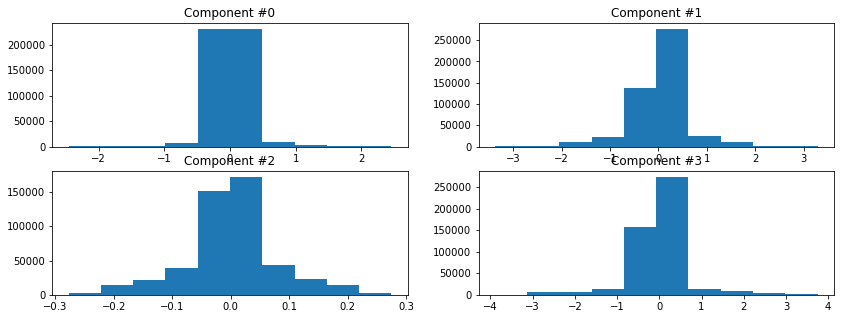

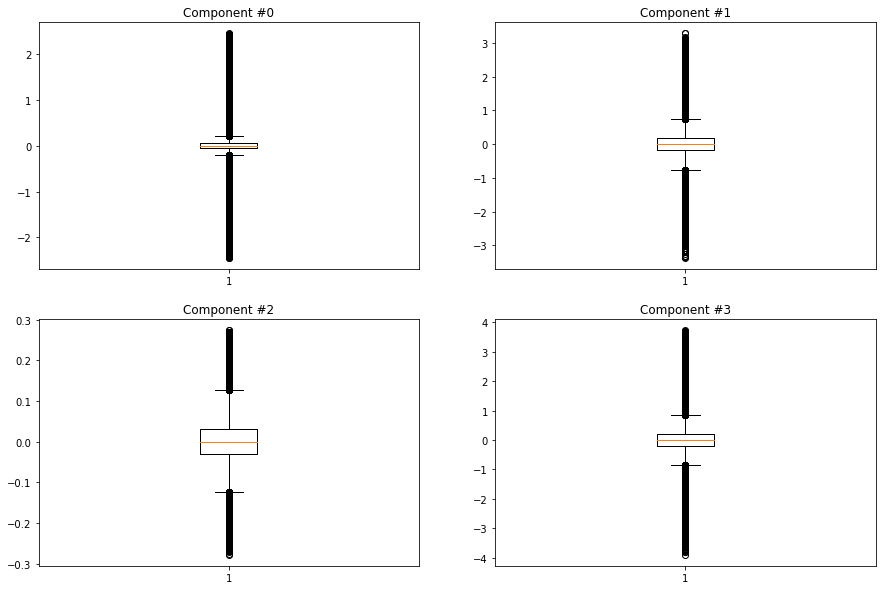

Min: -2.455527795073426
Max: 2.458200318765022

Min: -3.379809177285842
Max: 3.285249404091797

Min: -0.27721307842929566
Max: 0.2746514205311343

Min: -3.8955323452106527
Max: 3.7458257681556684



In [3]:
env = gym.make('CartPole-v0')
all_obs = []

for i in range(10000):
    params = np.random.random(4) * 2 - 1
    _, observations = play_one_episode(env, params)
    all_obs += observations
    
all_obs = np.array(all_obs)
for i in range(4):
    plt.subplot(220 + i + 1)
    plt.title('Component #{}'.format(i))
    plt.hist(all_obs[:, i])
plt.show()

plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(220 + i + 1)
    plt.title('Component #{}'.format(i))
    plt.boxplot(all_obs[:, i])
plt.show()

for i in range(4):
    print('Min: {}'.format(all_obs[:, i].min()))
    print('Max: {}'.format(all_obs[:, i].max()))
    print()

Now I create 10 bins for each component to represent the state as a unique number

In [37]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))
    
def to_bin(value, bins):
    return np.digitize([value], bins)

class FeatureTransformer:
    def __init__(self):
        self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
        self.cart_speed_bins = np.linspace(-3, 3, 9)
        self.pole_angle_bins = np.linspace(-0.25, 0.25, 9)
        self.pole_speed_bins = np.linspace(-3.8, 3.8, 9)
        
    def transform(self, observation):
        cart_pos, cart_speed, pole_angle, pole_speed = observation
        return build_state([
                            to_bin(cart_pos, self.cart_position_bins),
                            to_bin(cart_speed, self.cart_speed_bins),
                            to_bin(pole_angle, self.pole_angle_bins),
                            to_bin(pole_speed, self.pole_speed_bins)
                            ])
        

Now I create the model to represent the Q value function with a table indexed by state and action

In [38]:
class Model:
    def __init__(self, env, feature_transformer, learning_rate=10e-3):
        self.env = env
        self.feature_transformer = feature_transformer
        self.learning_rate = learning_rate
        
        num_states = 10 ** env.observation_space.shape[0]
        #num_states = 19191919
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))
        
    # return the Q values for state s
    def predict(self, s):
        x = self.feature_transformer.transform(s)
        return self.Q[x]
    
    # perform one step of gradient descent
    def update(self, s, a, G):
        x = self.feature_transformer.transform(s)
        self.Q[x, a] += self.learning_rate * (G - self.Q[x, a])
        
    # take an epsilon-greedy action
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

Now define the function to play one episode

In [15]:
def play_one_episode(model, env, eps, gamma, display=False):
    observation = env.reset()
    done = False
    total_reward = 0
    iters = 0
    frames = []
    while not done:
        if display:
            frames.append(env.render(mode='rgb_array'))
        prev_observation = observation
        action = model.sample_action(observation, eps)
        observation, reward, done, info = env.step(action)
        
        total_reward += reward
        if done and iters < 199:
            reward = -300
            
        G = reward + gamma * np.max(model.predict(observation))
        model.update(prev_observation, action, G)
        iters += 1
        if done and display:
            env.render(close=True)
            display_frames_as_gif(frames)
        
    return total_reward

Let's run some episodes to see if the model can learn

In [43]:
def plot_running_avg(total_rewards):
    avg = np.empty(len(total_rewards))
    for i in range(len(total_rewards)):
        avg[i] = total_rewards[max(0, i-100): i+1].mean()
    plt.plot(avg)
    plt.title('Running Average')
    plt.show()
    
env = gym.make('CartPole-v0')
ft = FeatureTransformer()
model = Model(env, ft)
gamma = 0.9

N = 10000
total_rewards = np.empty(N)
for i in range(N):
    eps = 1 / np.sqrt(i + 1)
    total_rewards[i] = play_one_episode(model, env, eps, gamma)
    if i % 100 == 0:
        print('Episode: {}\tTotal reward: {}\tEps: {}'.format(i, total_rewards[i], eps))

[2018-01-20 17:35:49,066] Making new env: CartPole-v0


Episode: 0	Total reward: 13.0	Eps: 1.0
Episode: 100	Total reward: 24.0	Eps: 0.09950371902099892
Episode: 200	Total reward: 27.0	Eps: 0.07053456158585983
Episode: 300	Total reward: 72.0	Eps: 0.0576390417704235
Episode: 400	Total reward: 95.0	Eps: 0.04993761694389223
Episode: 500	Total reward: 127.0	Eps: 0.04467670516087703
Episode: 600	Total reward: 104.0	Eps: 0.04079085082240021
Episode: 700	Total reward: 84.0	Eps: 0.0377694787300249
Episode: 800	Total reward: 200.0	Eps: 0.03533326266687867
Episode: 900	Total reward: 89.0	Eps: 0.03331483023263848
Episode: 1000	Total reward: 92.0	Eps: 0.0316069770620507
Episode: 1100	Total reward: 97.0	Eps: 0.03013743873394561
Episode: 1200	Total reward: 100.0	Eps: 0.028855492841238062
Episode: 1300	Total reward: 90.0	Eps: 0.027724348650071385
Episode: 1400	Total reward: 199.0	Eps: 0.02671658425726324
Episode: 1500	Total reward: 88.0	Eps: 0.025811286645983367
Episode: 1600	Total reward: 119.0	Eps: 0.02499219116020307
Episode: 1700	Total reward: 114.0	Ep

Average reward for last 100 episodes: 148.42
Total steps: 1307040.0


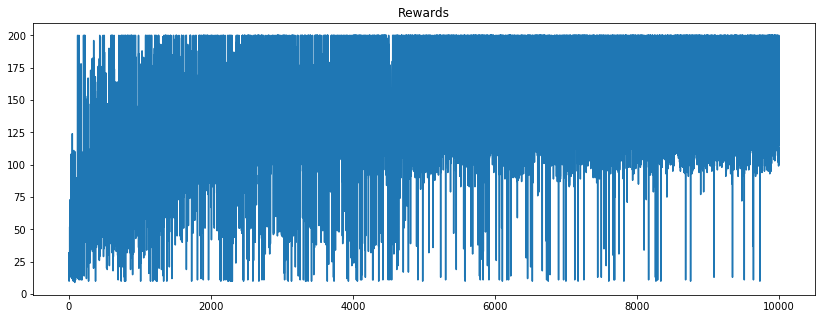

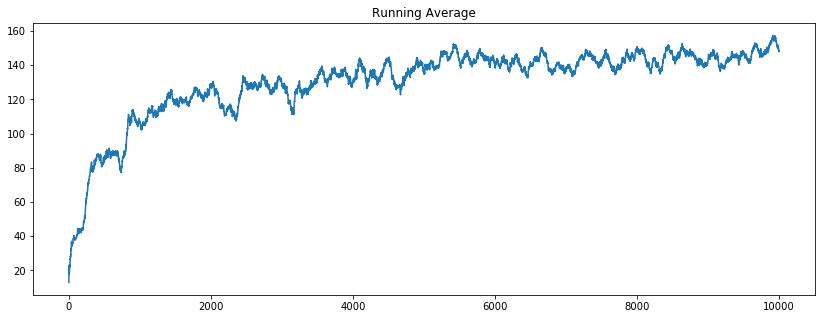

In [44]:
print('Average reward for last 100 episodes: {}'.format(total_rewards[-100:].mean()))
print('Total steps: {}'.format(total_rewards.sum()))

plt.plot(total_rewards)
plt.title('Rewards')
plt.show()

plot_running_avg(total_rewards)


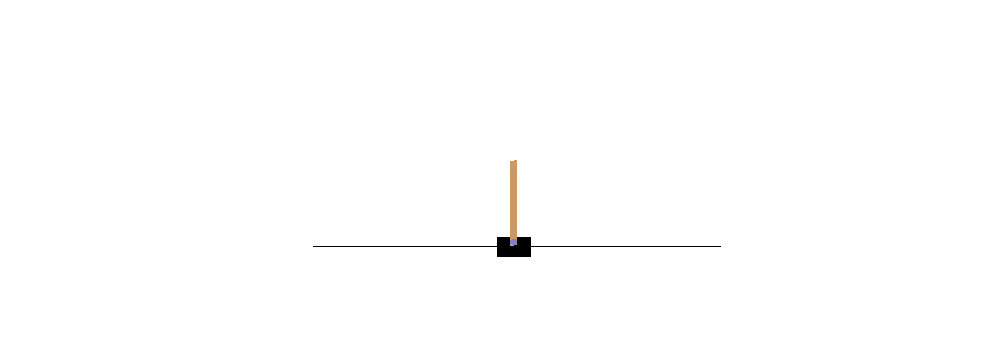
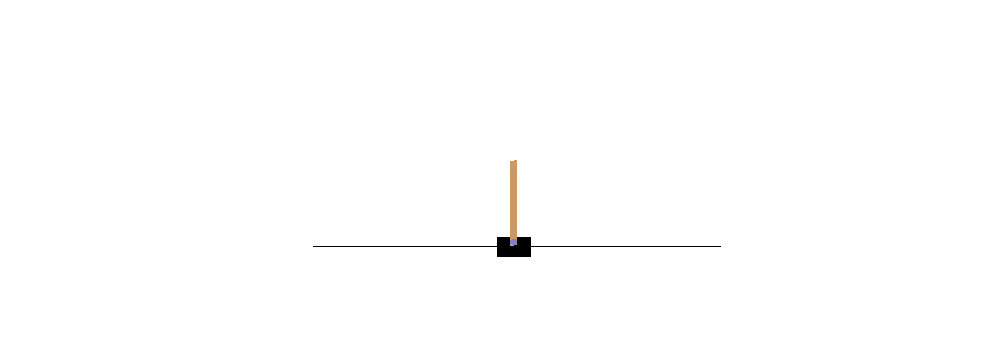
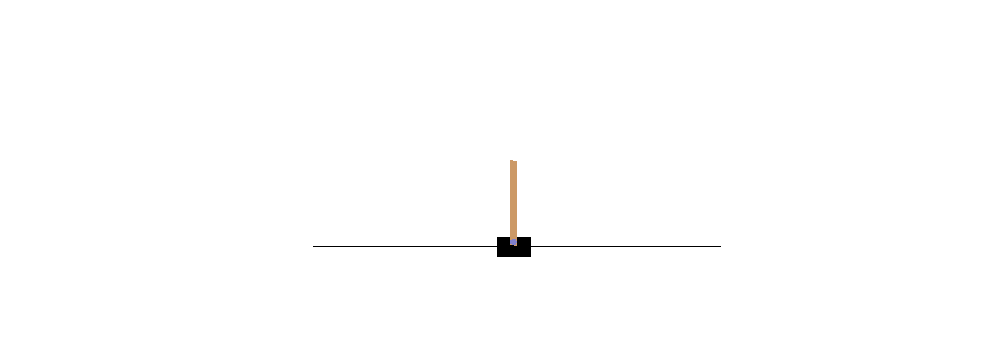
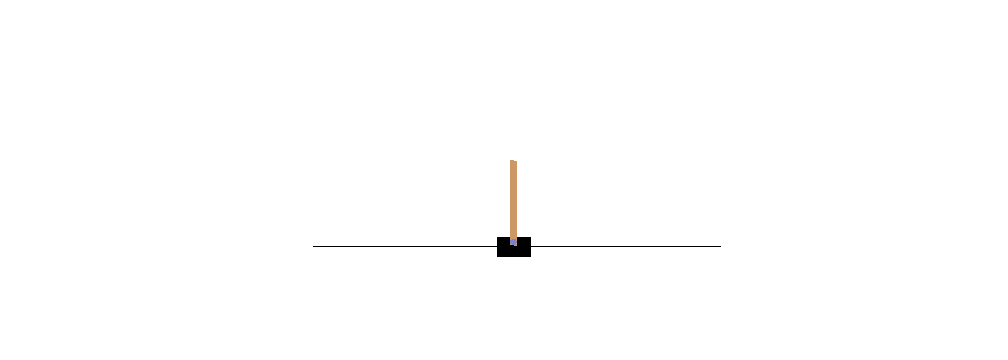
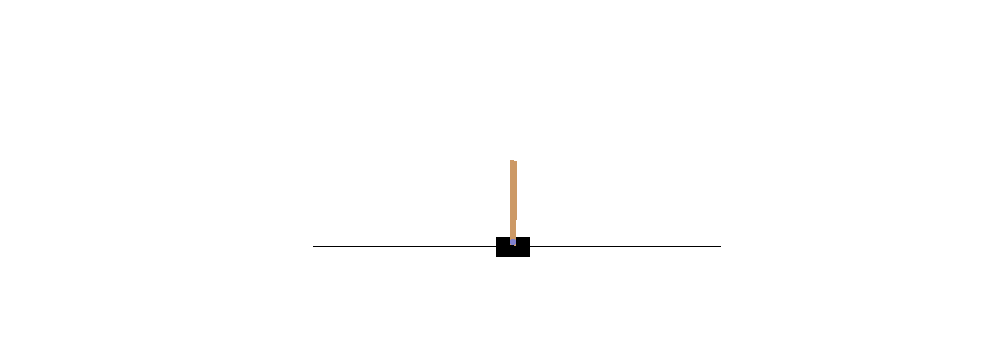
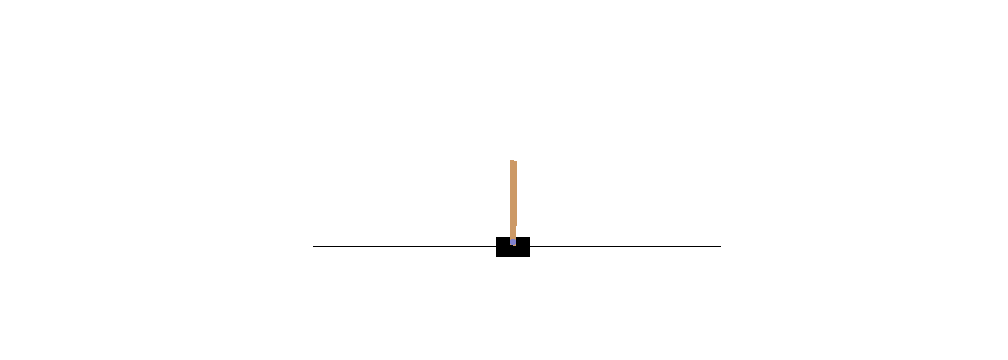
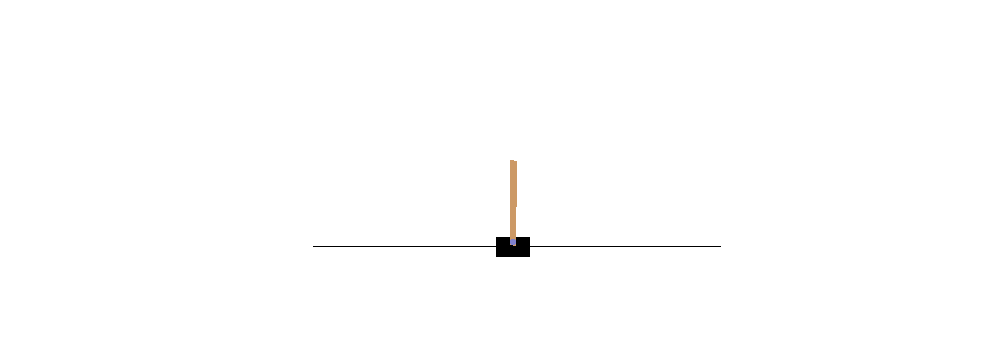
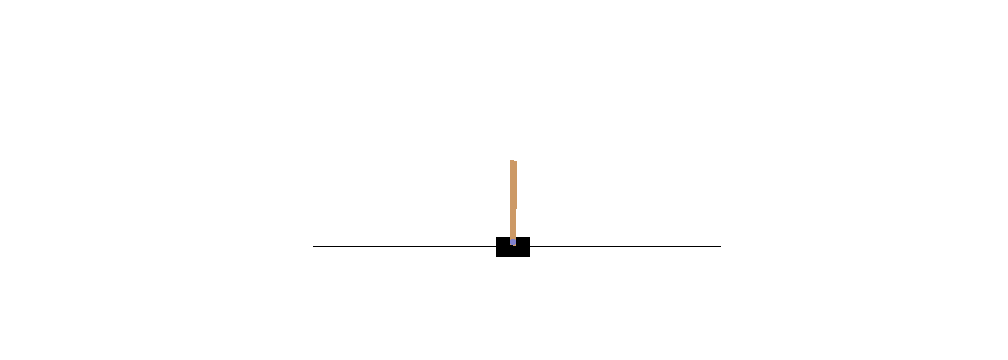
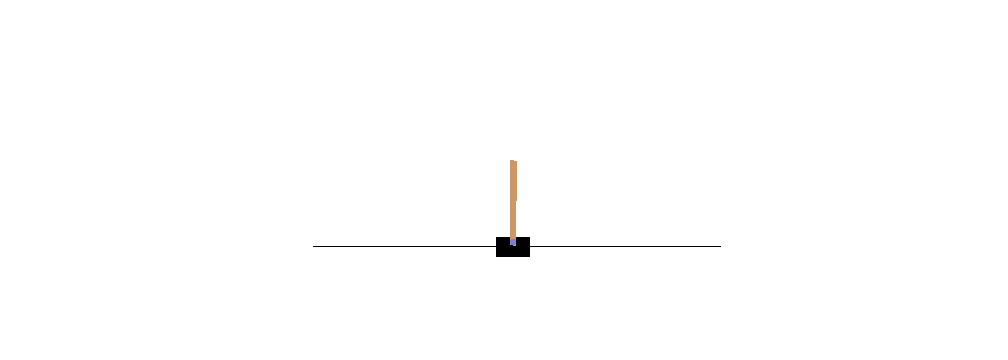
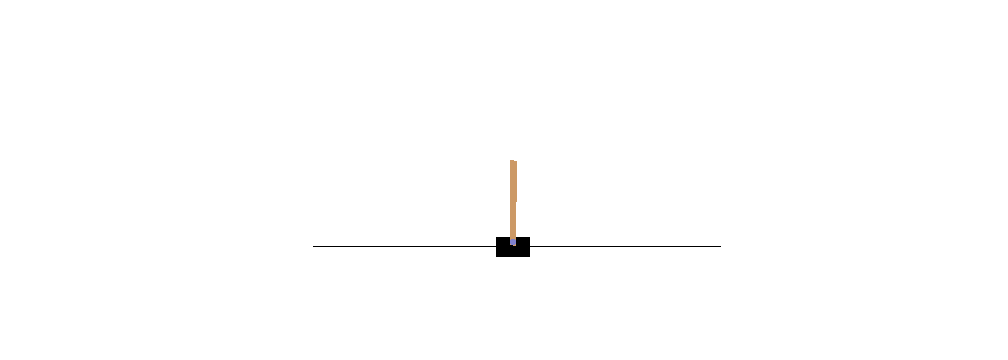
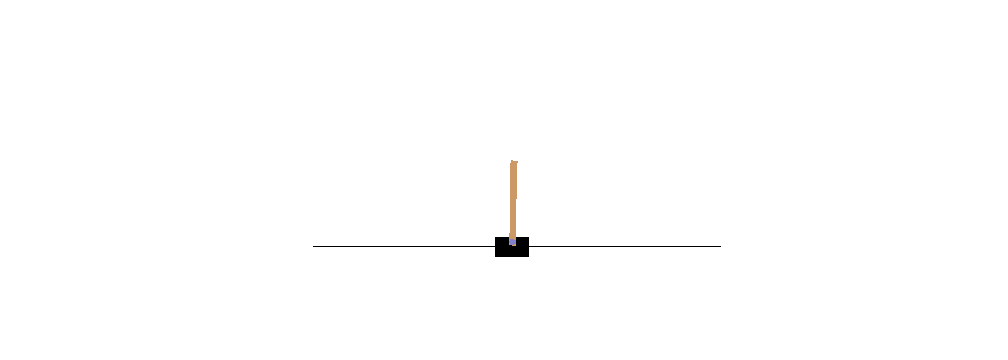
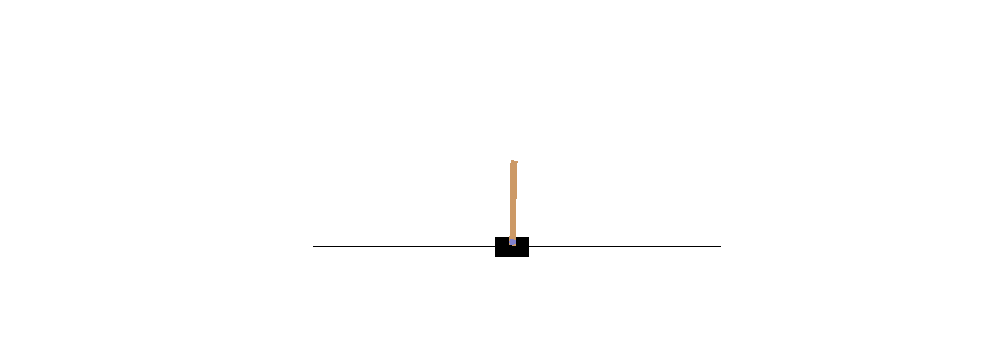
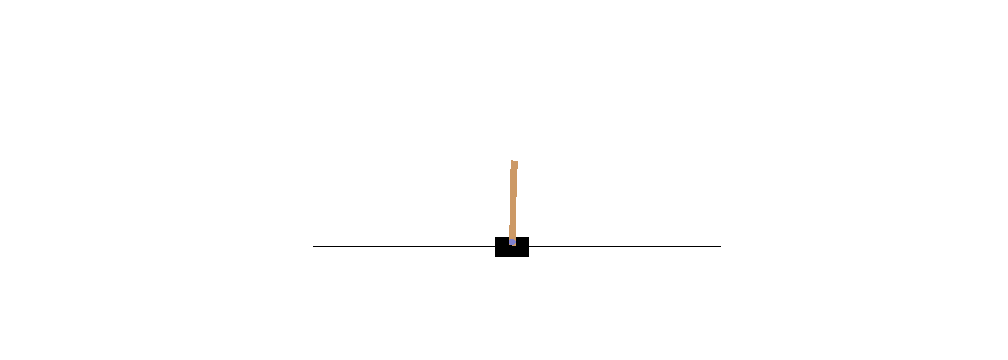
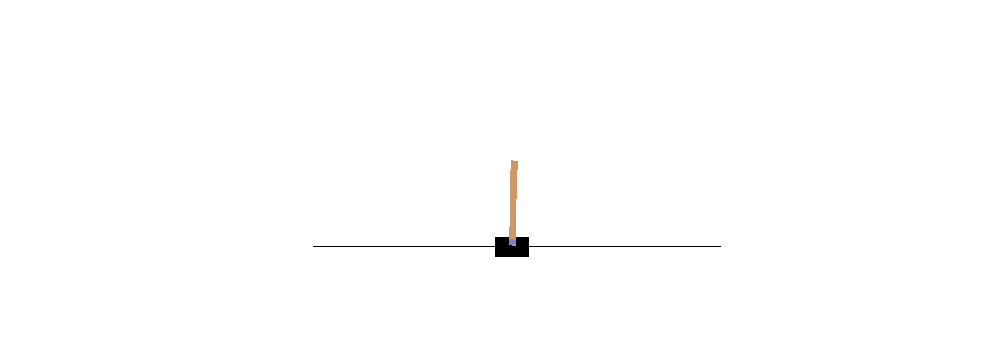
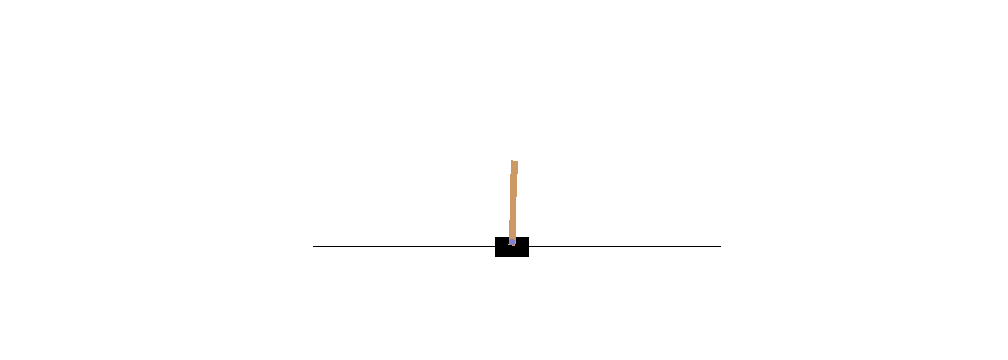
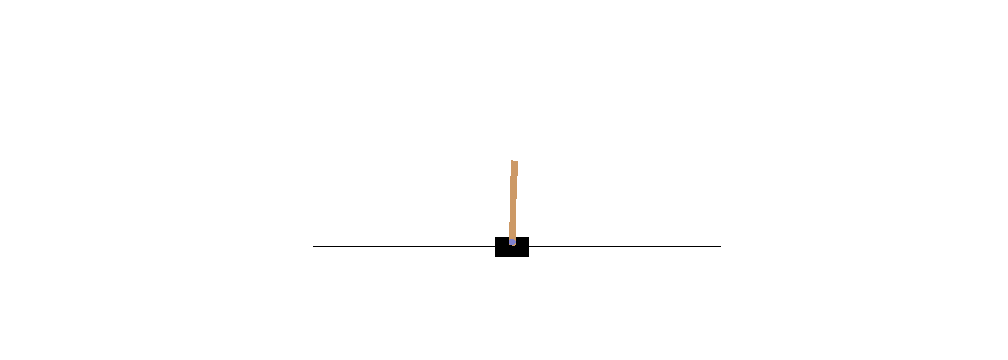
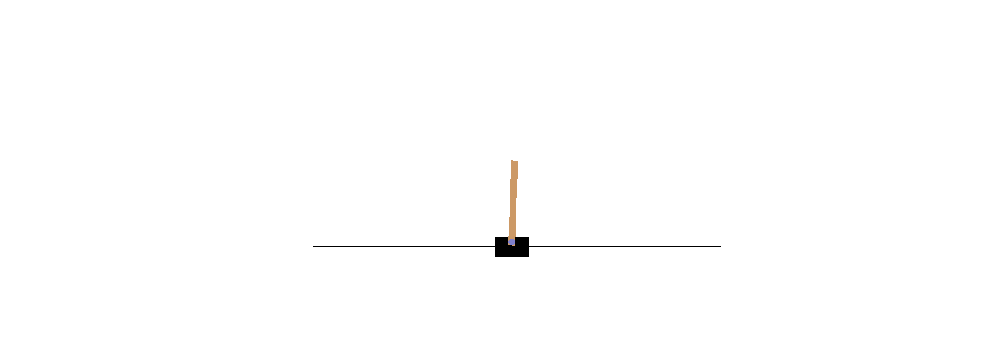
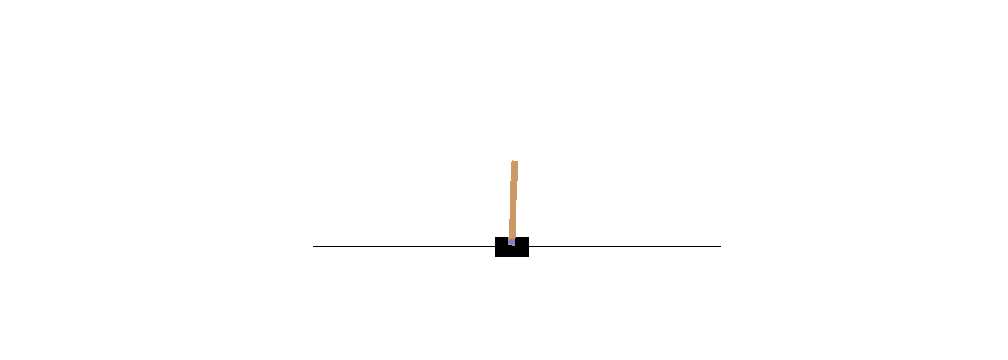
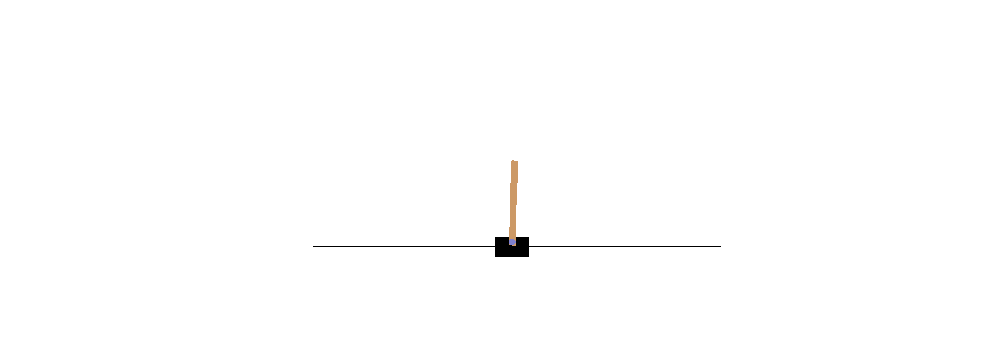
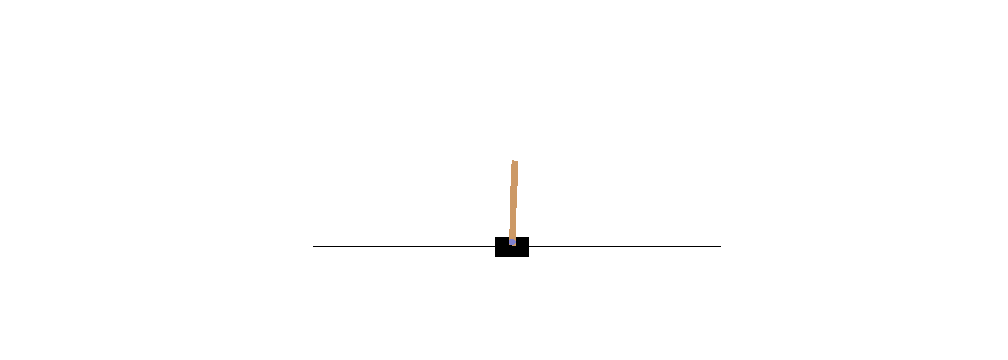
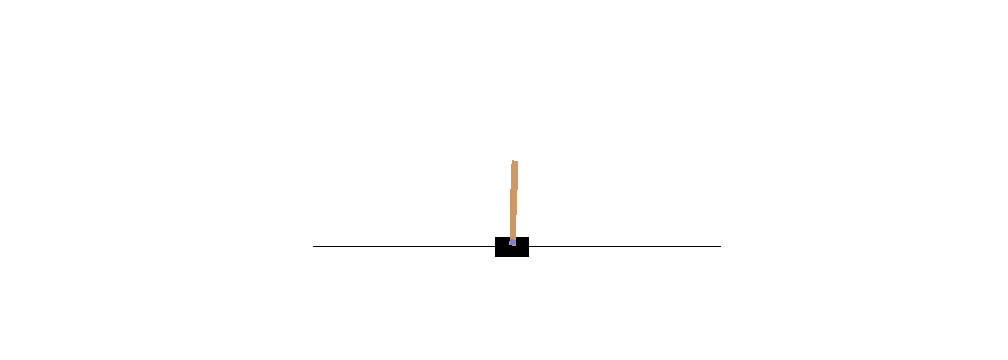
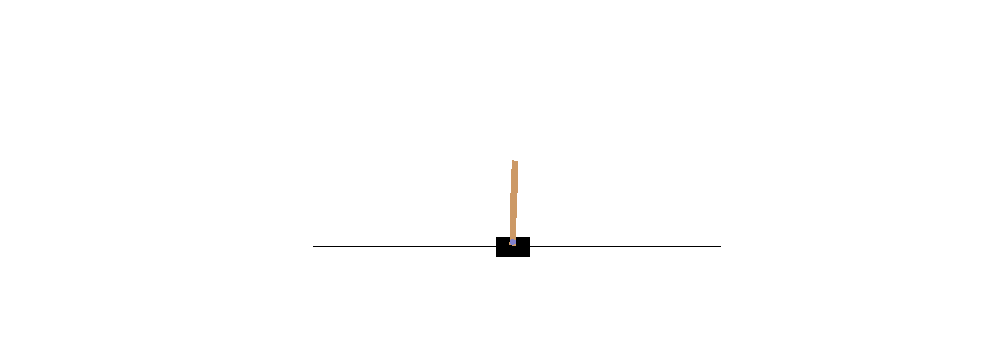
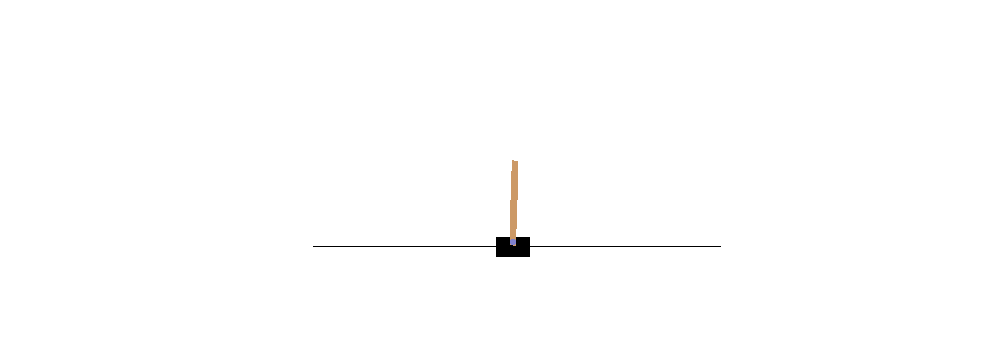
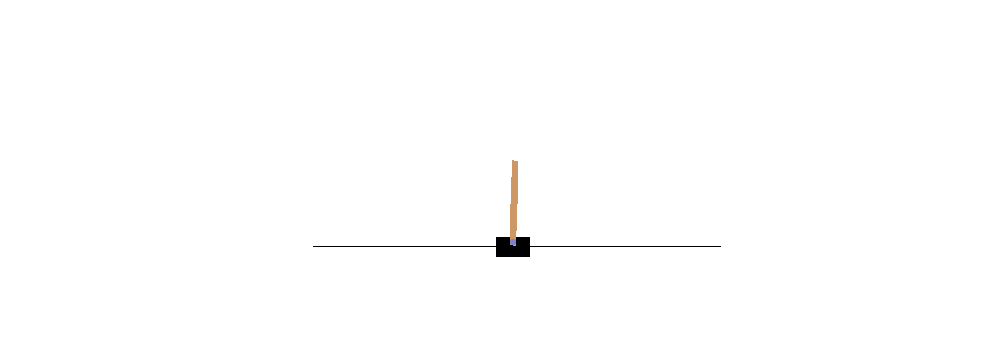
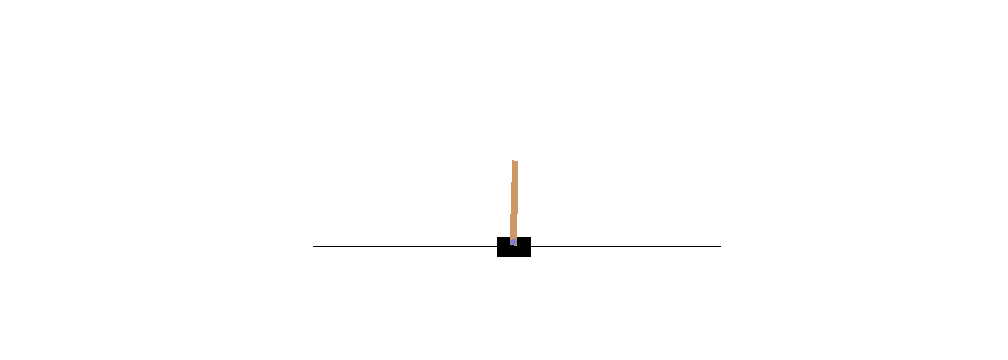
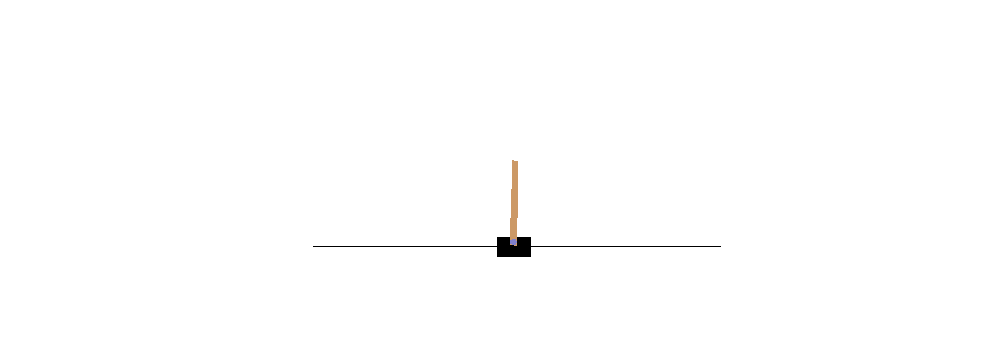
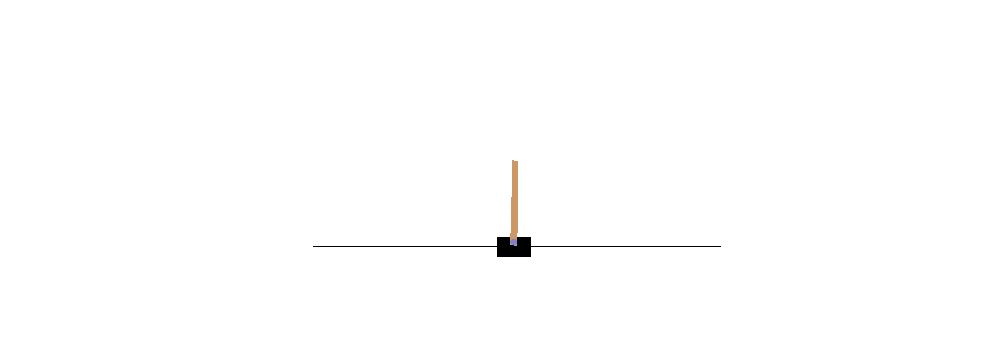
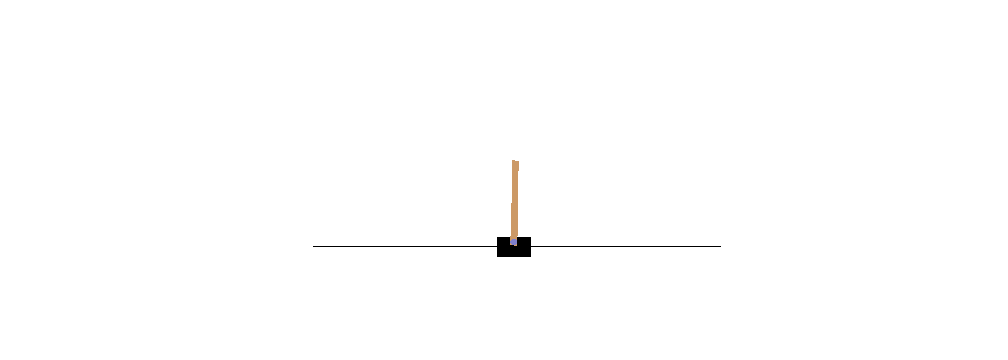
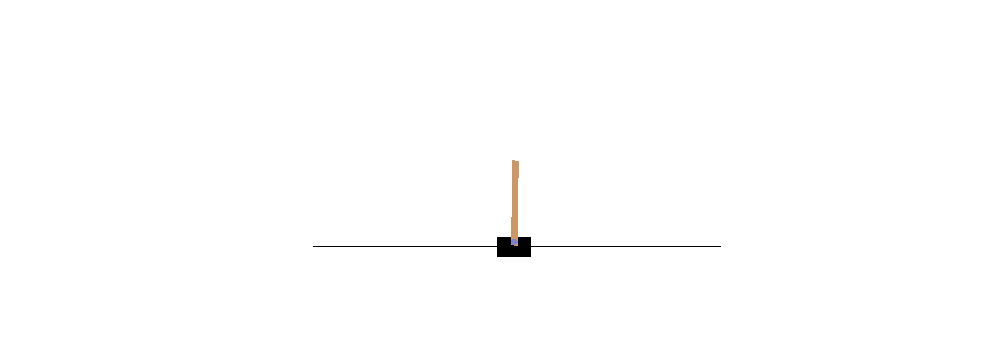
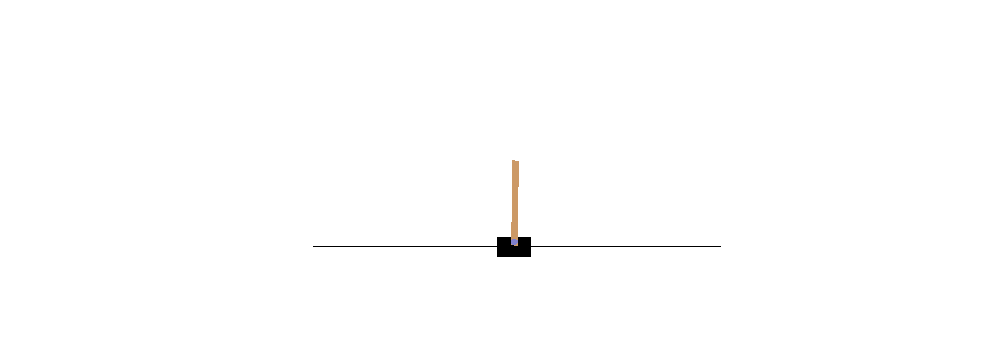
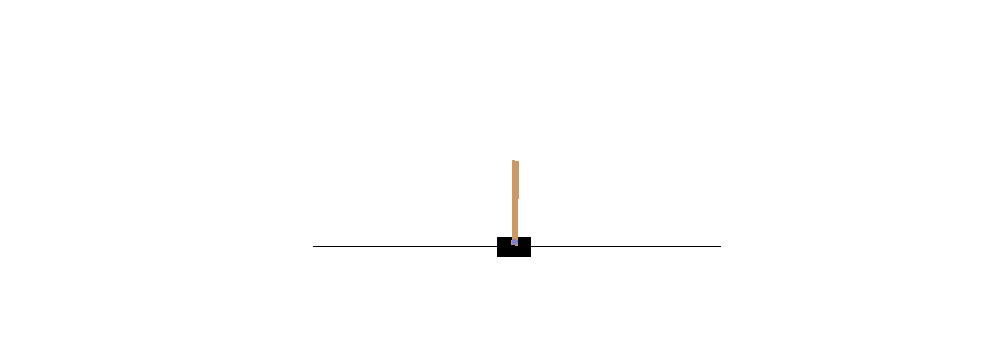
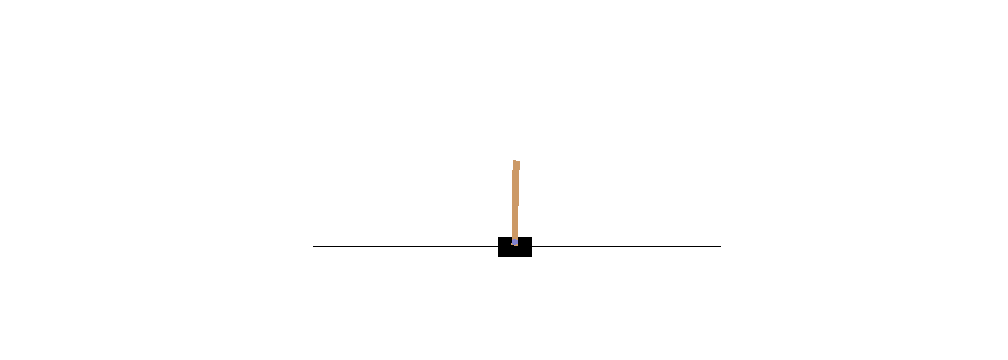
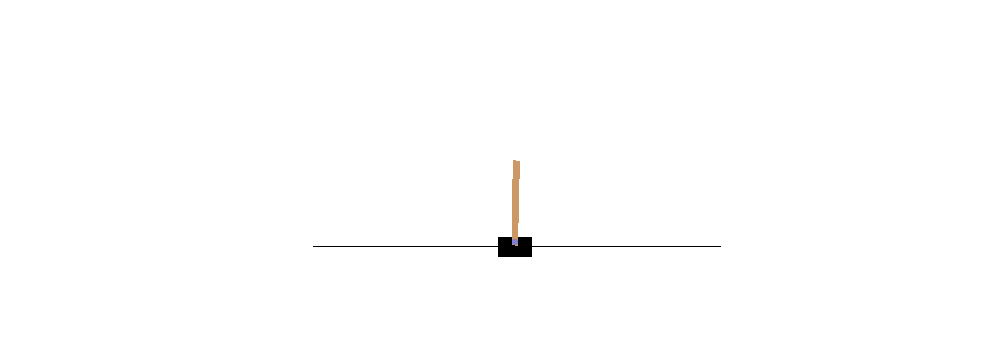
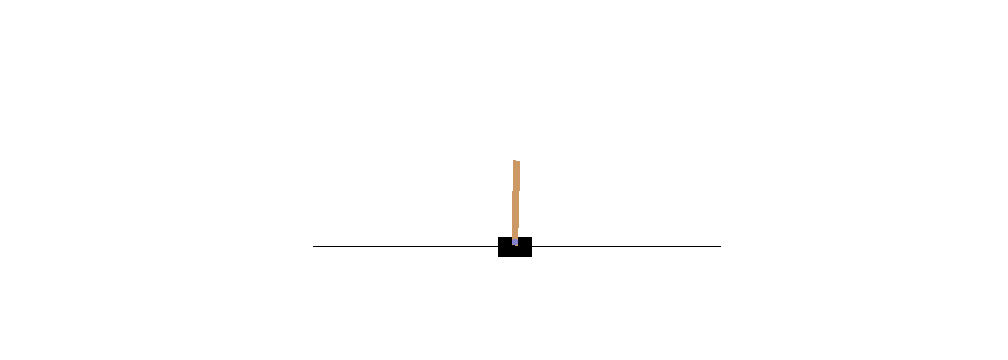
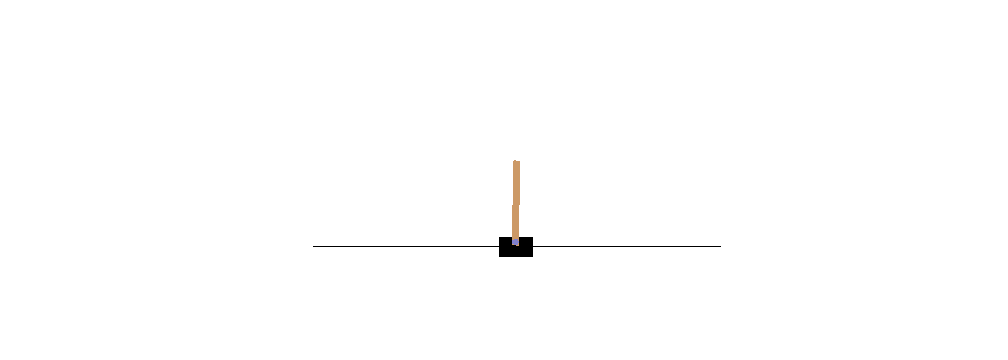
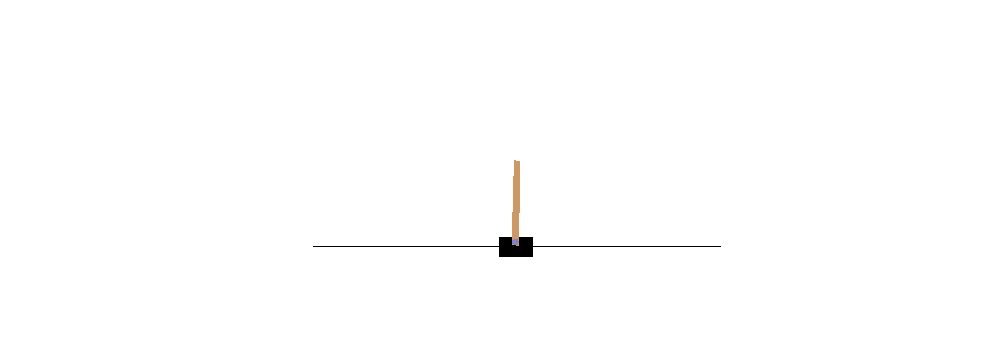
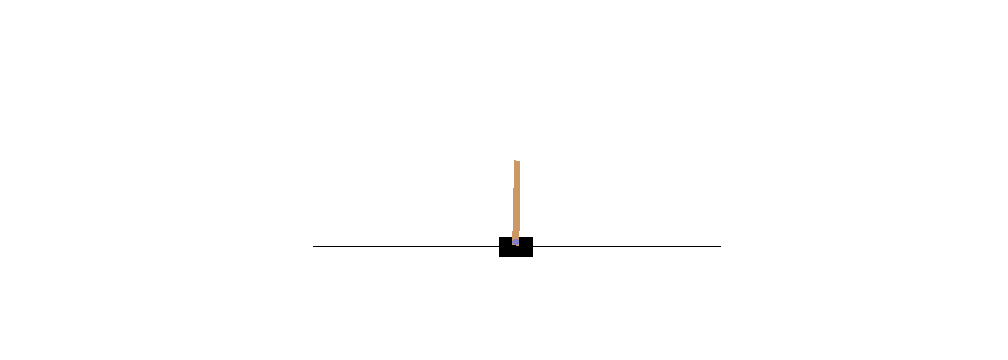
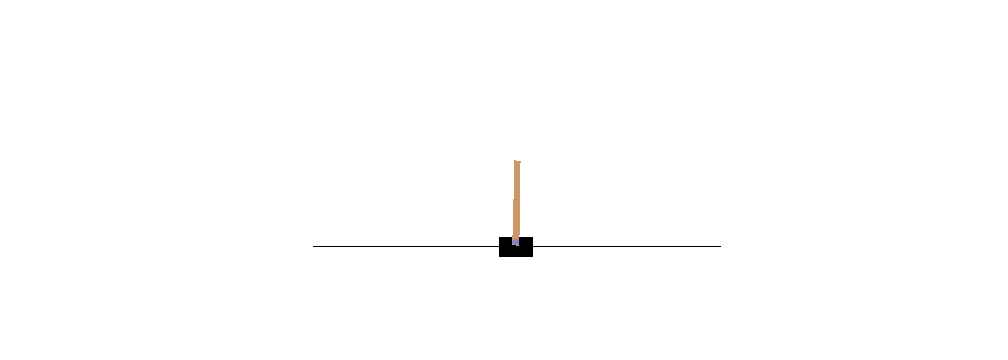
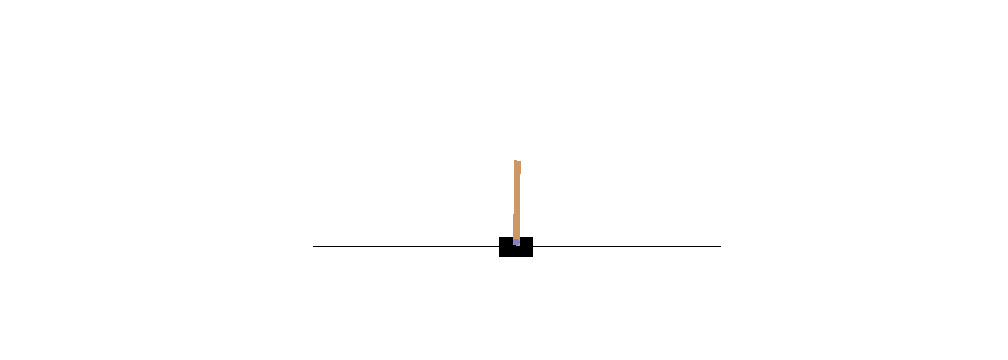
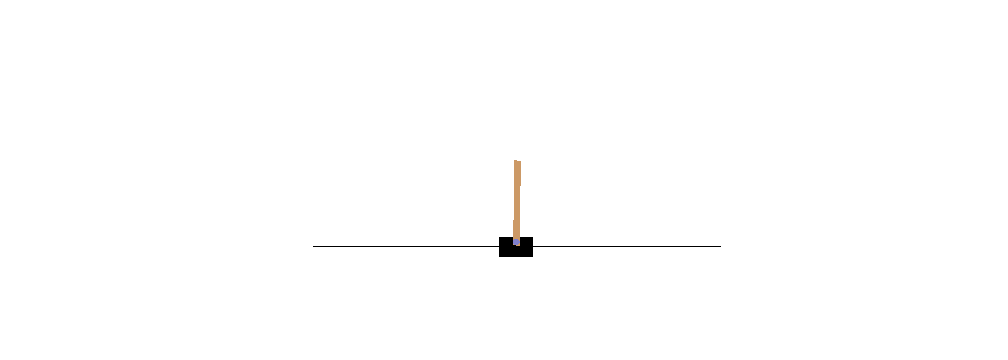
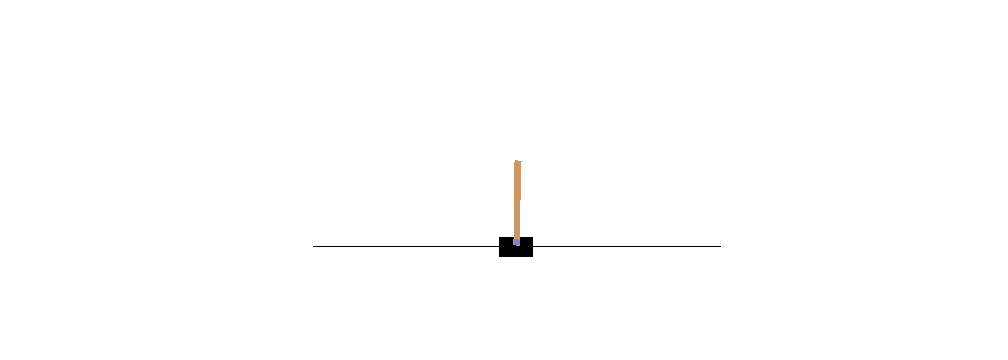
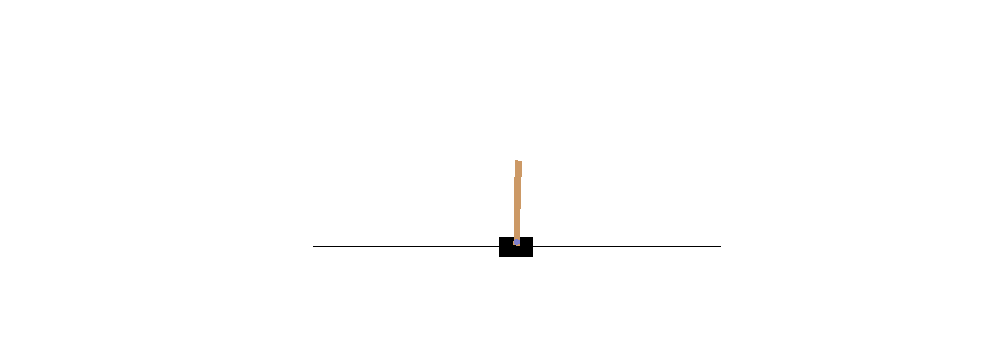
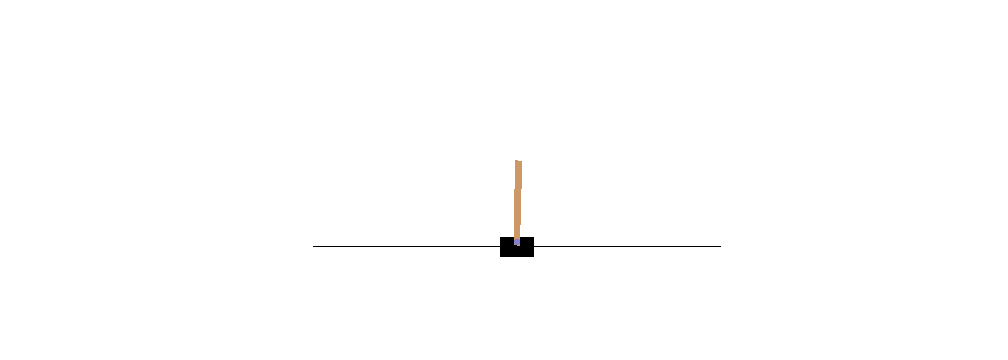
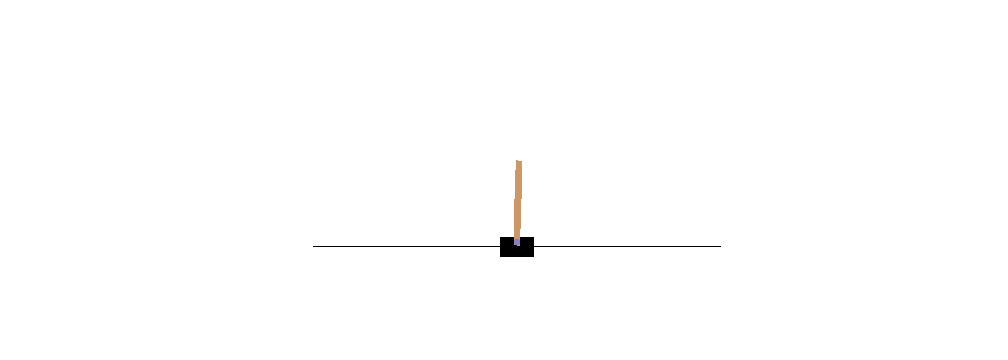
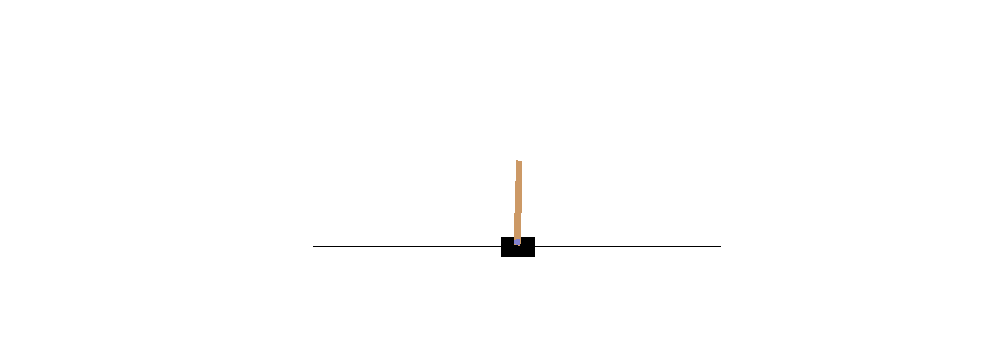
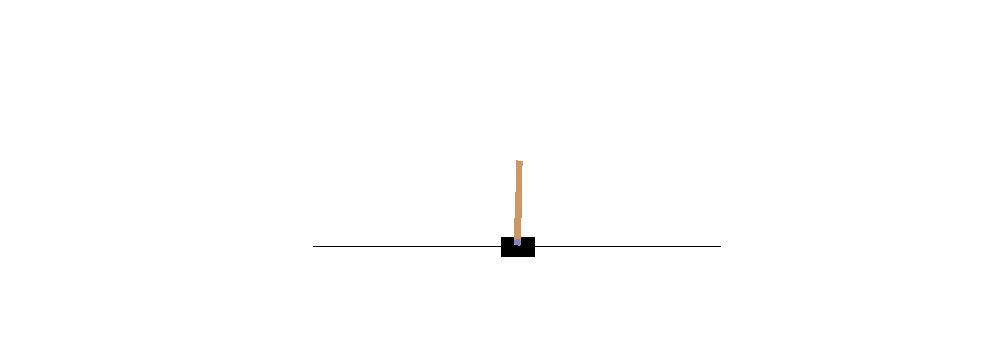
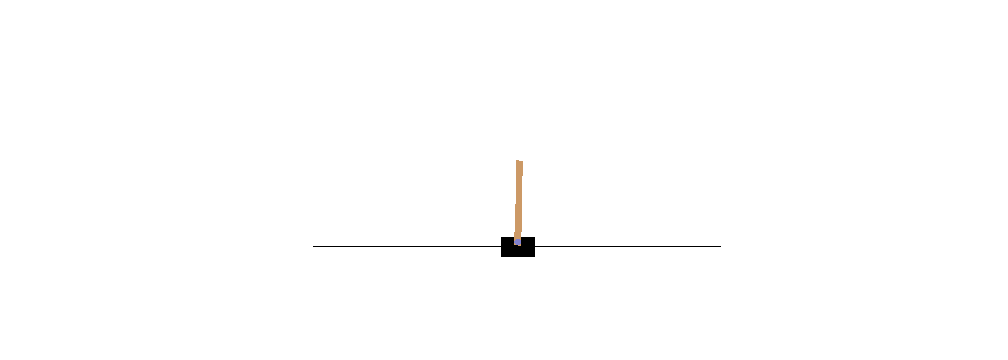
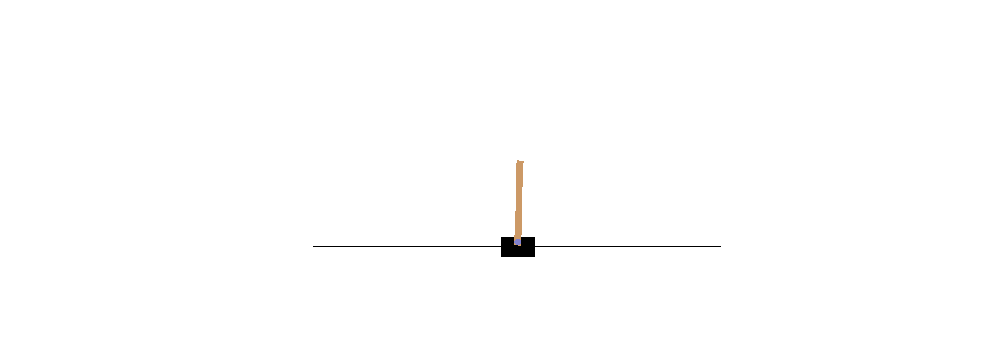
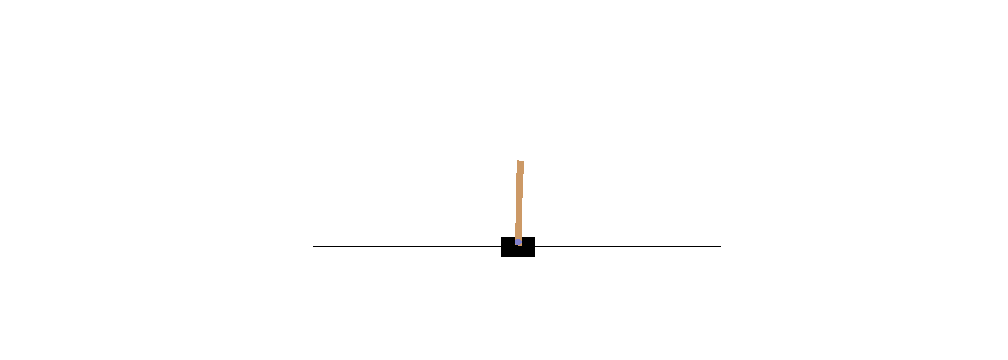
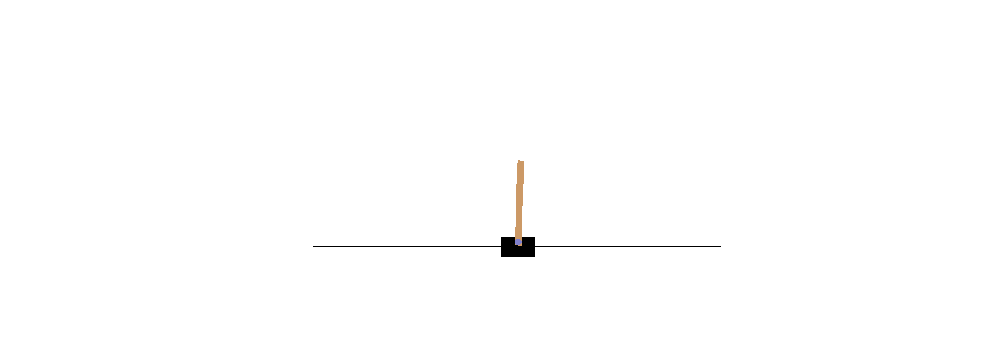
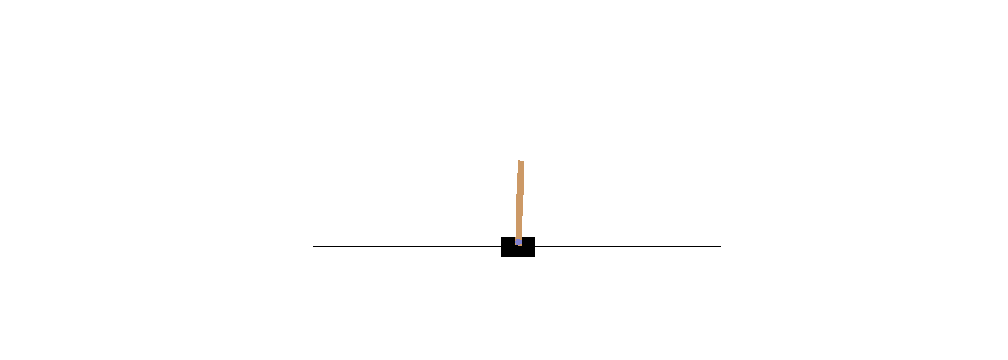
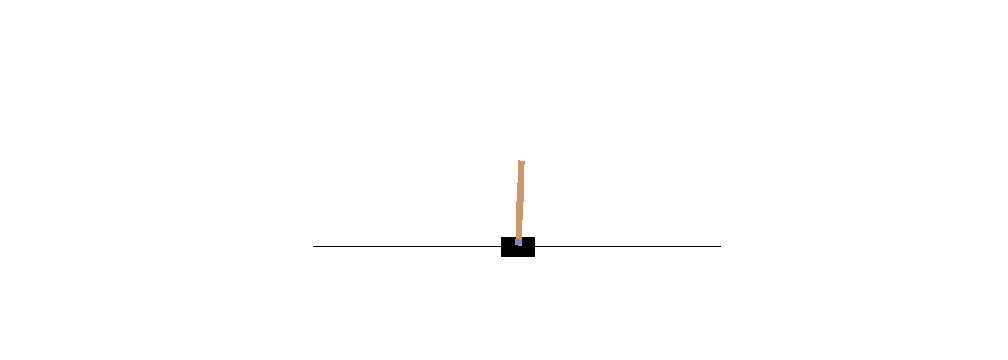
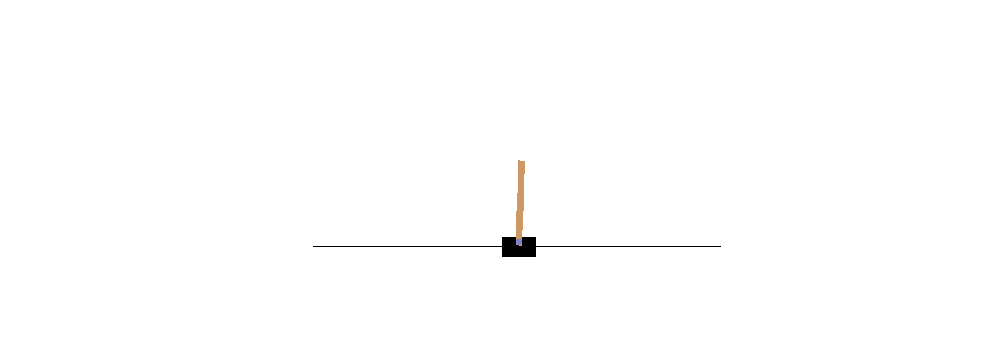
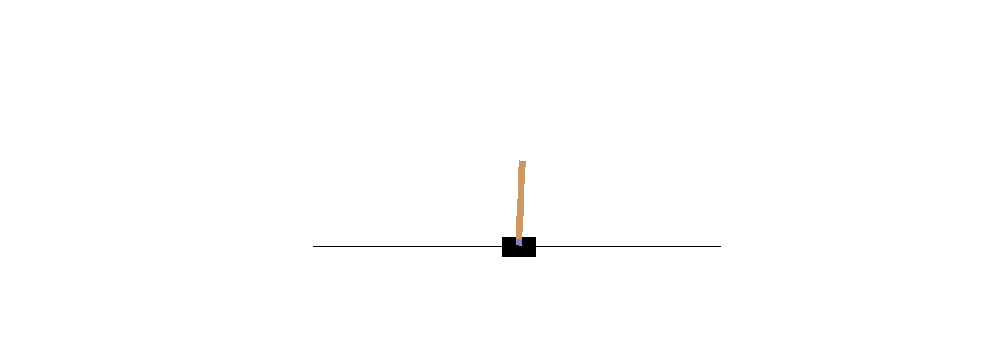
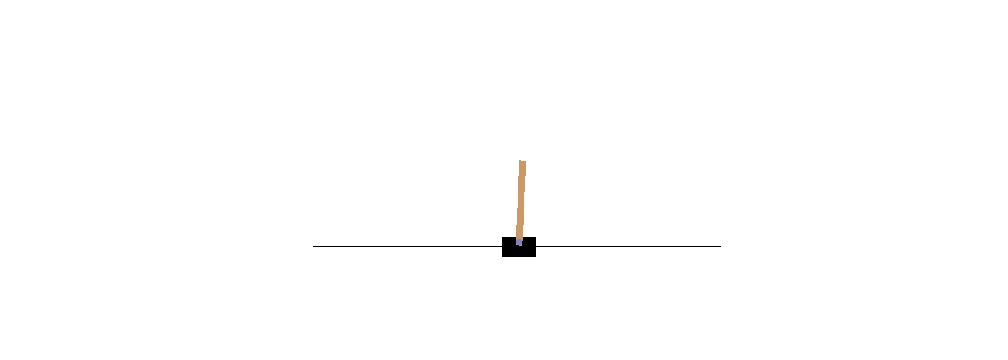
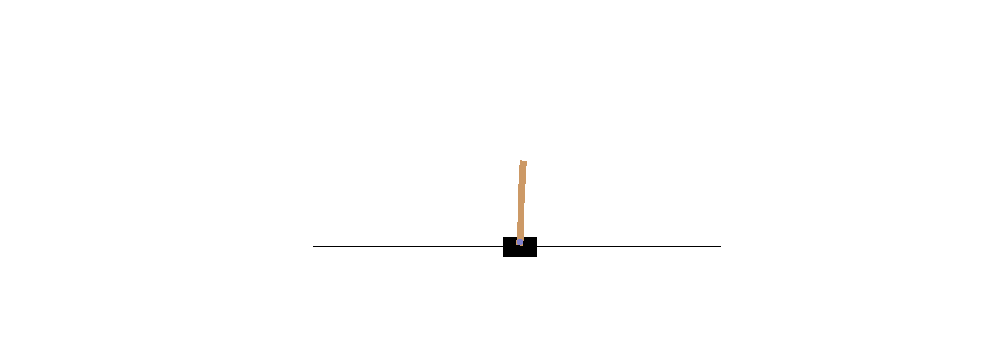
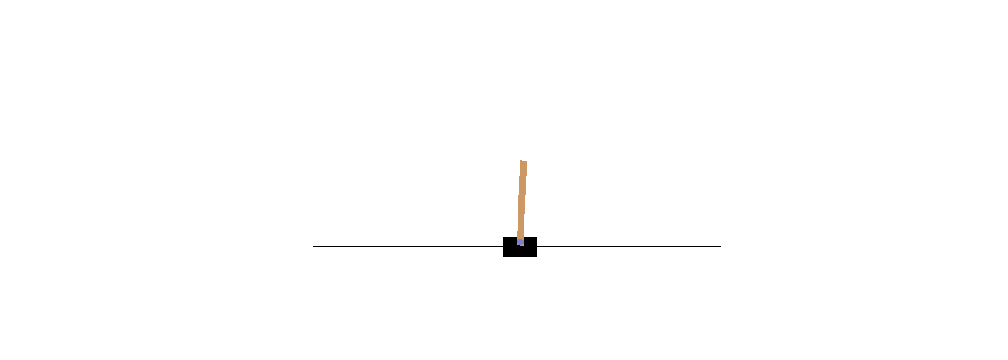
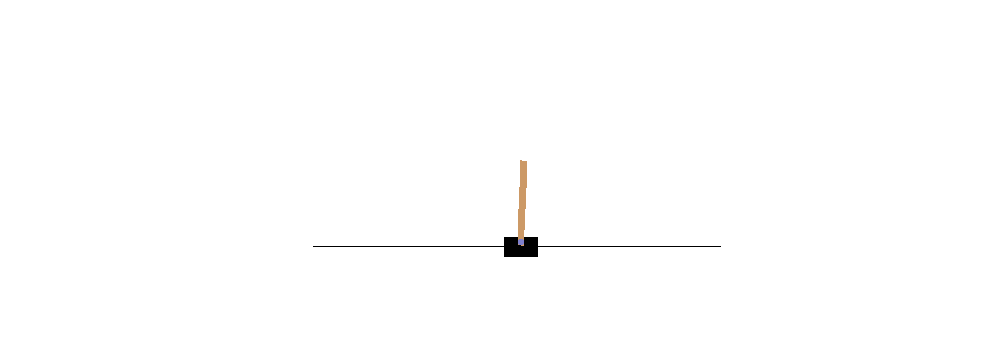
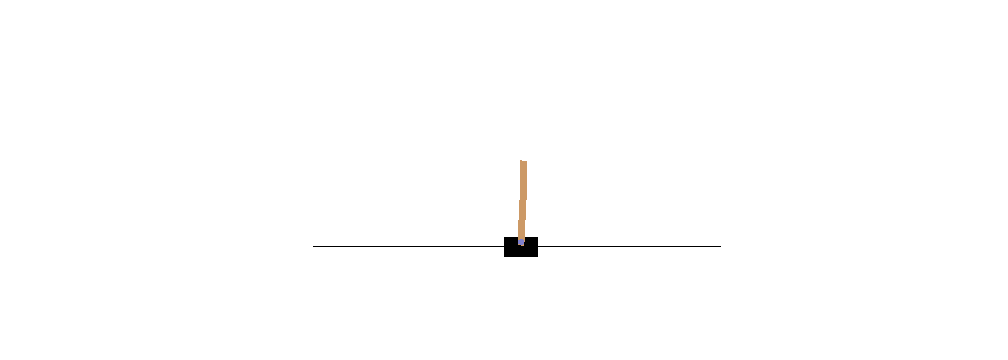
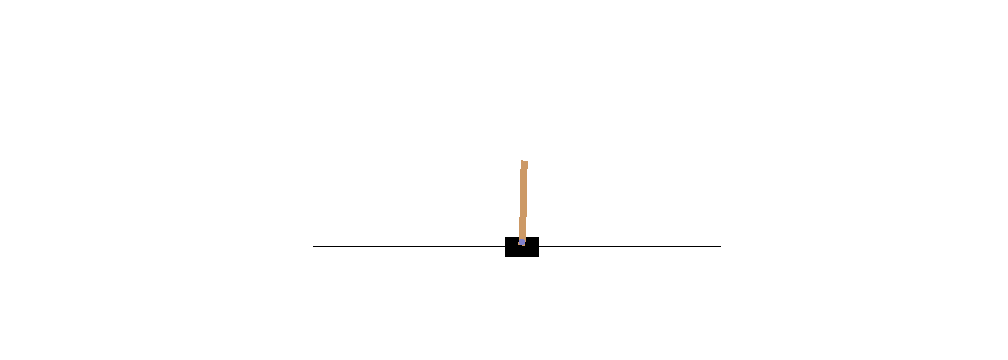
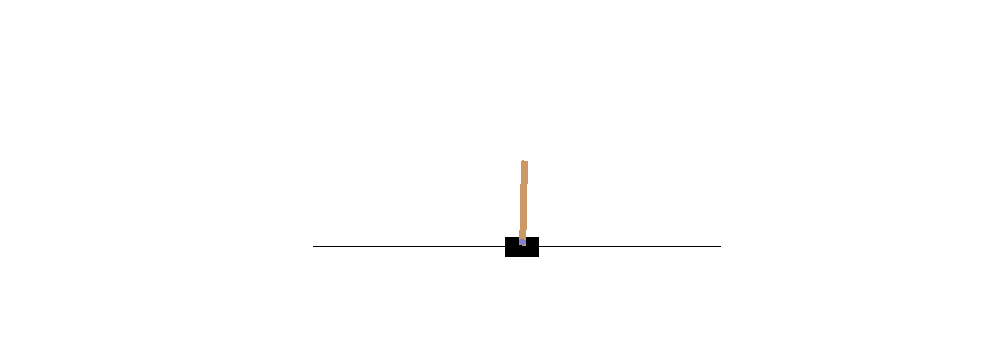
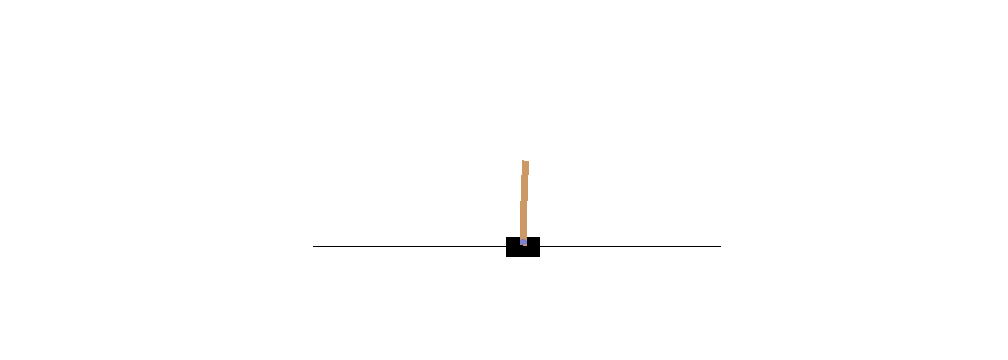
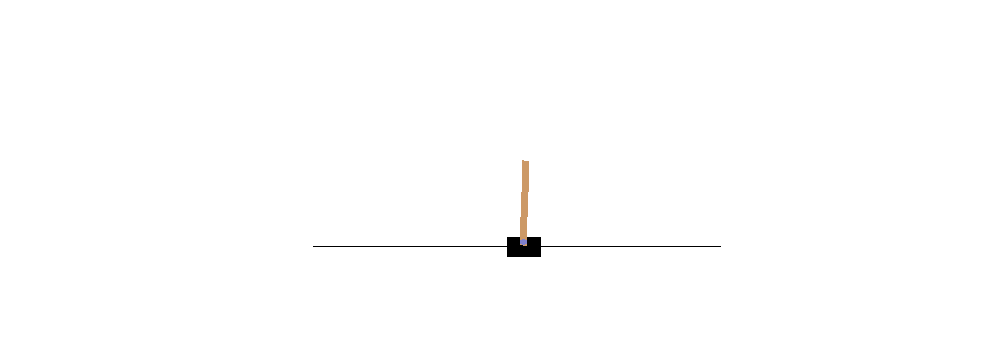
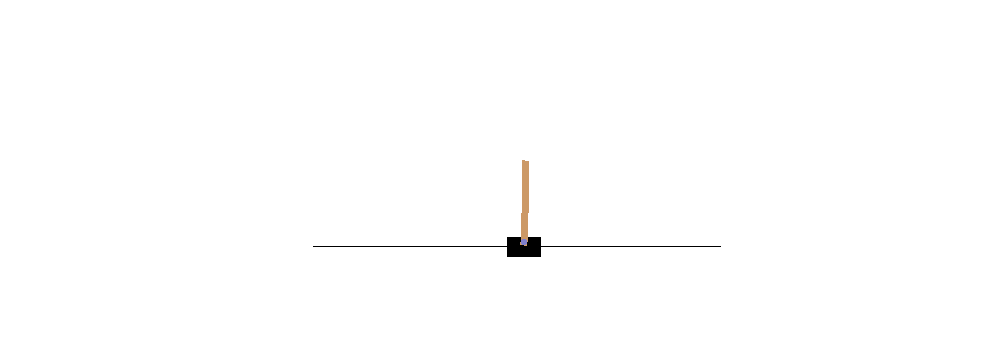
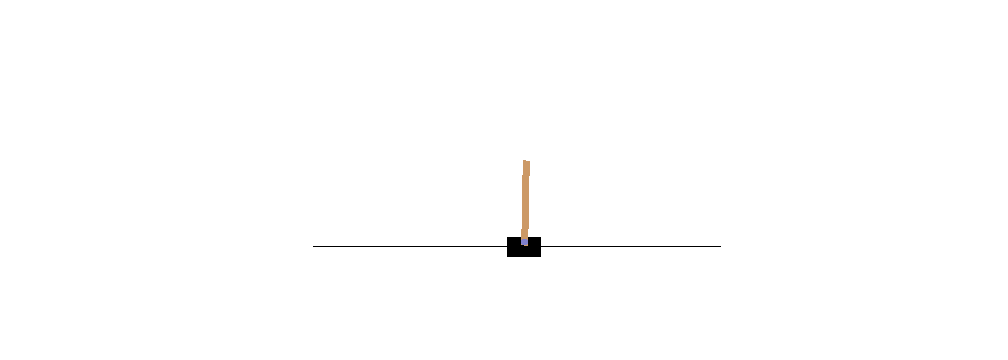
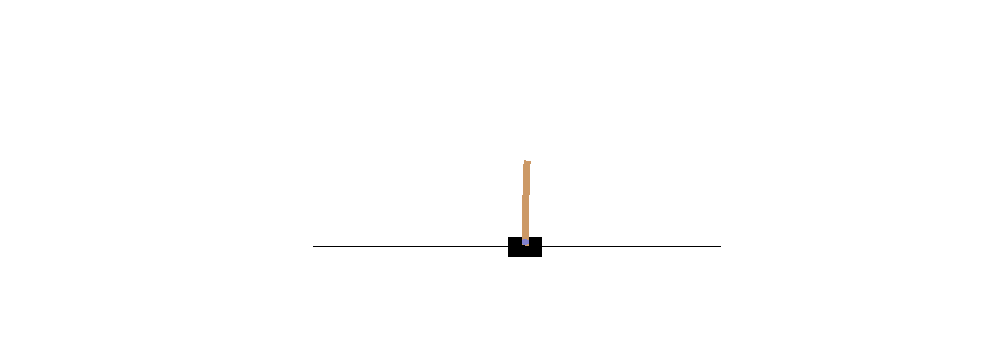
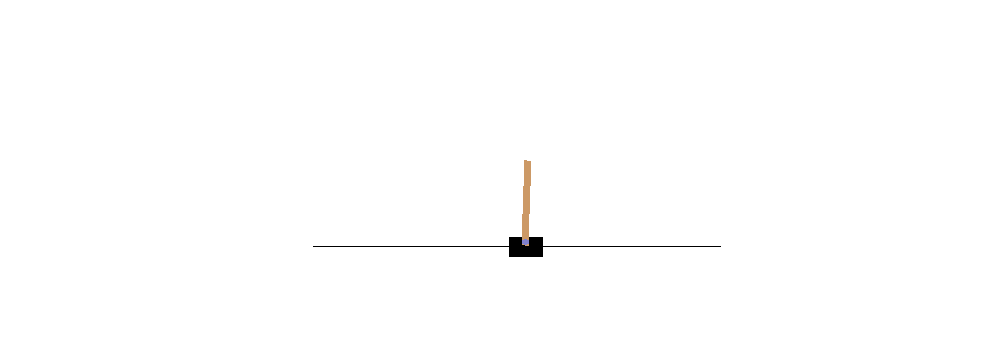
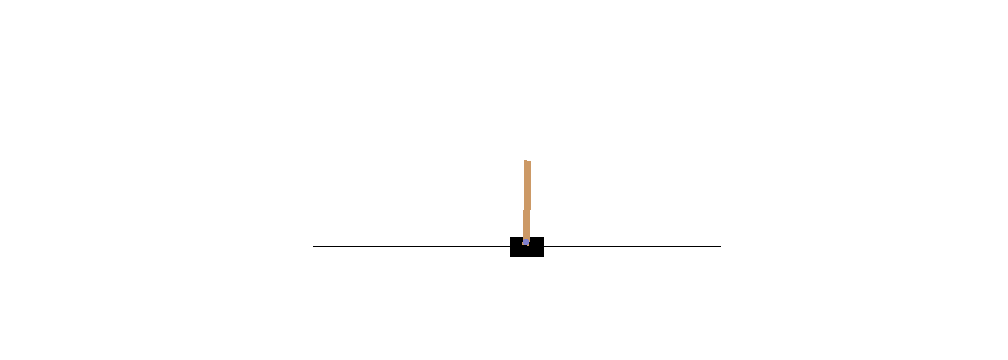
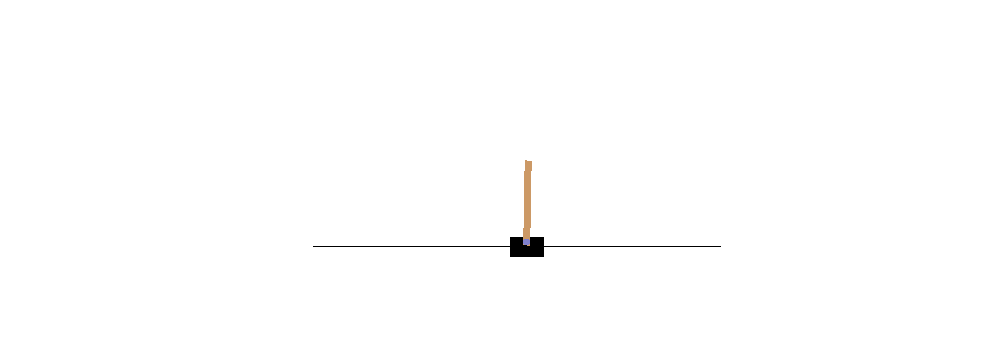
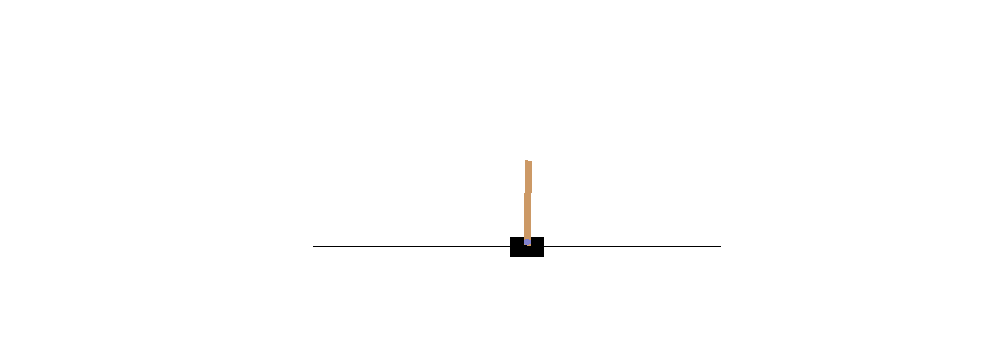
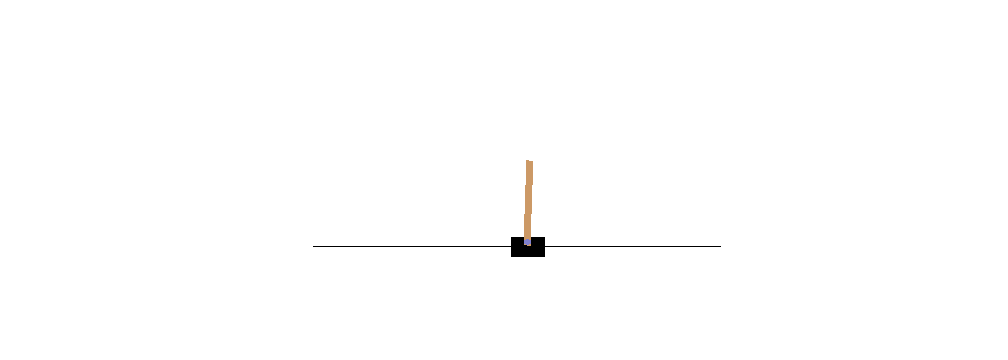
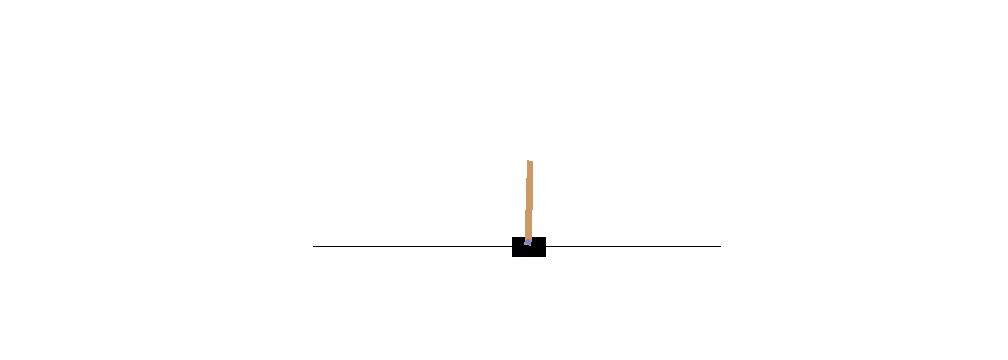
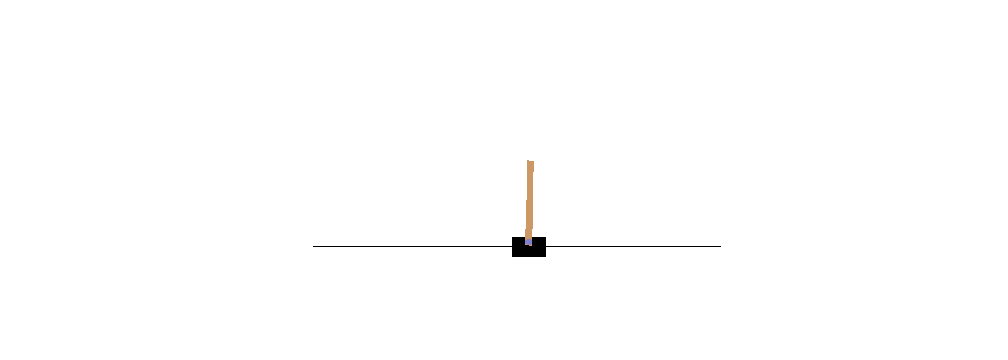
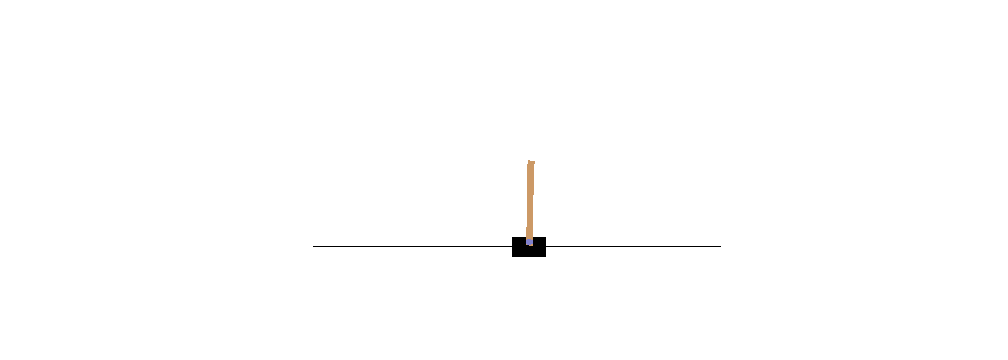
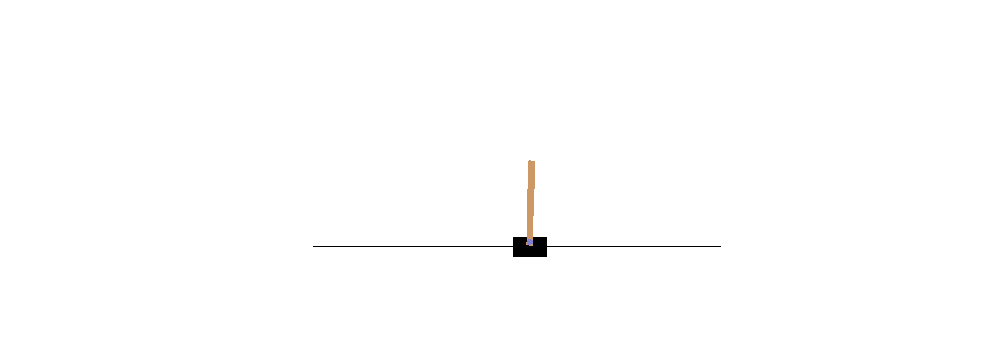
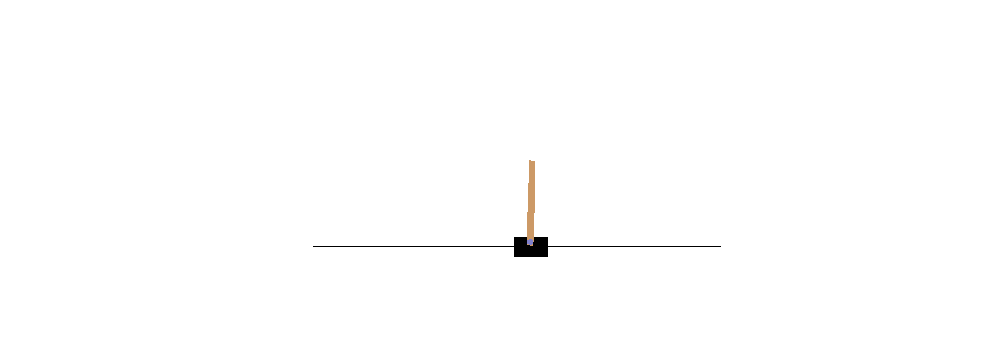
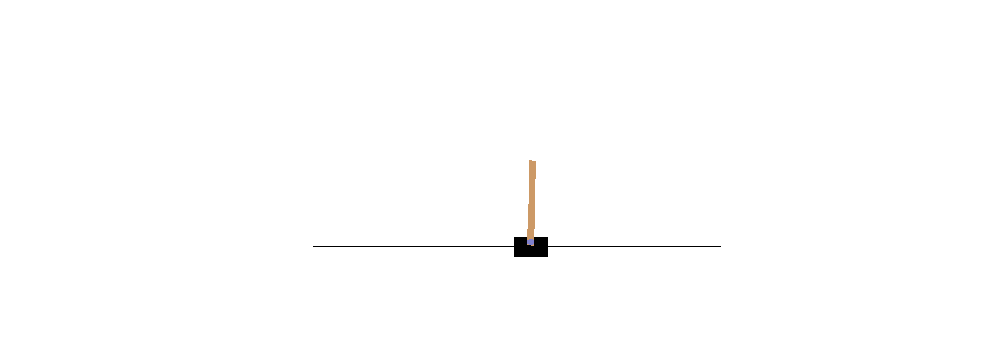
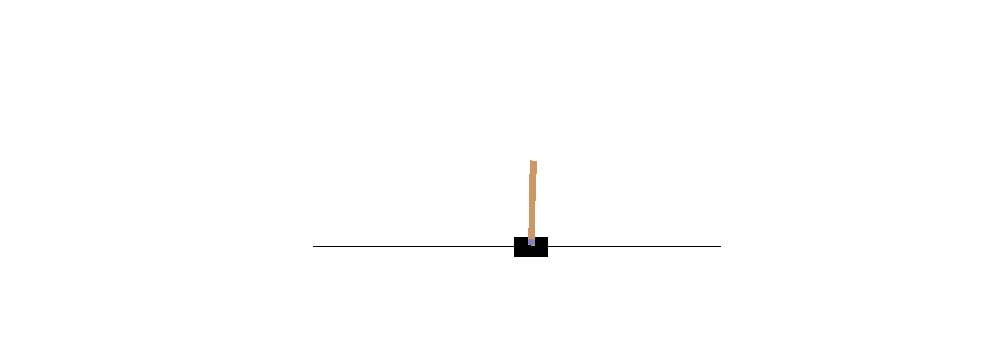
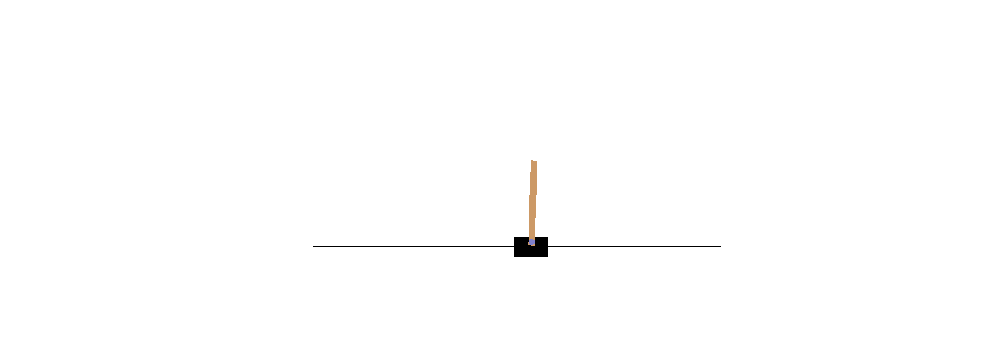
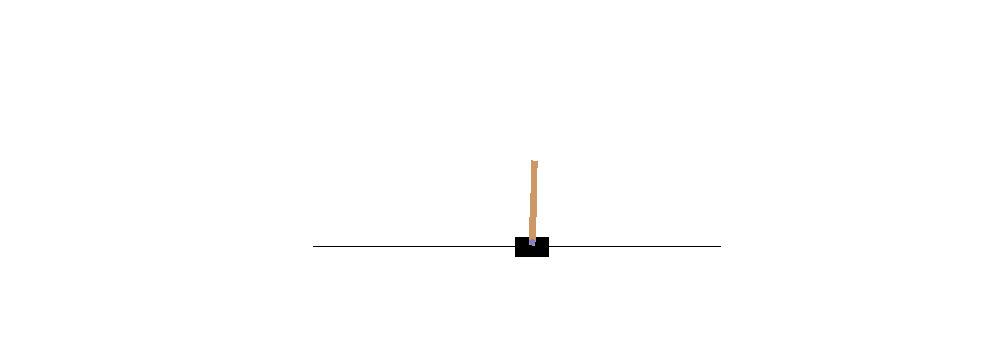
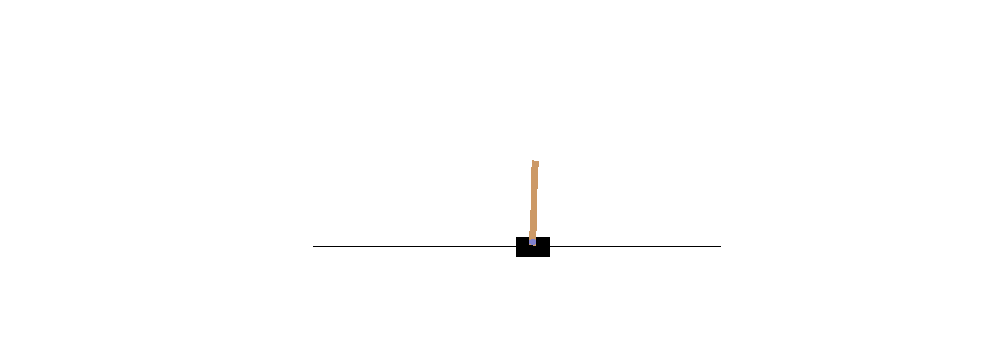
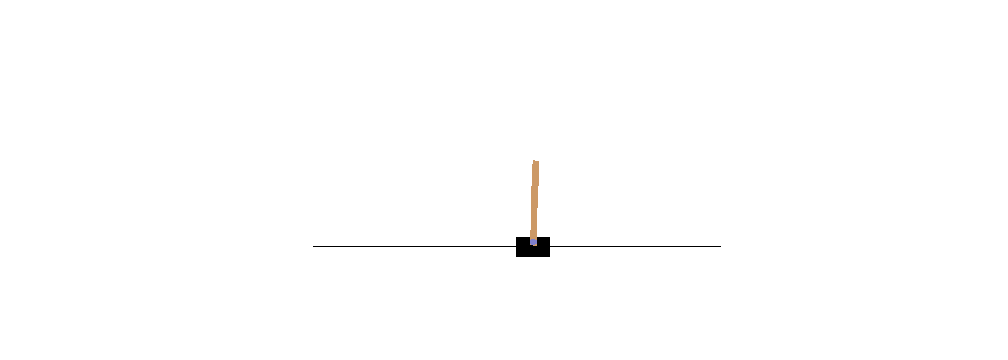
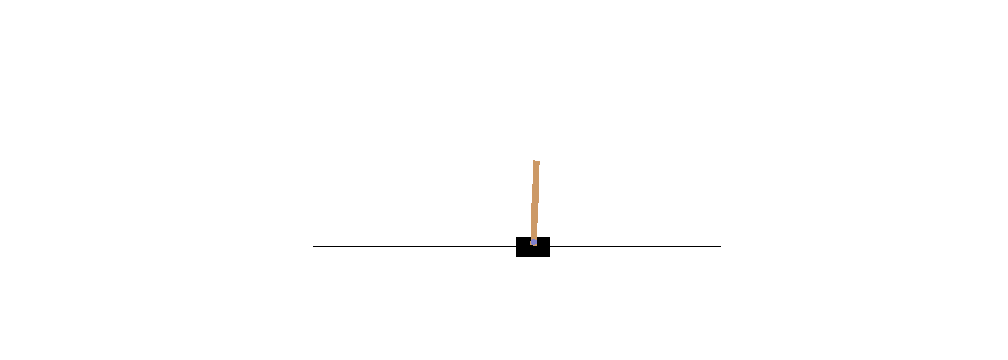
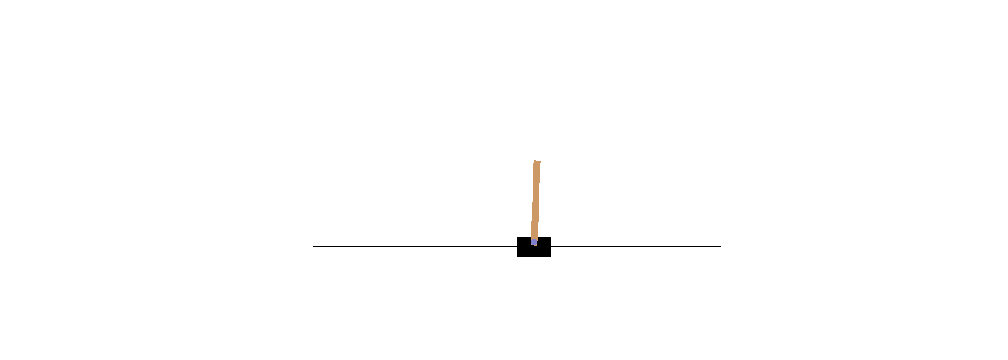
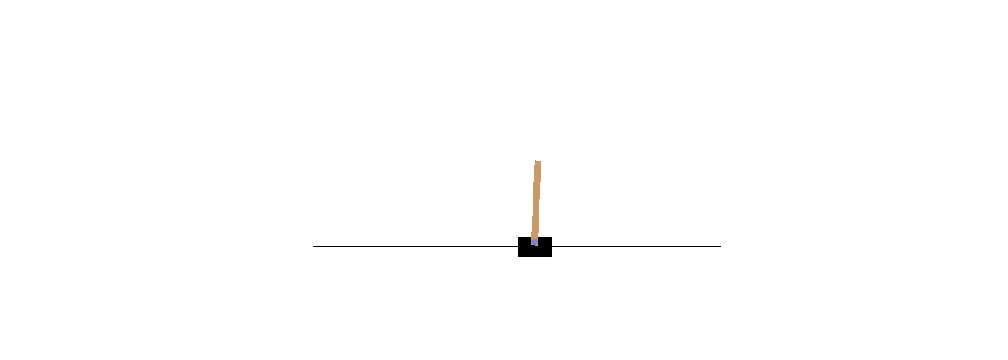
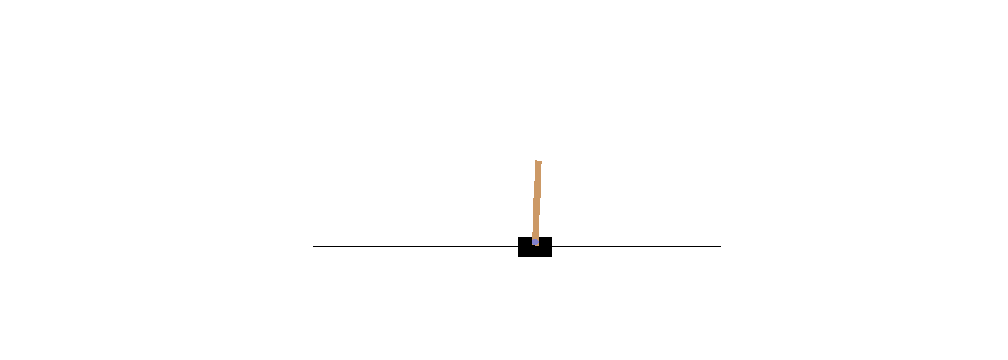
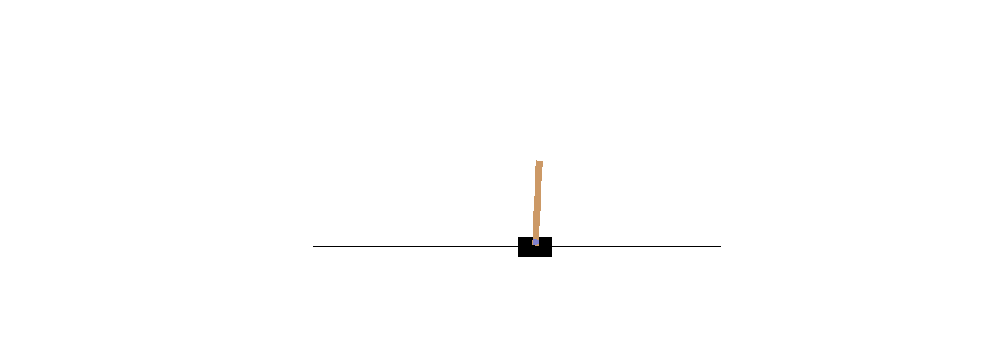
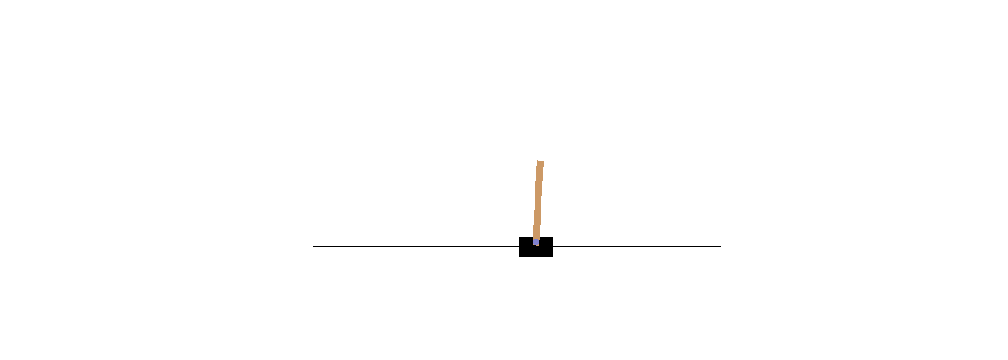
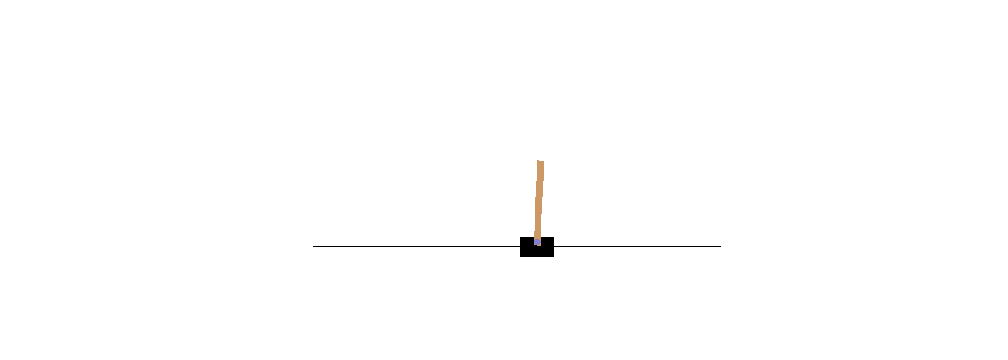
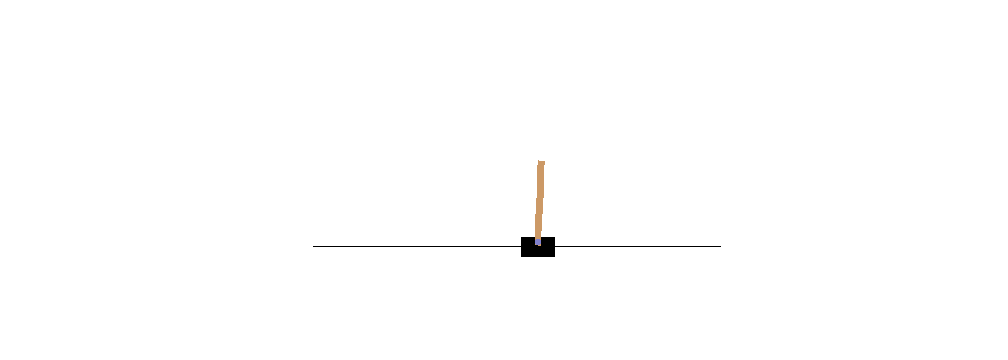
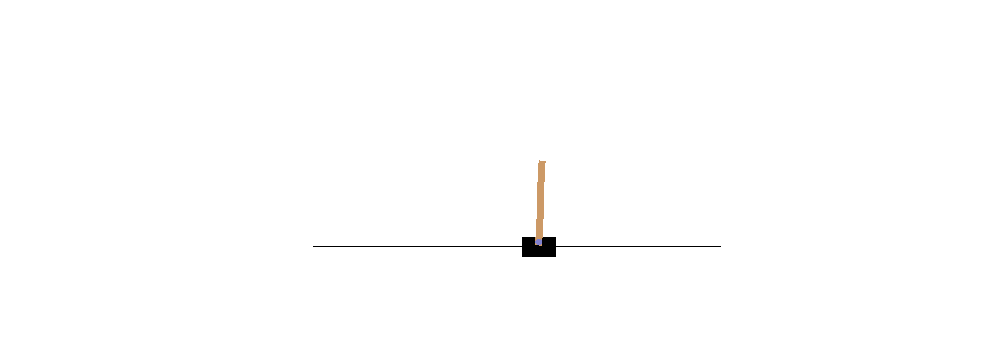
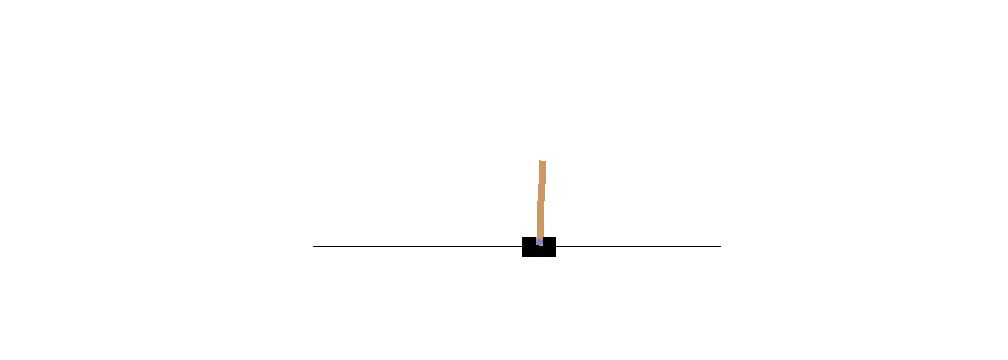
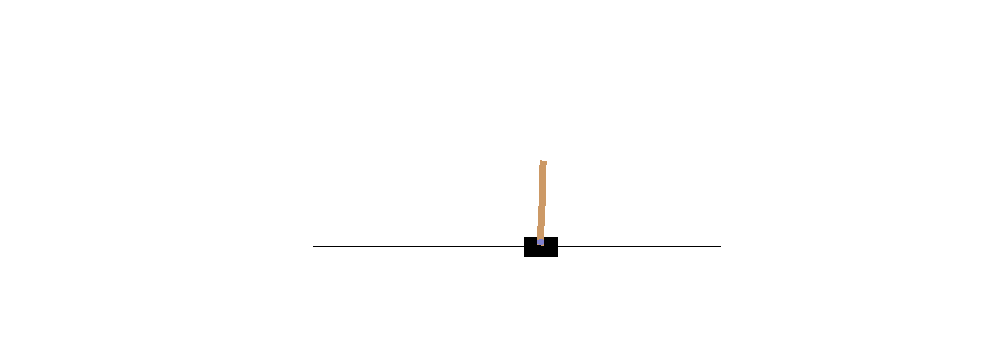
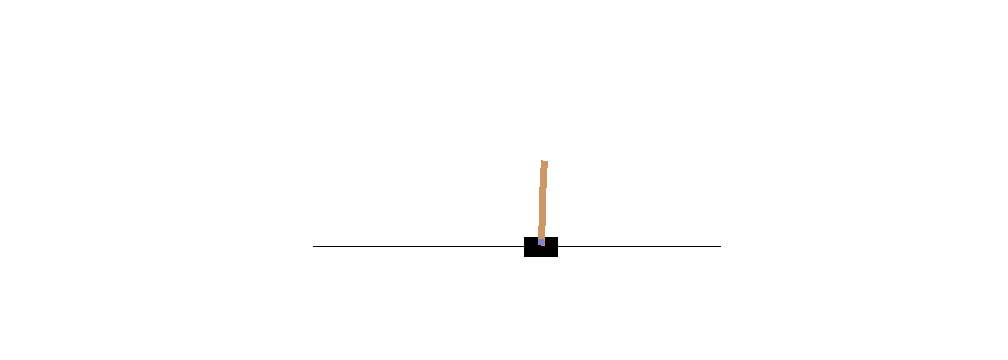
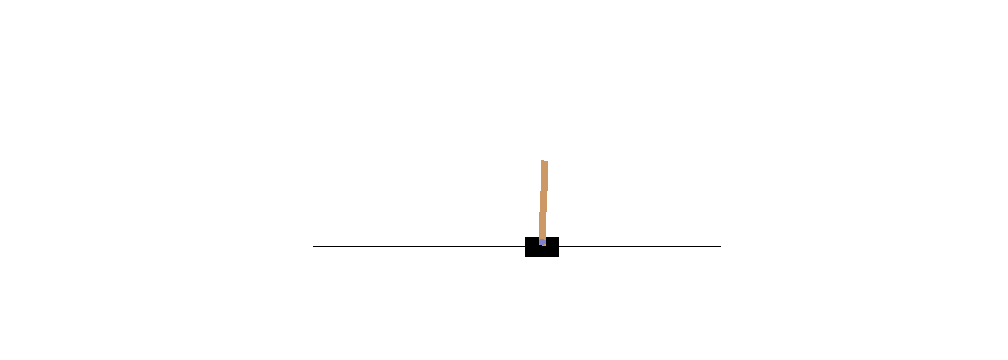
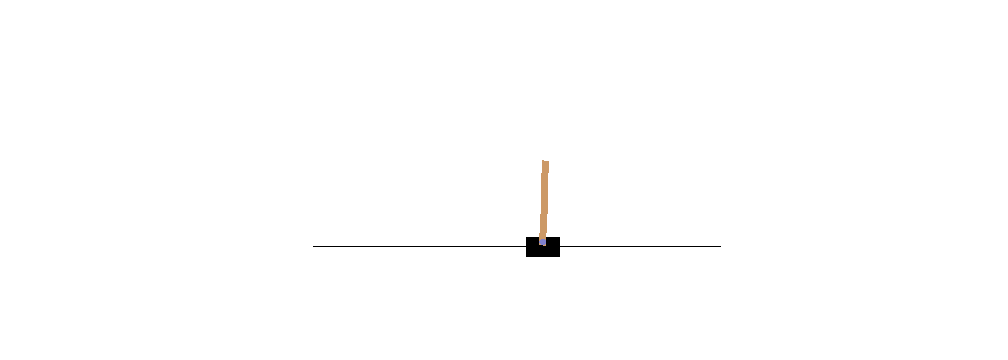
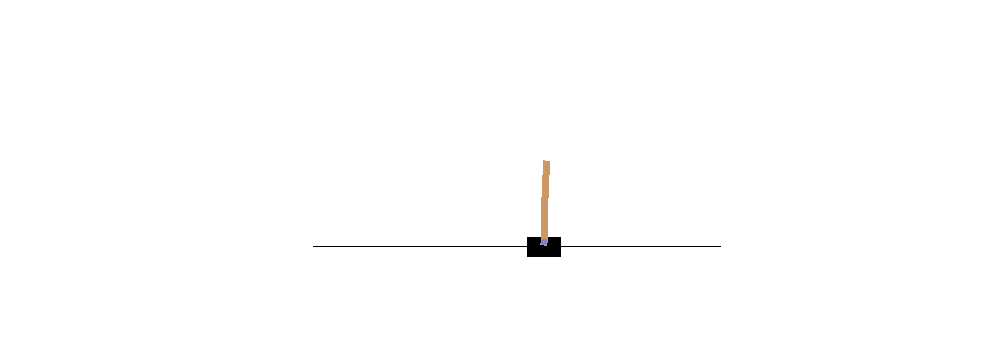
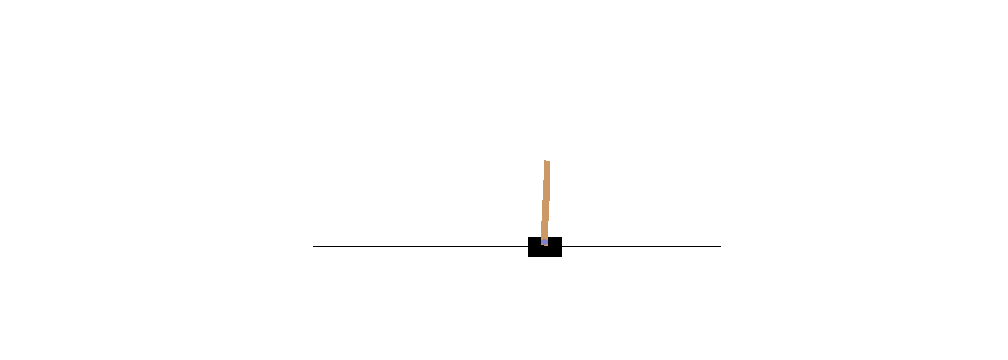
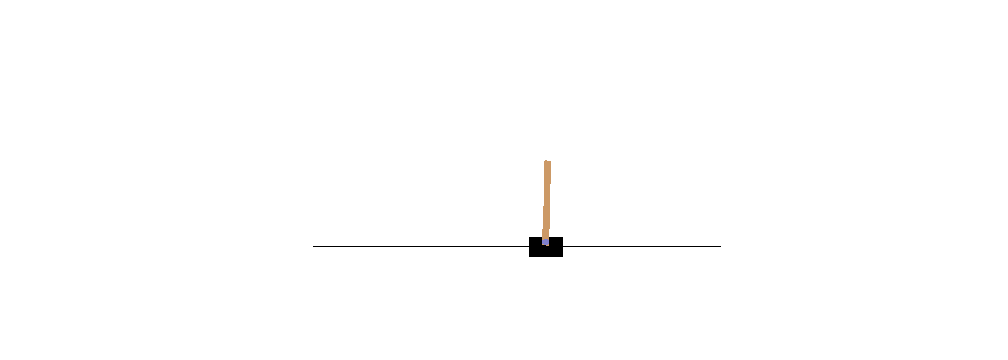
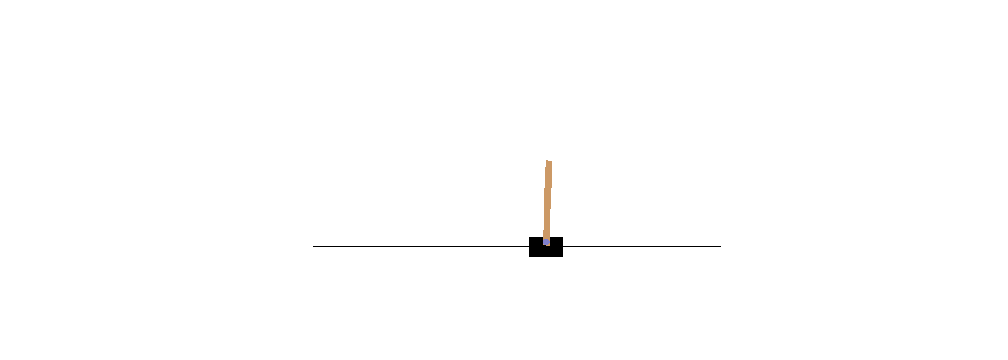
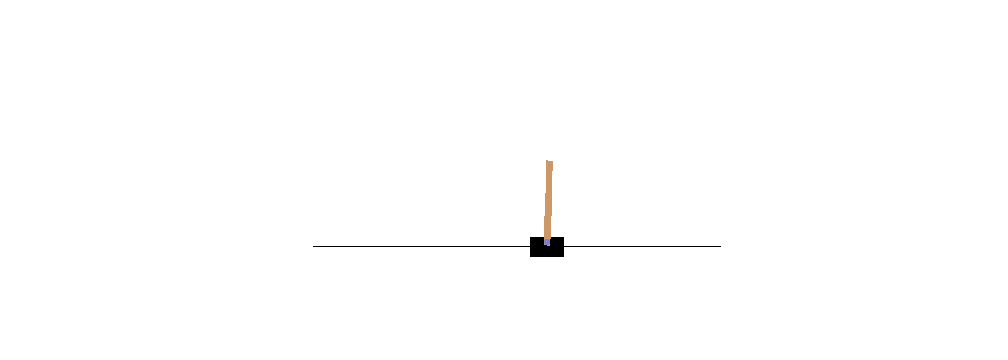
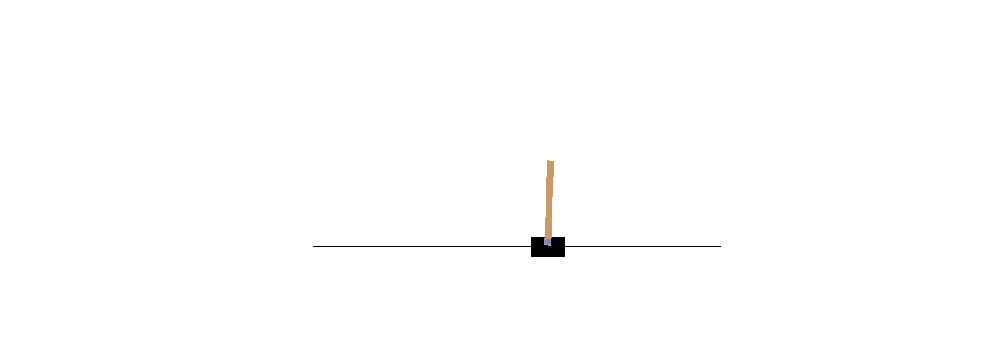
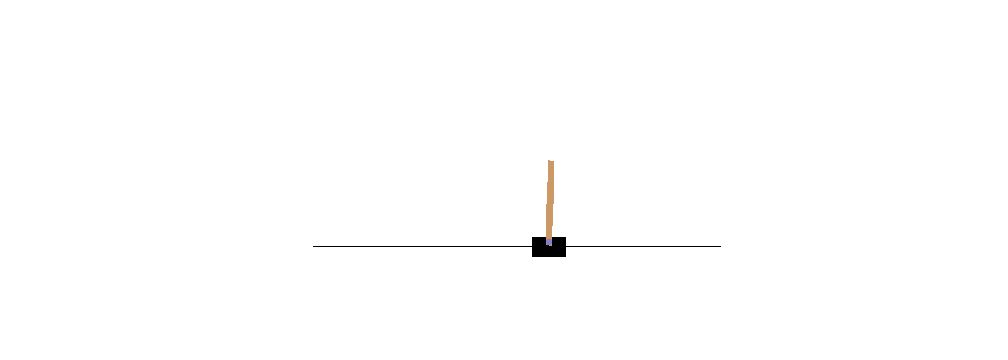
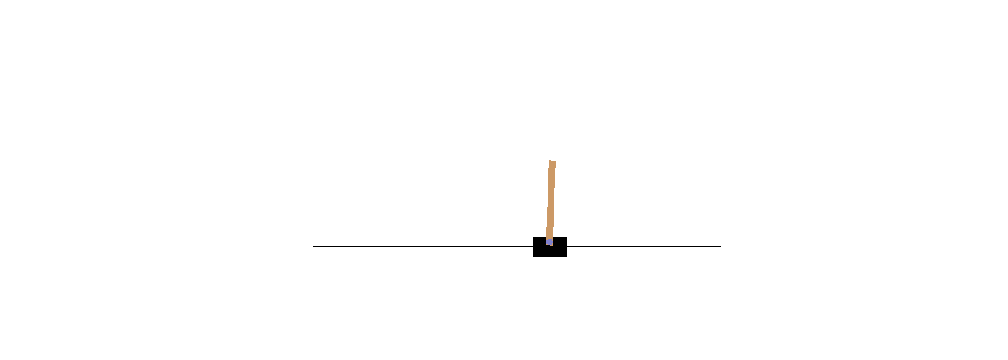
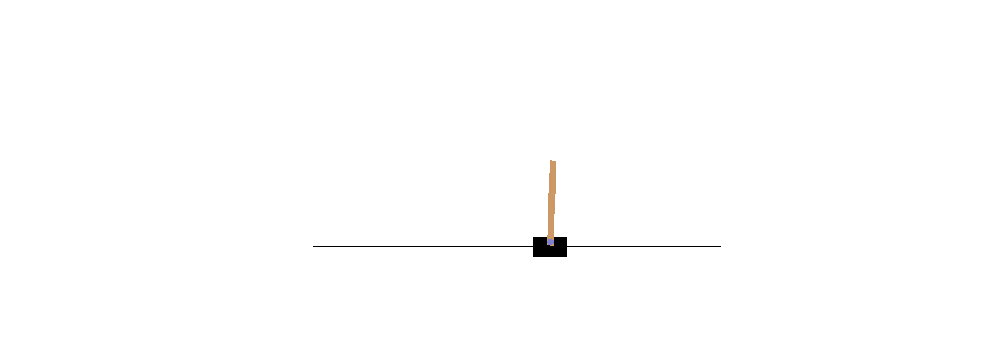
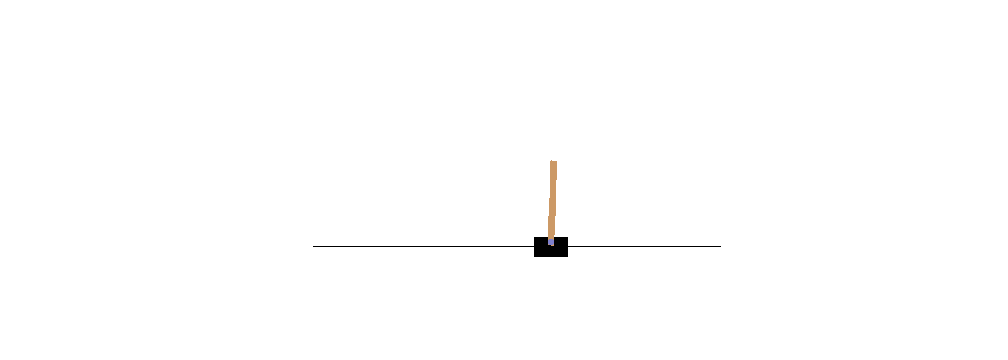
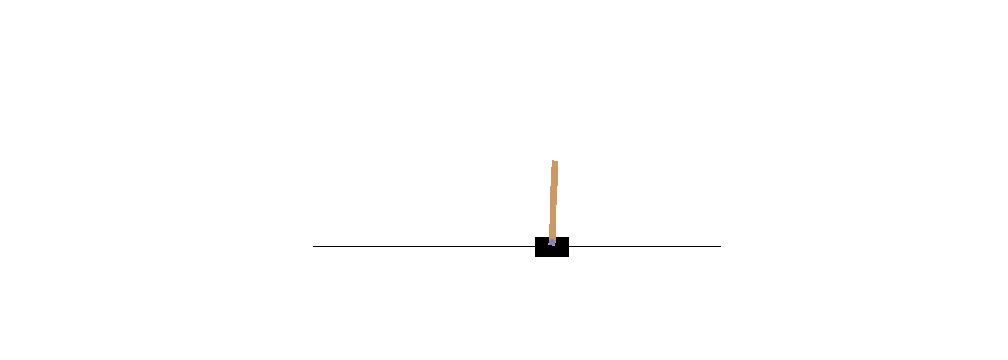
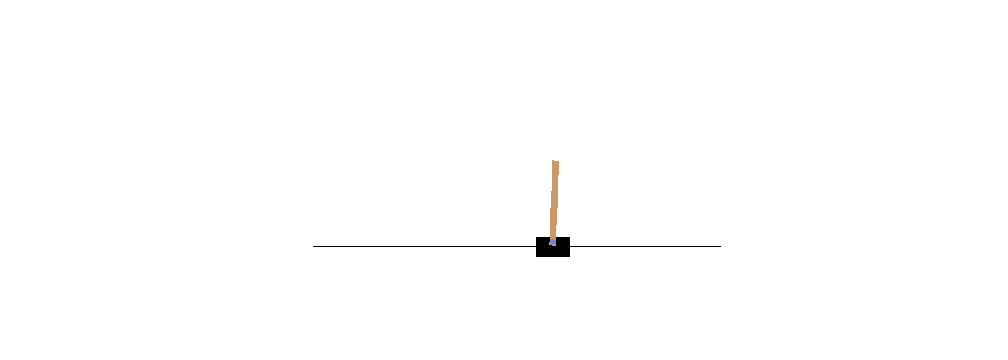
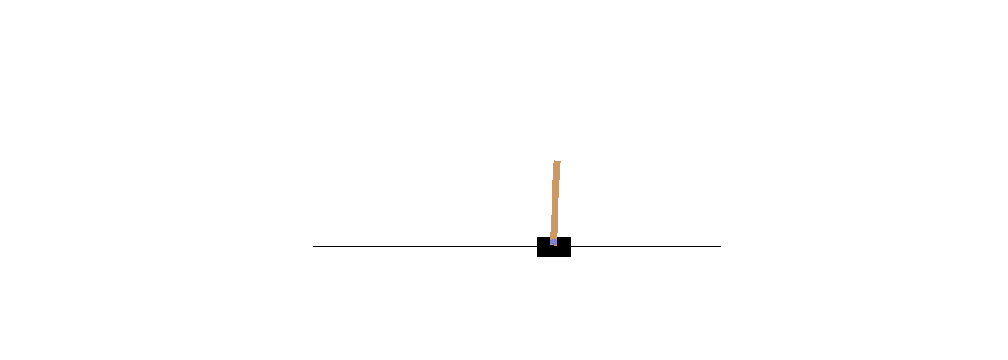
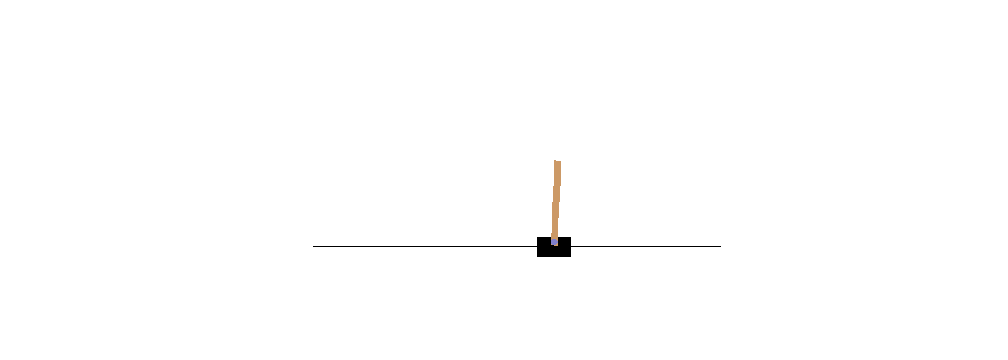
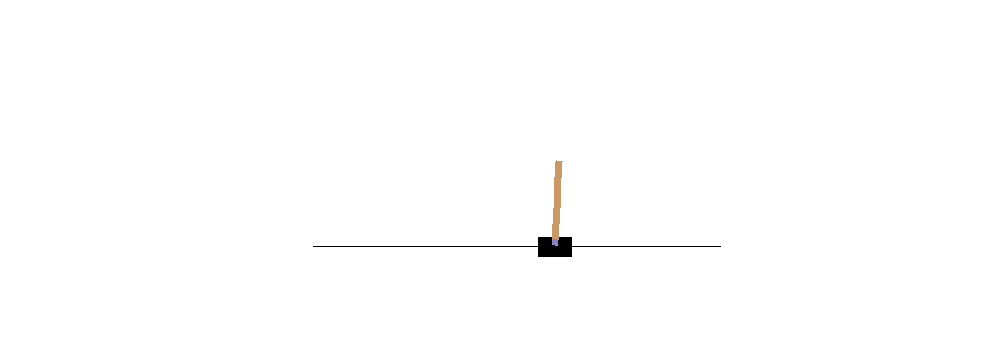
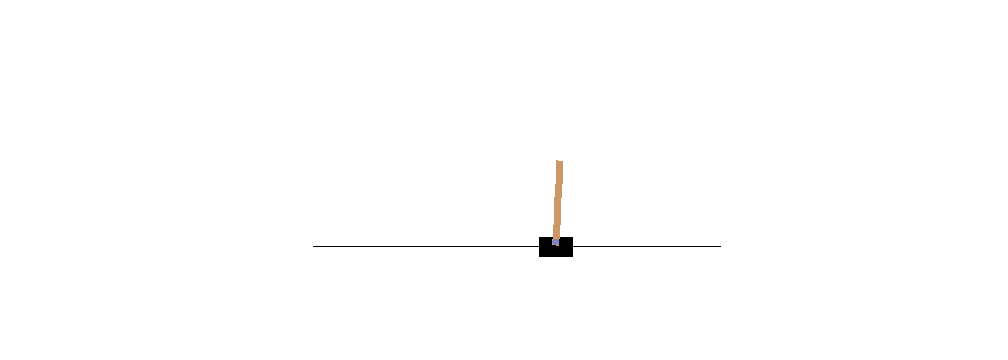
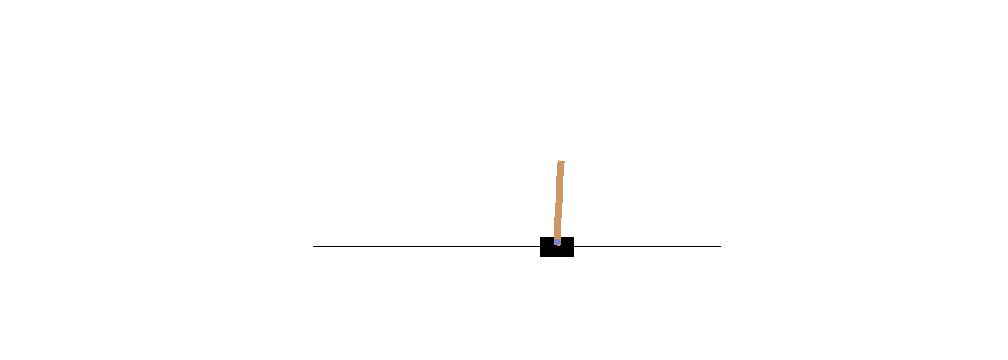
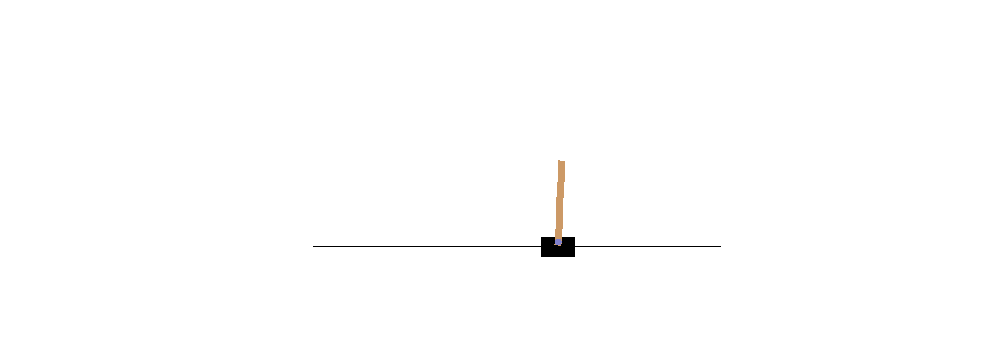
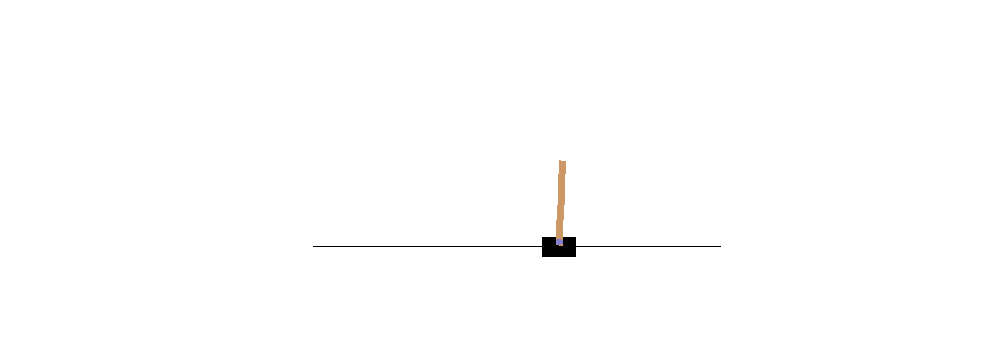
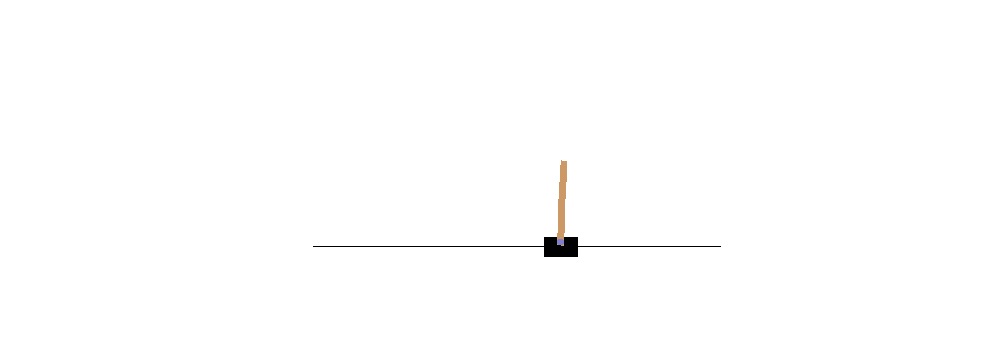
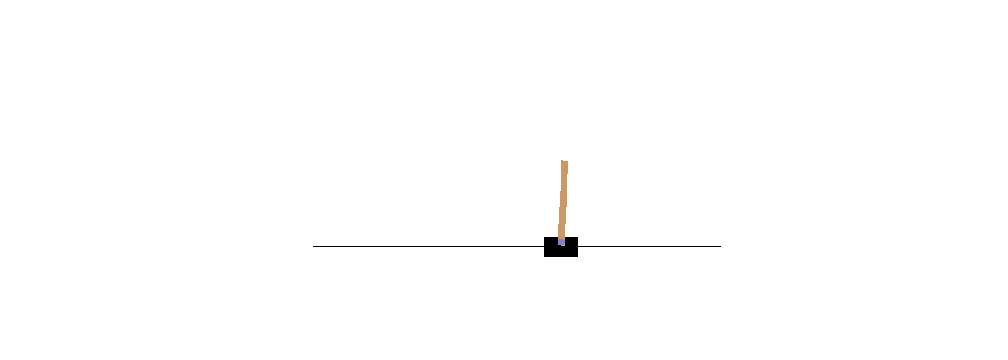
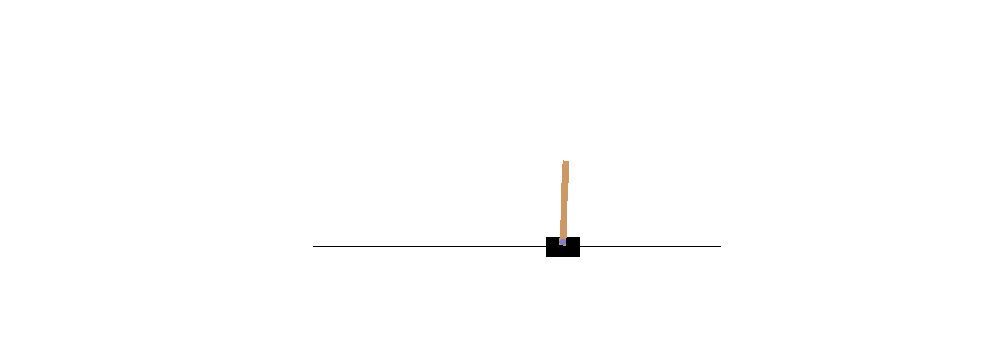
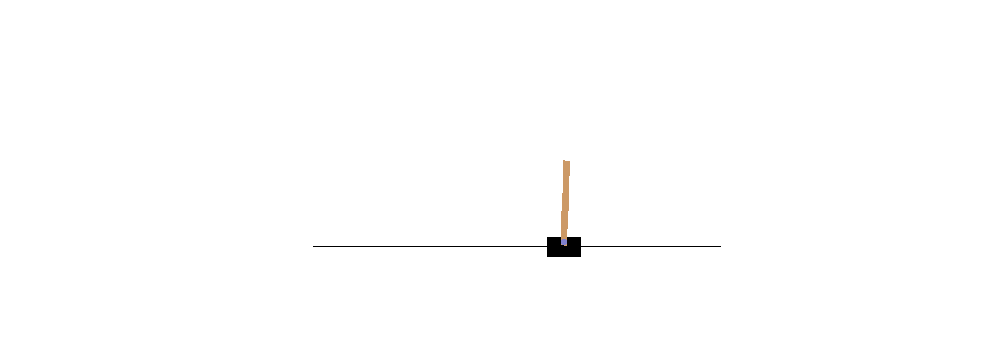
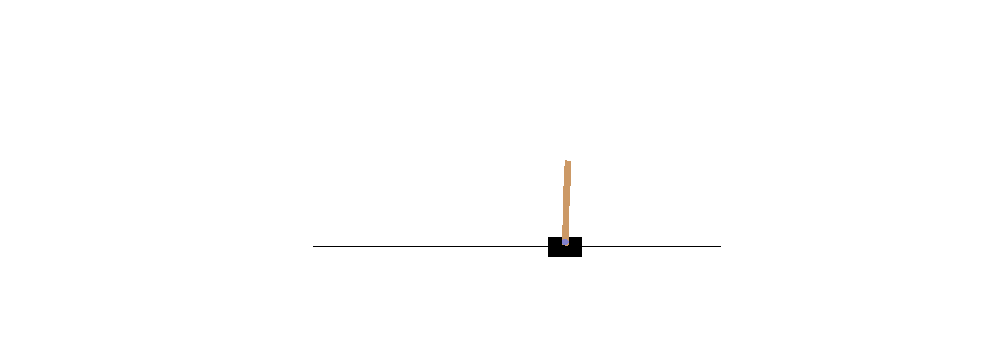
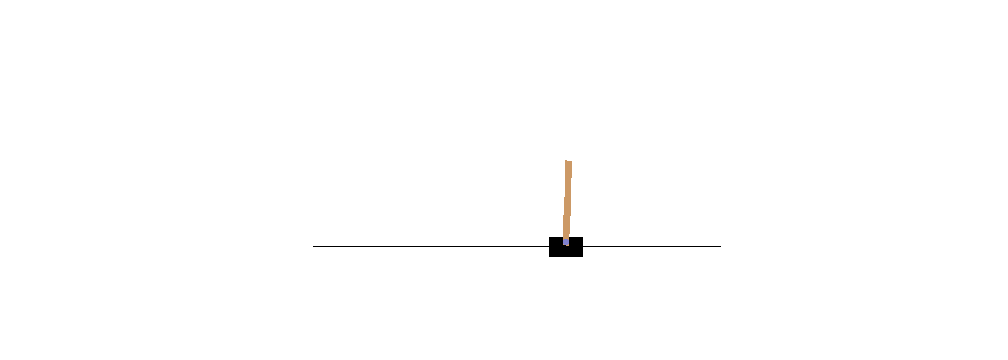
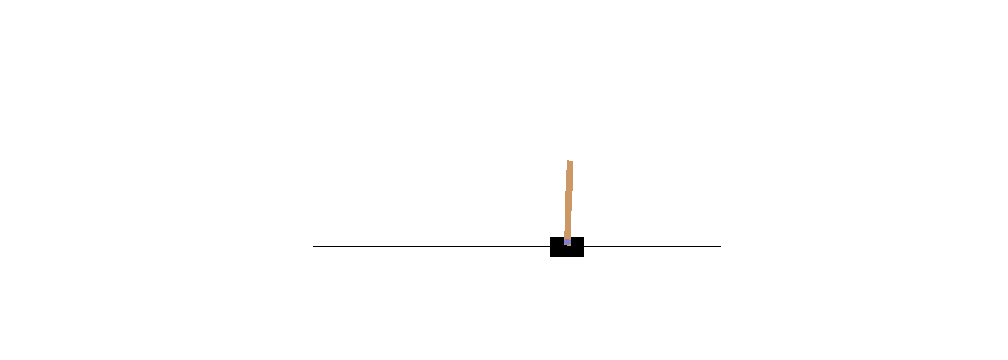
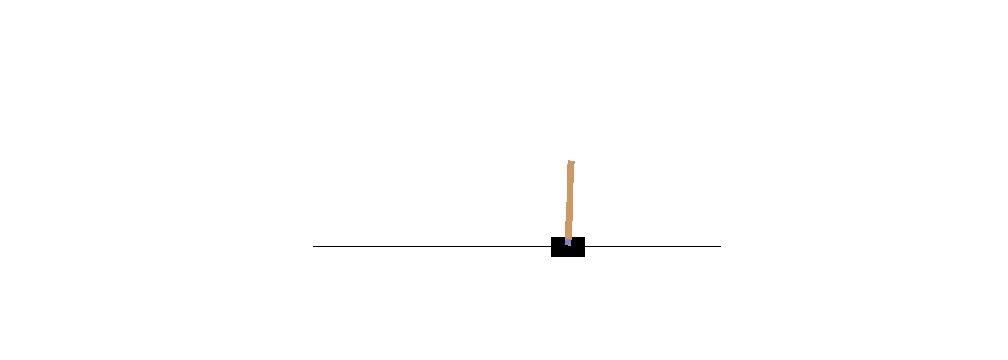
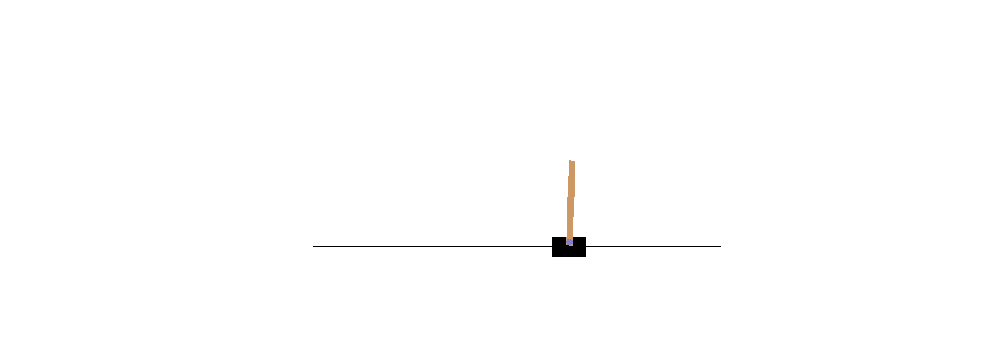
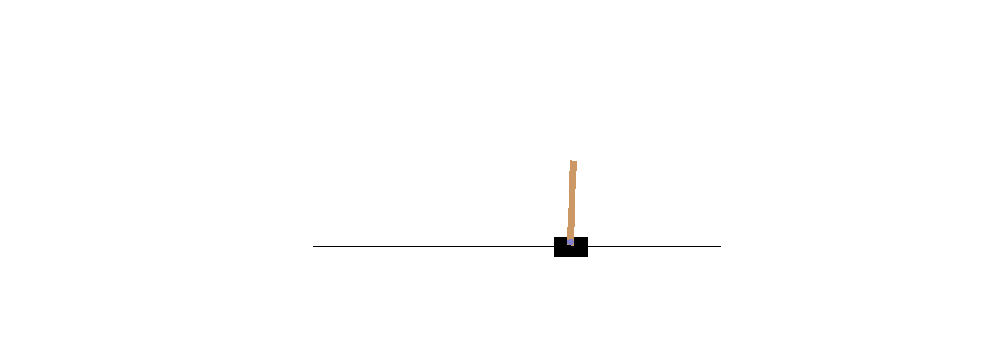
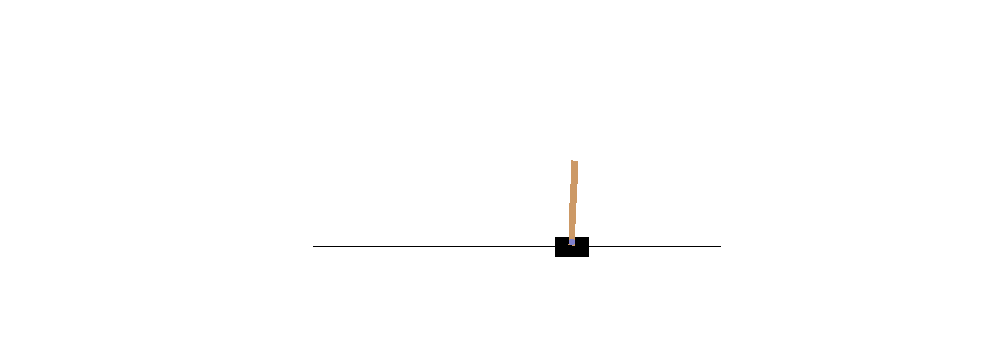
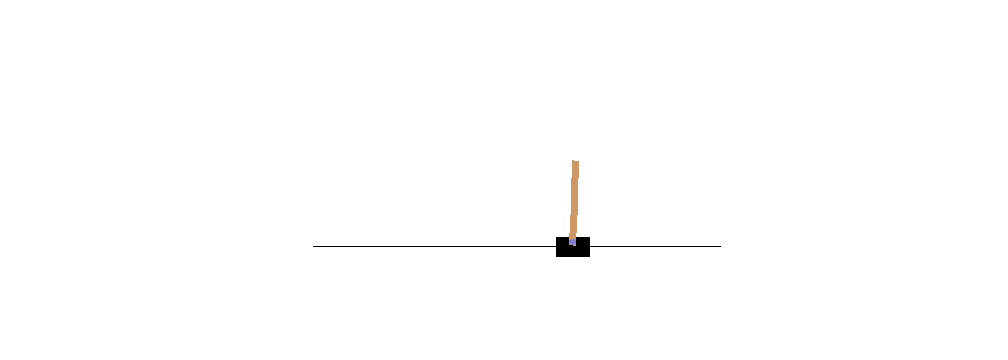
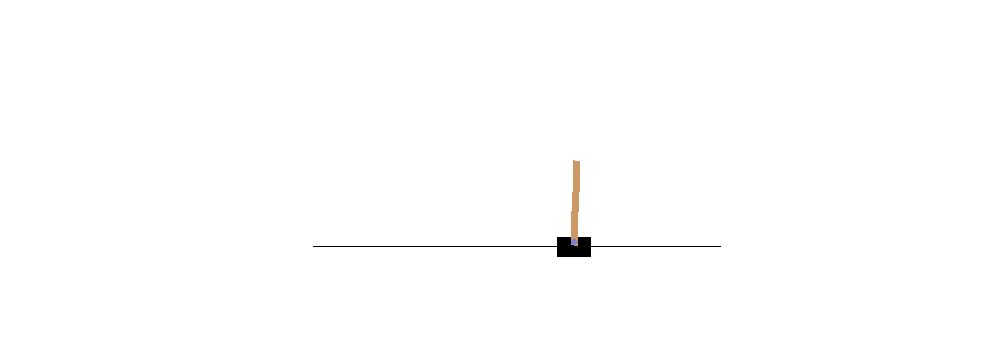
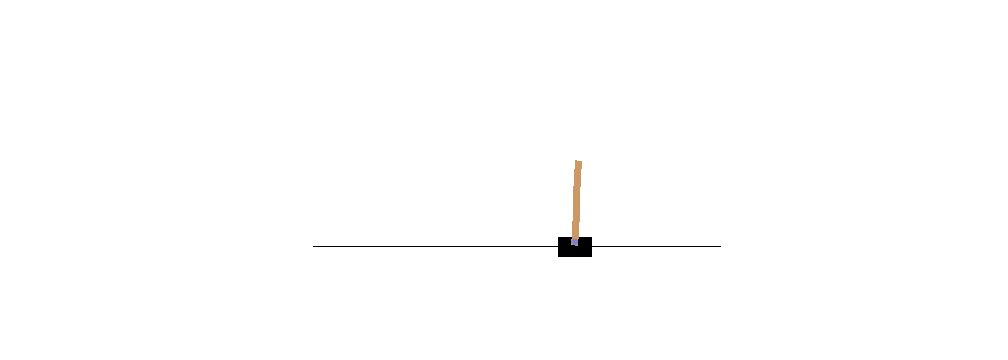
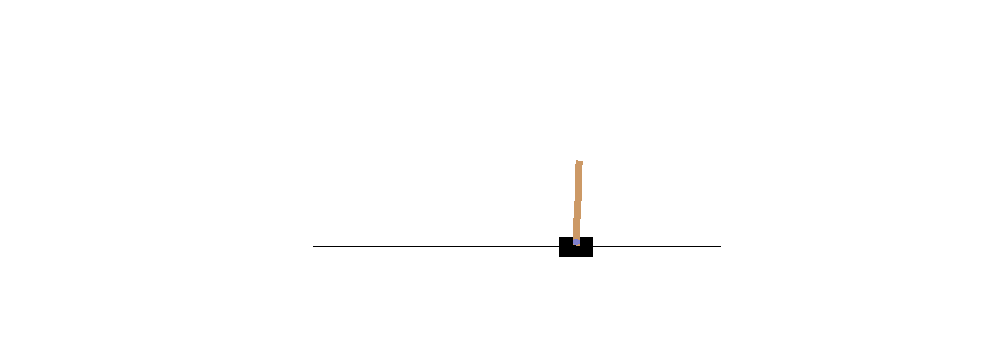
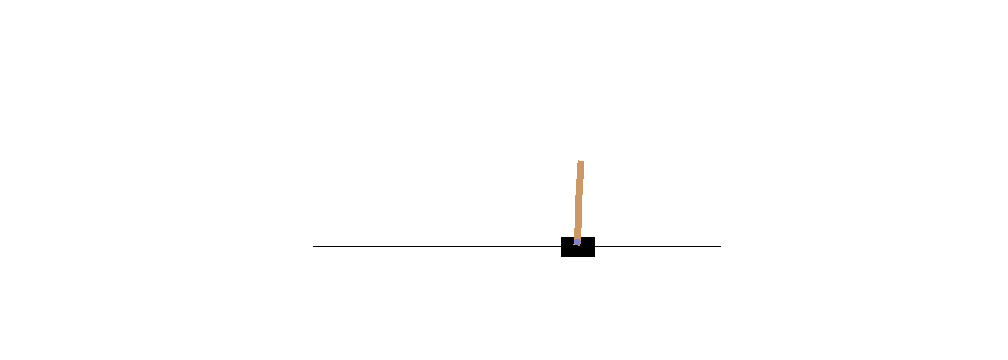
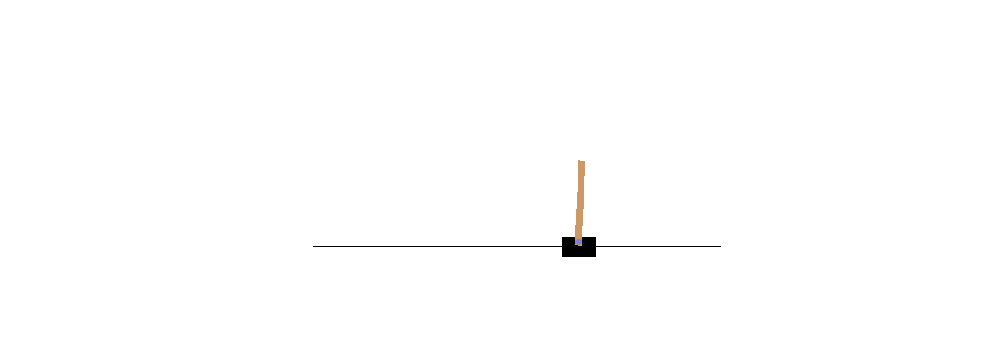
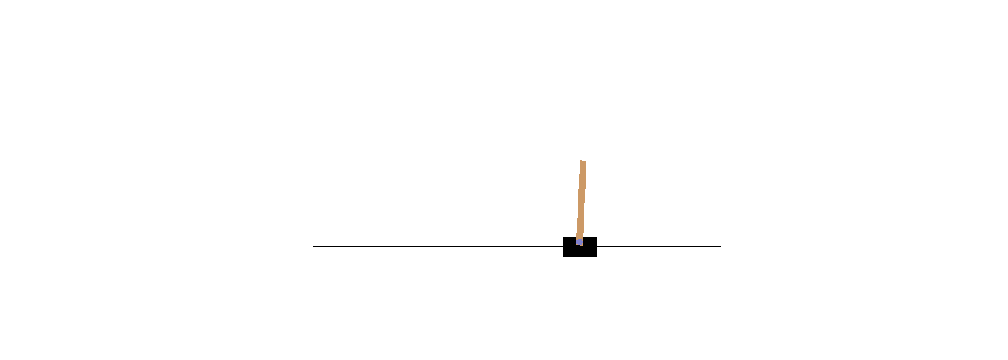
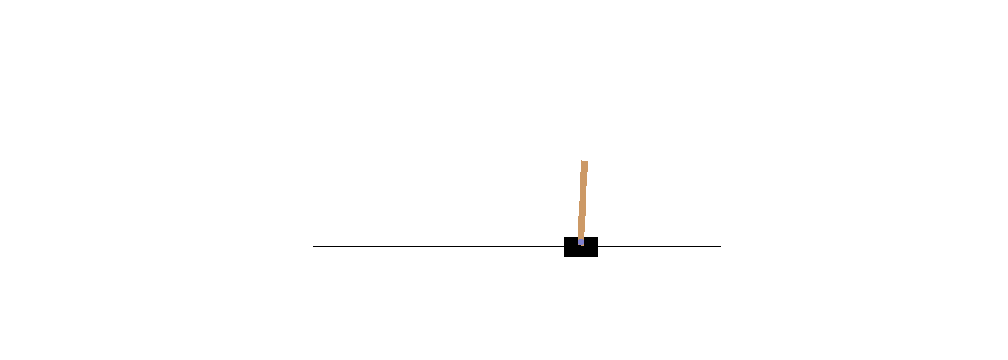
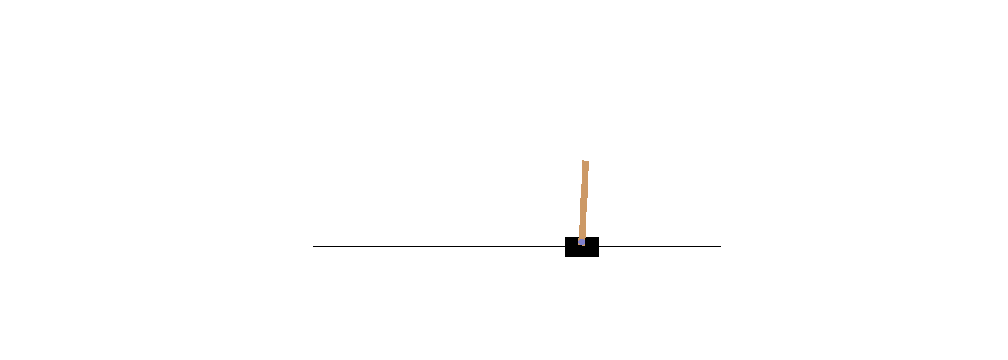
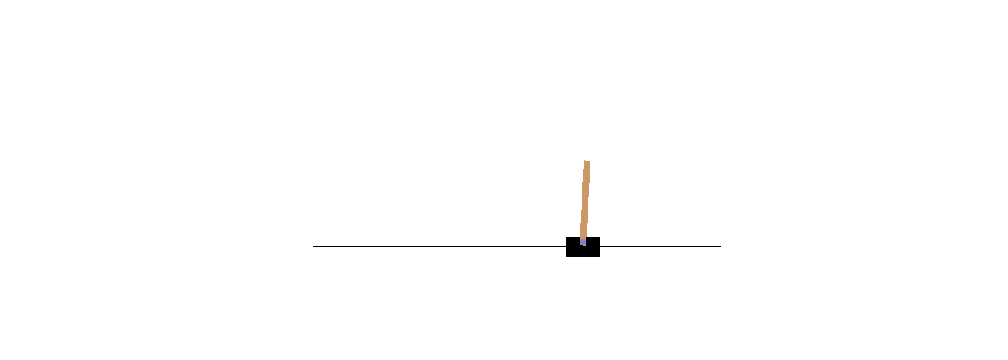
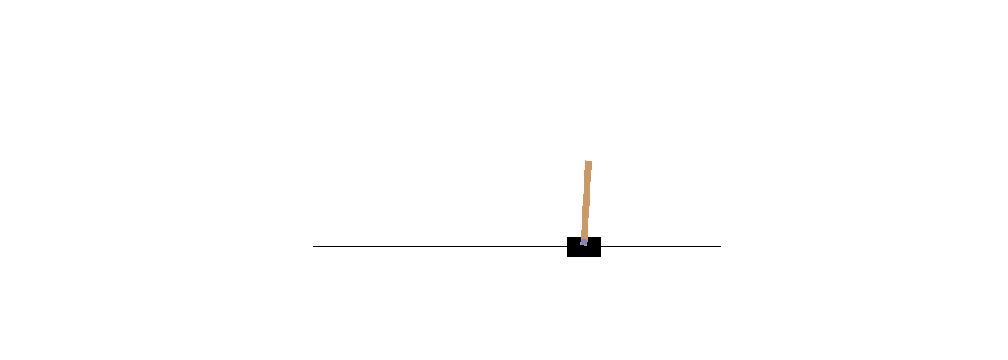
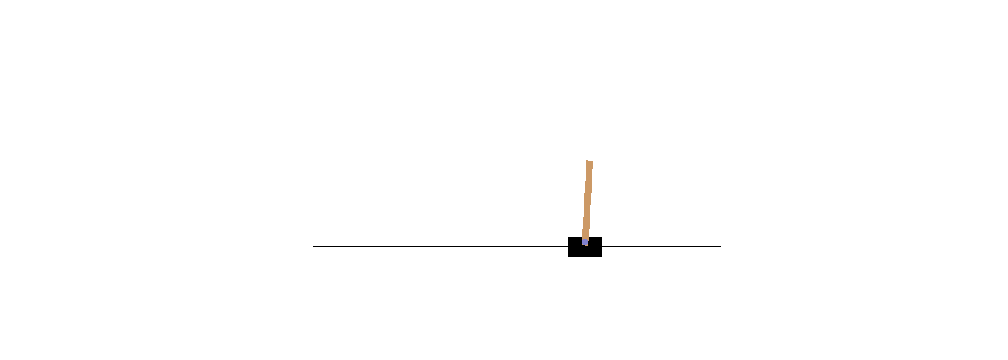
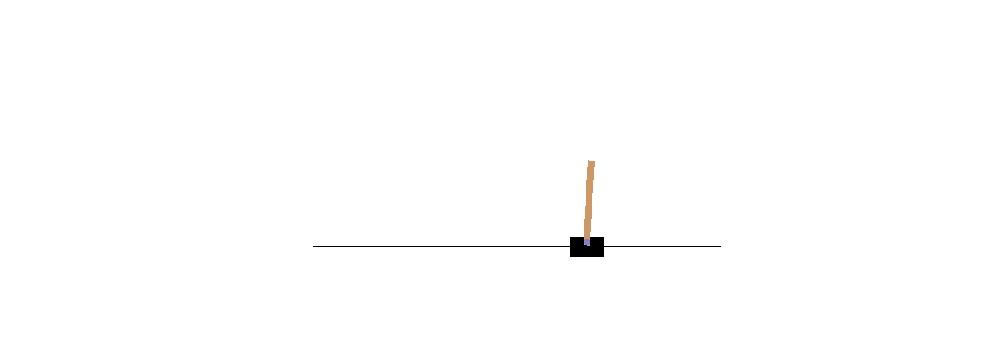
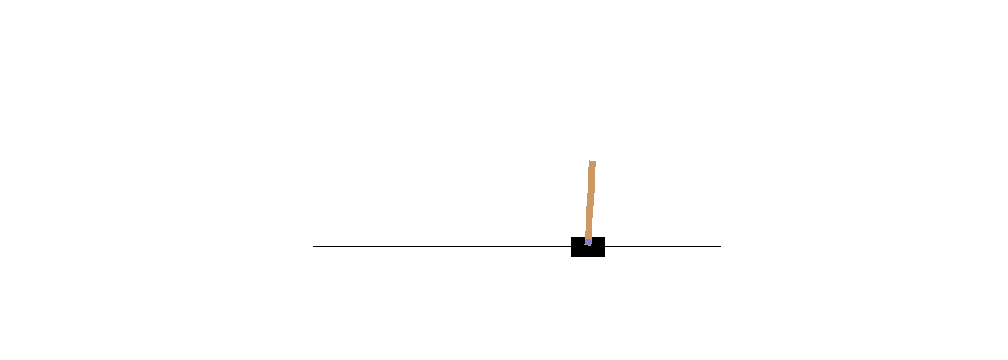
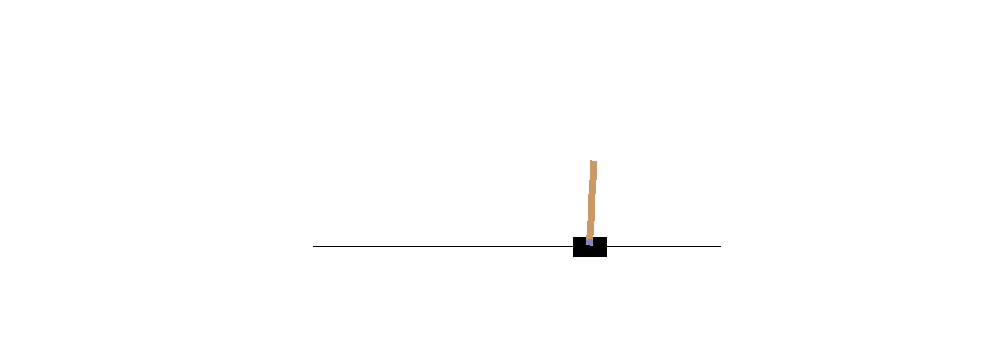
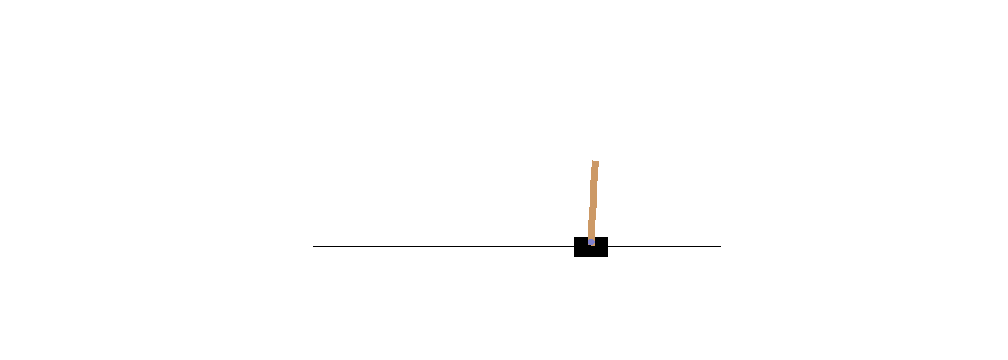
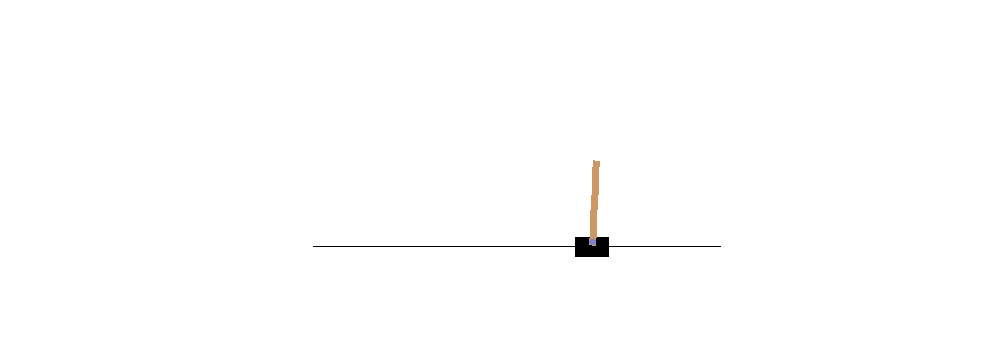
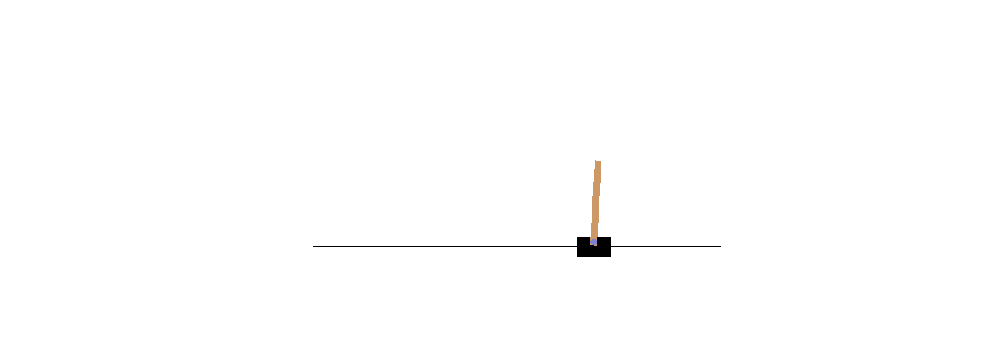
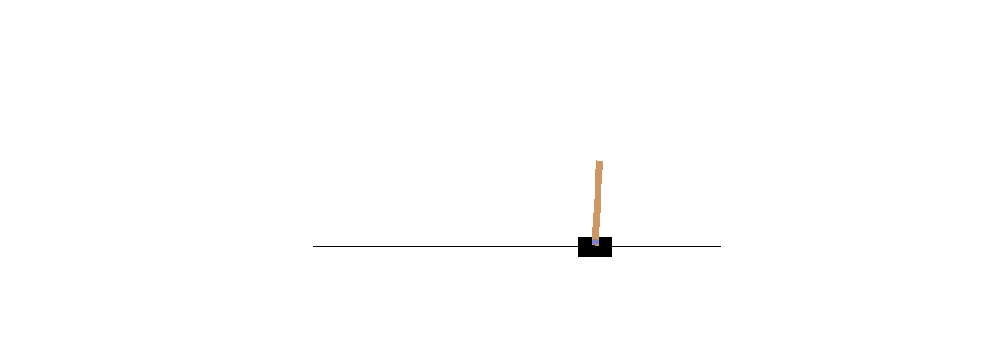
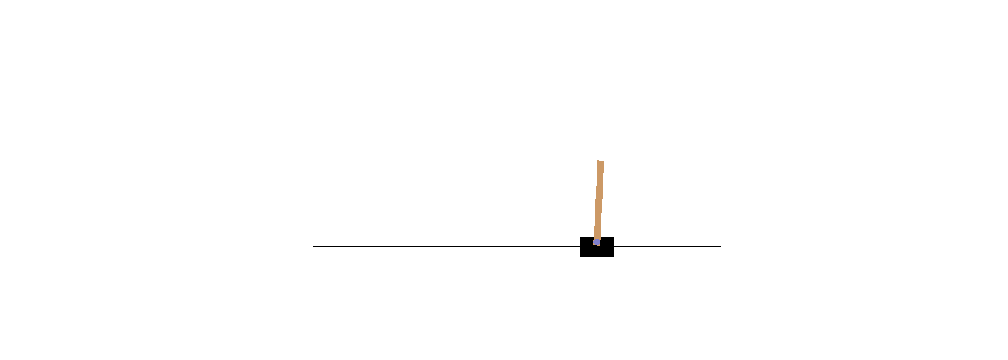
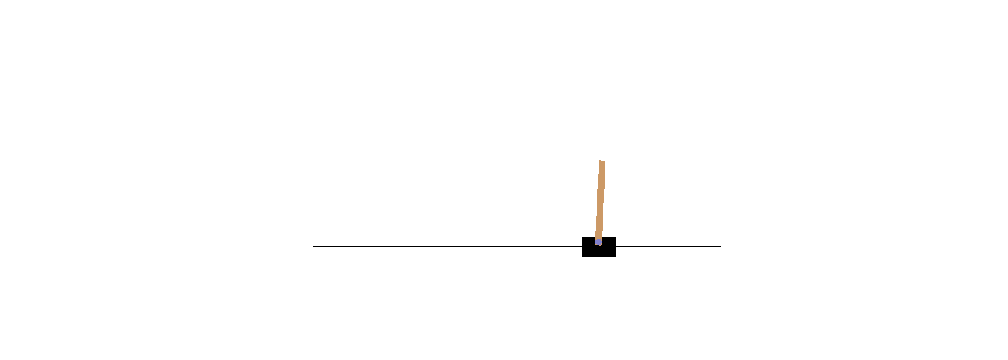
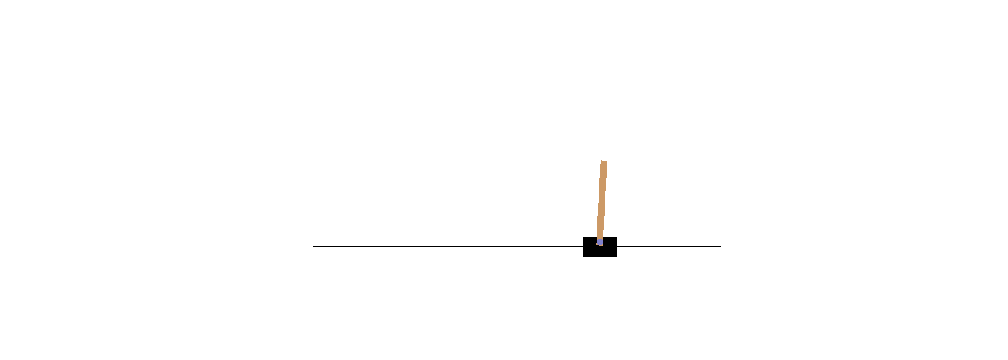
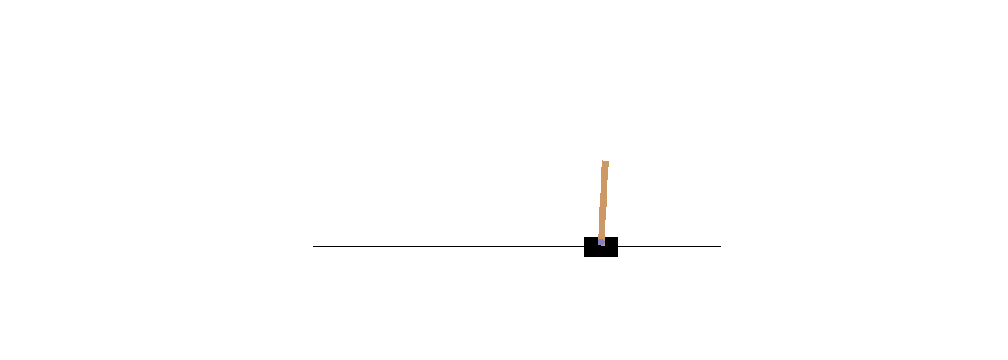
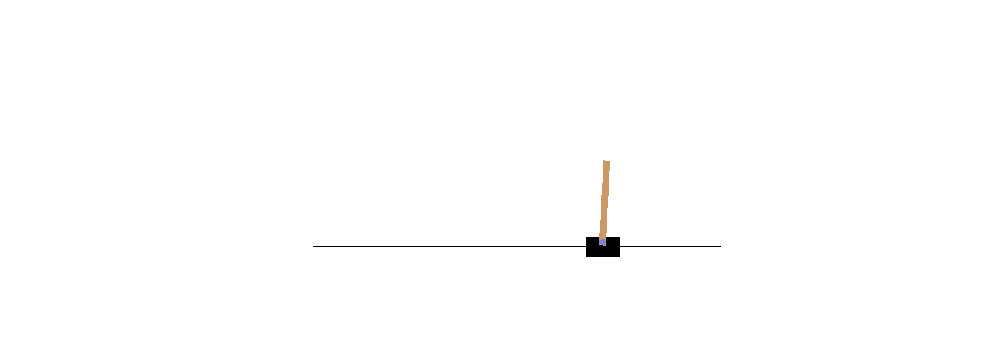
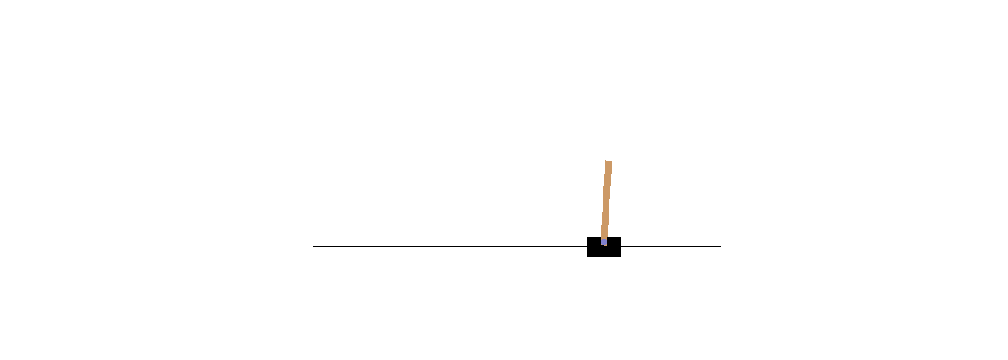
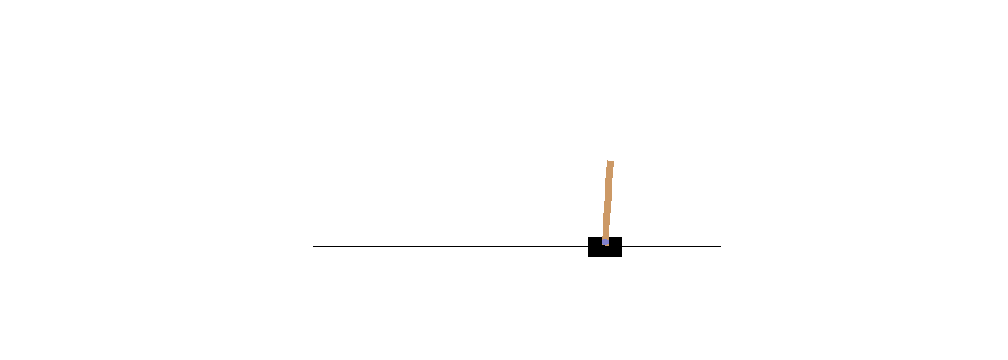
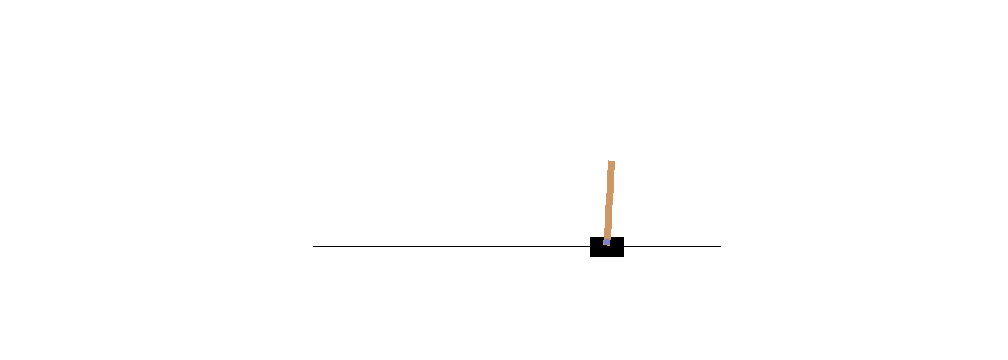
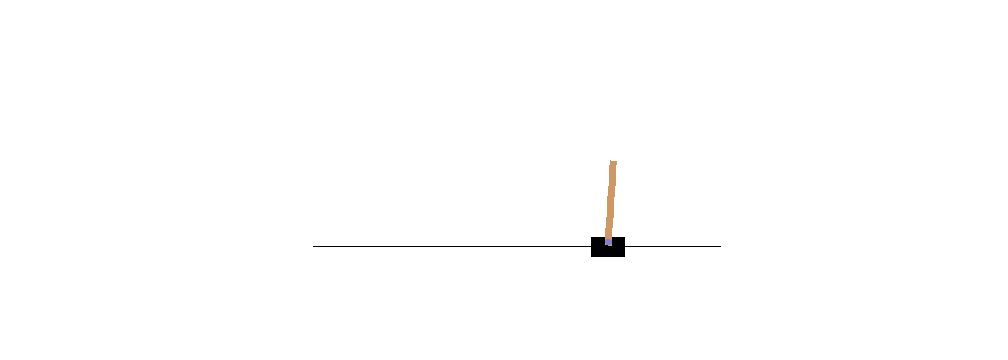
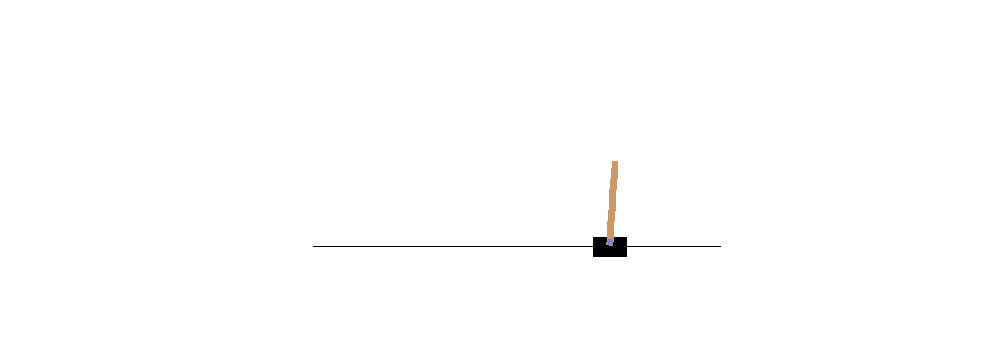
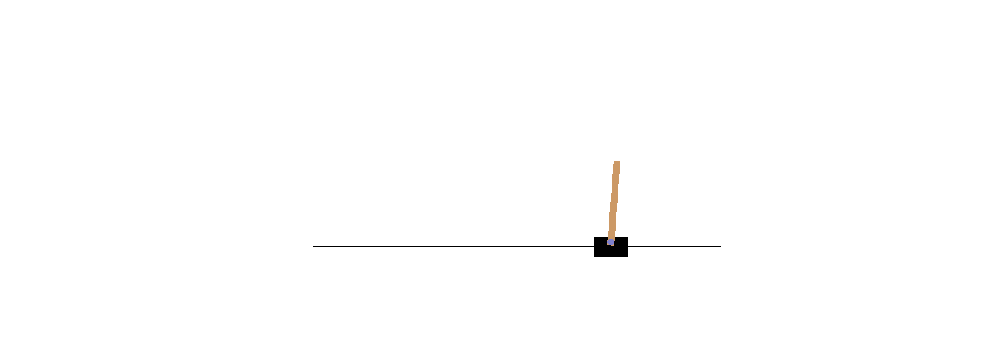
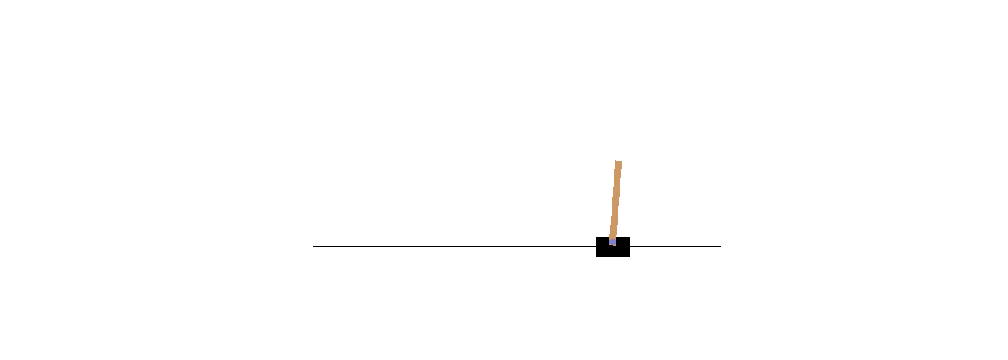
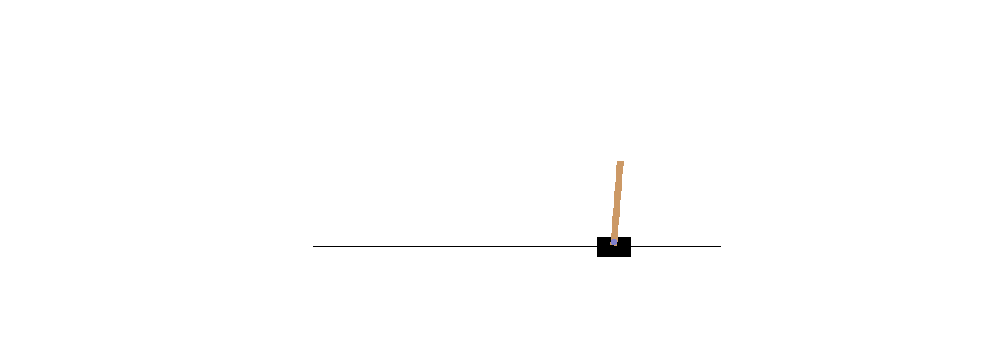
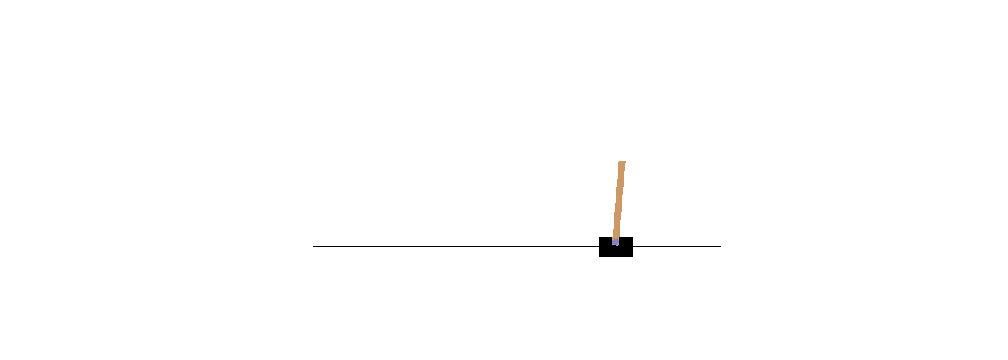
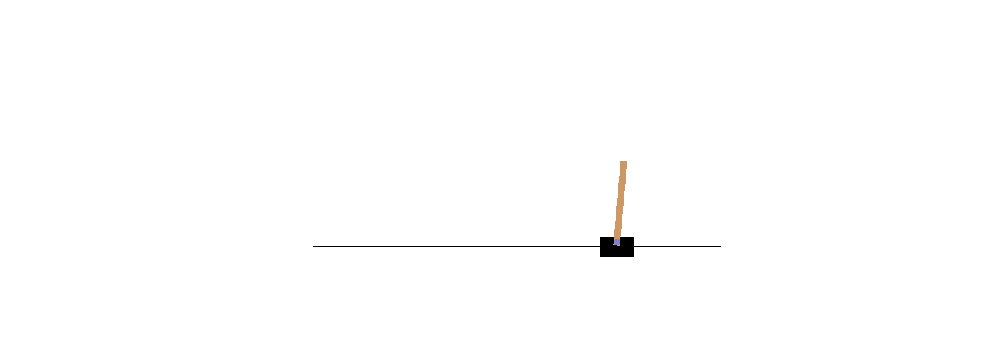
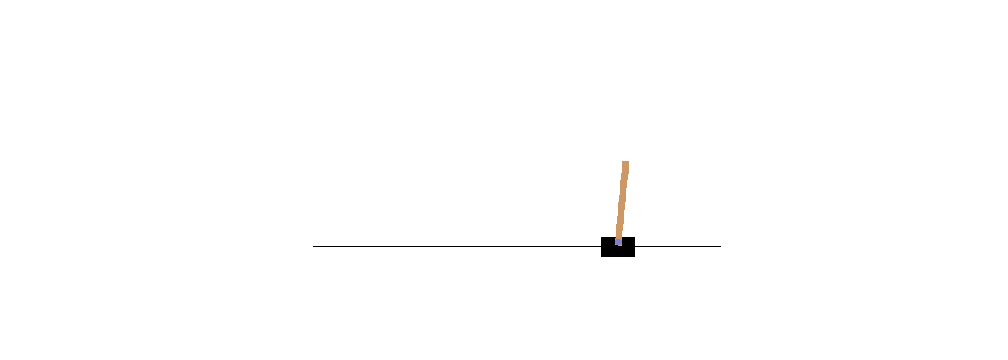
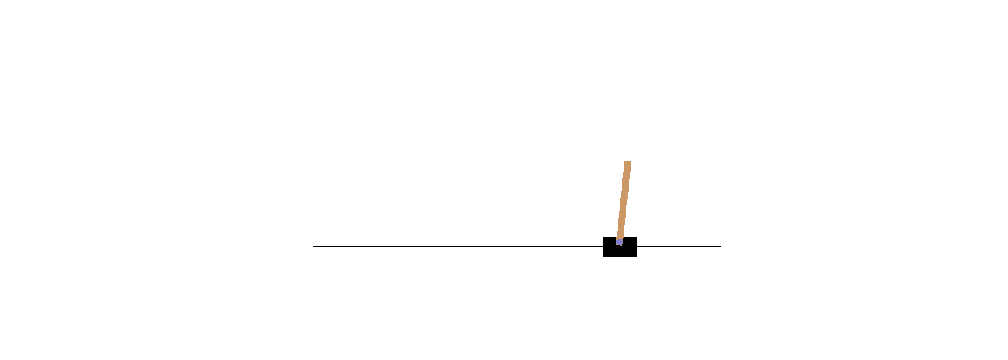
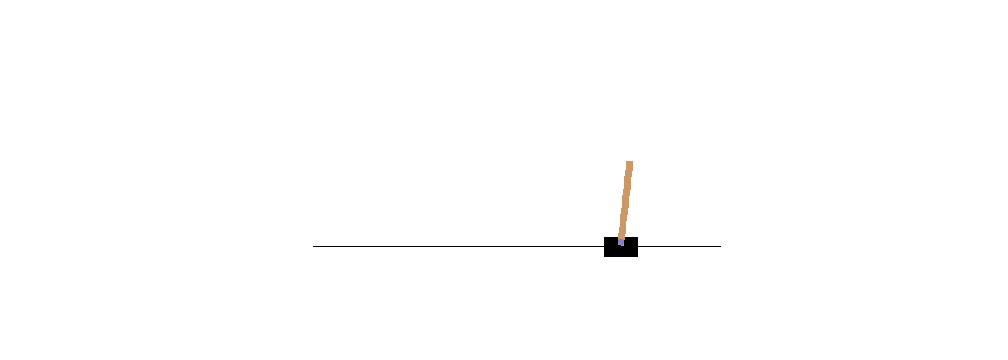
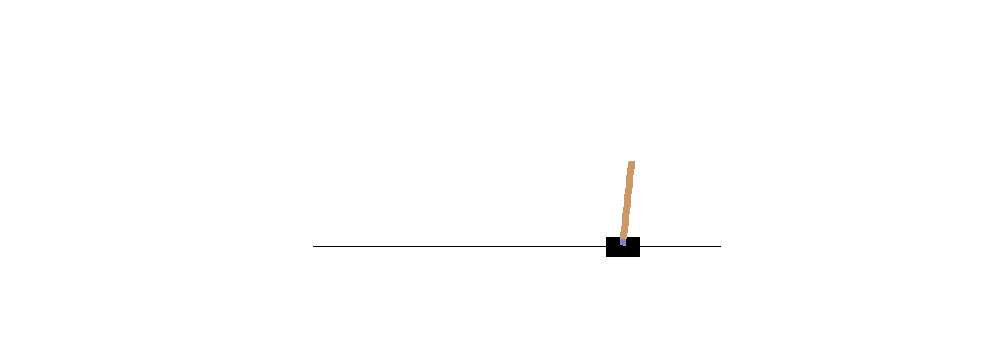
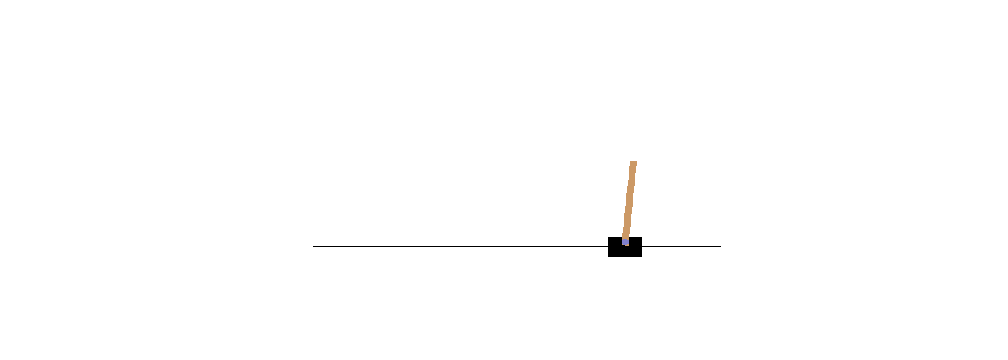
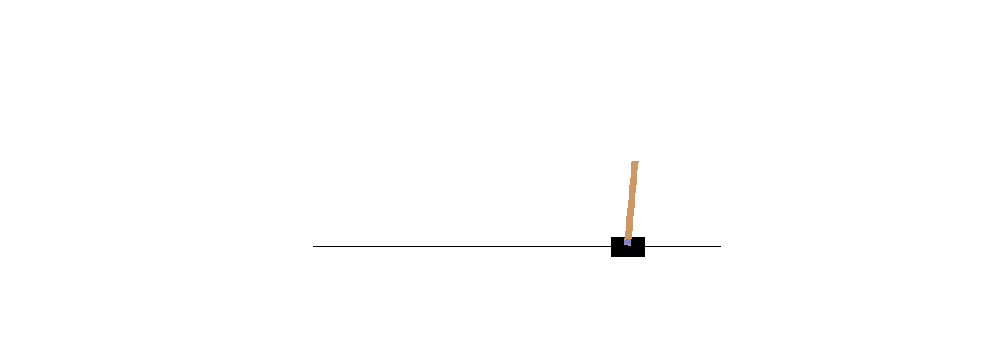
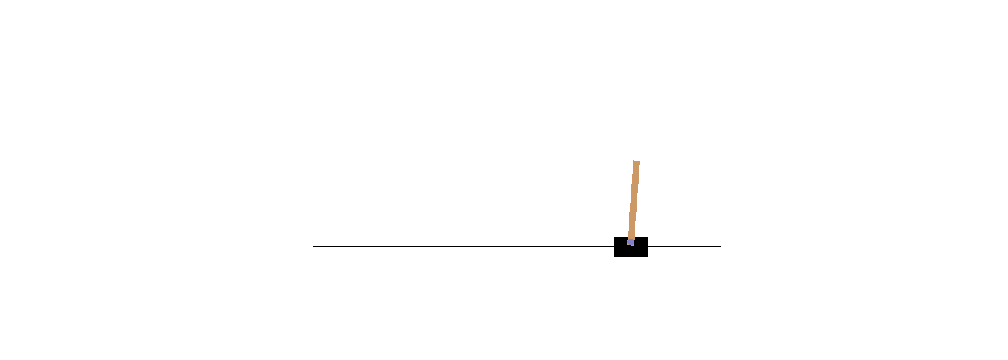
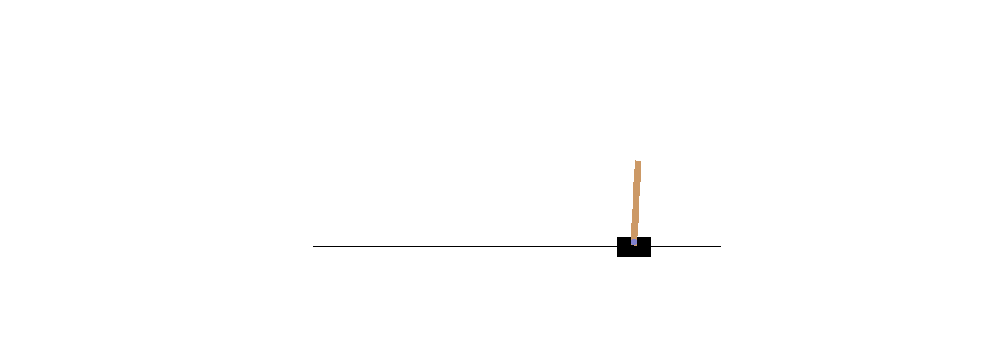
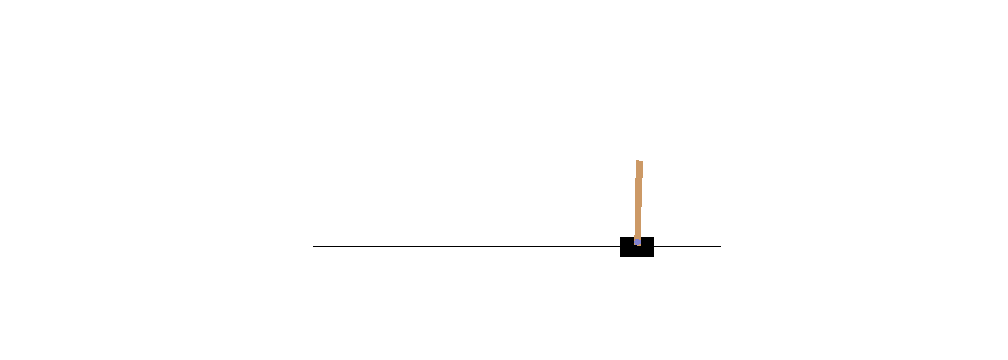
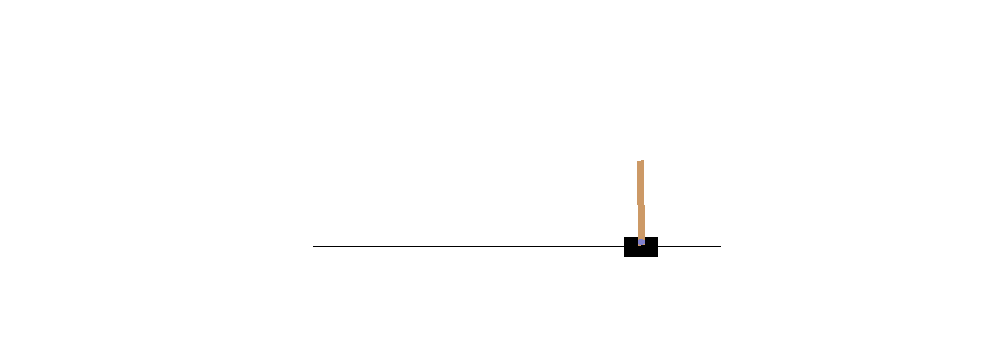
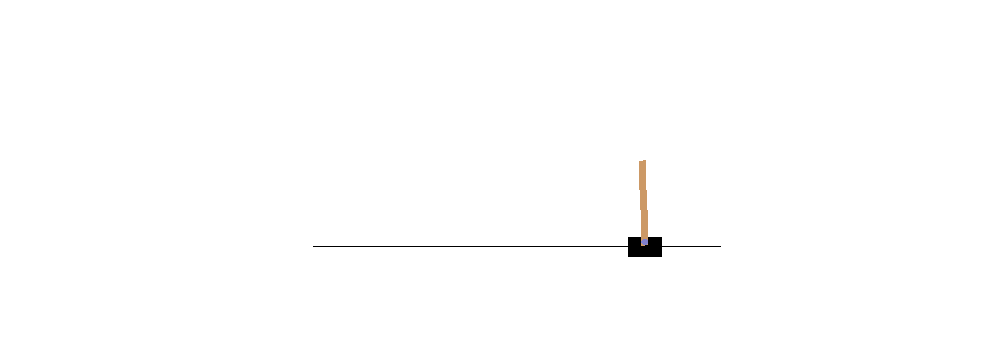
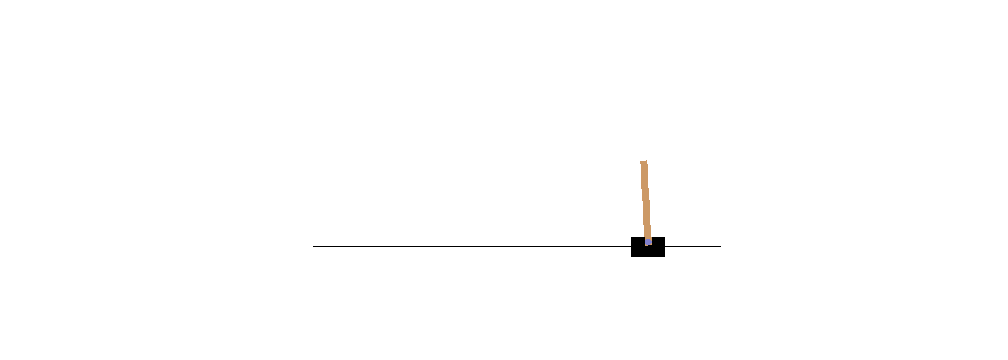
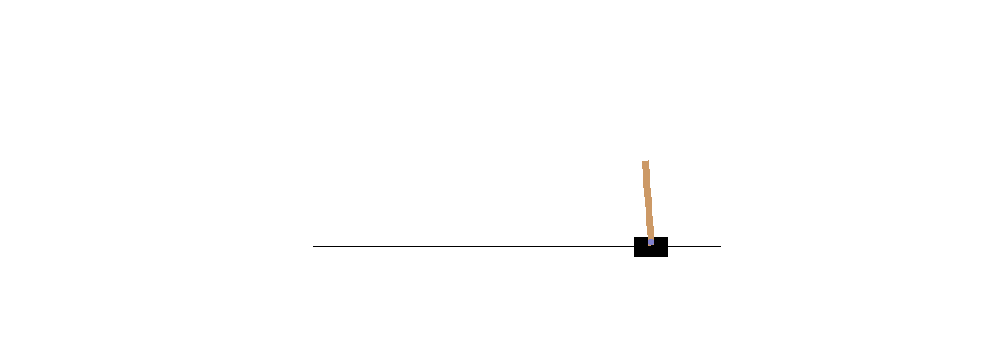
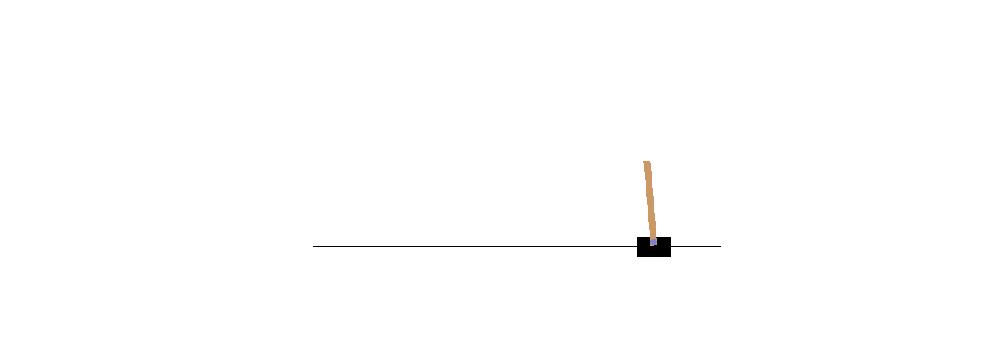
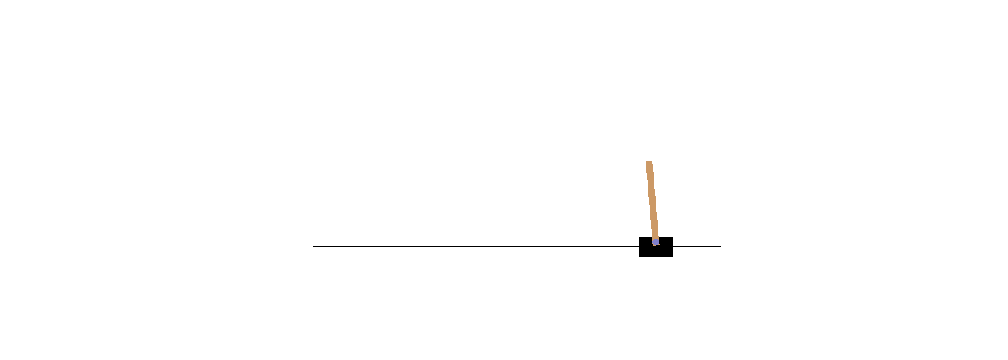
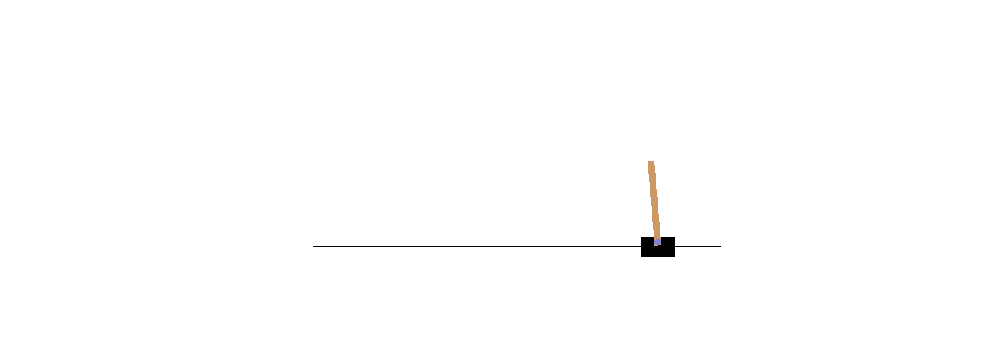
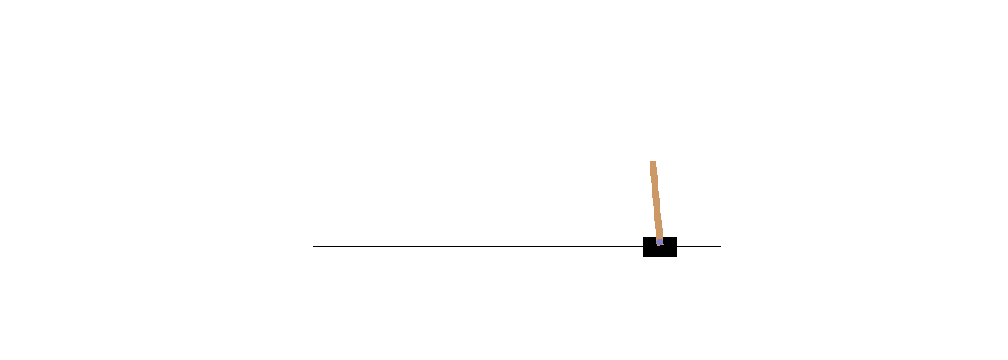
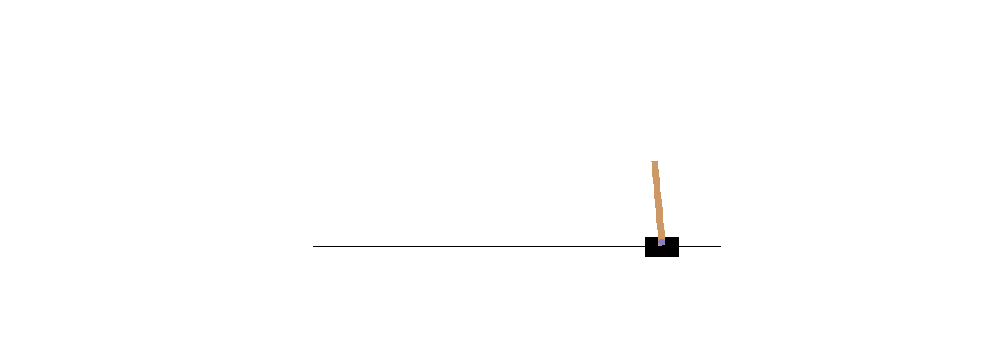
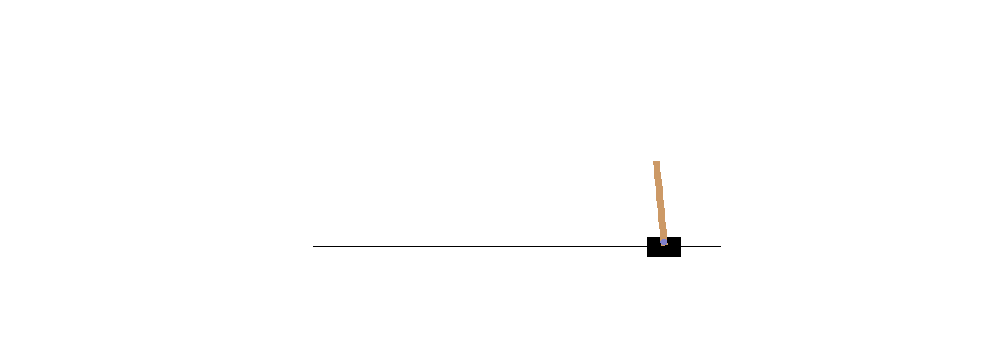
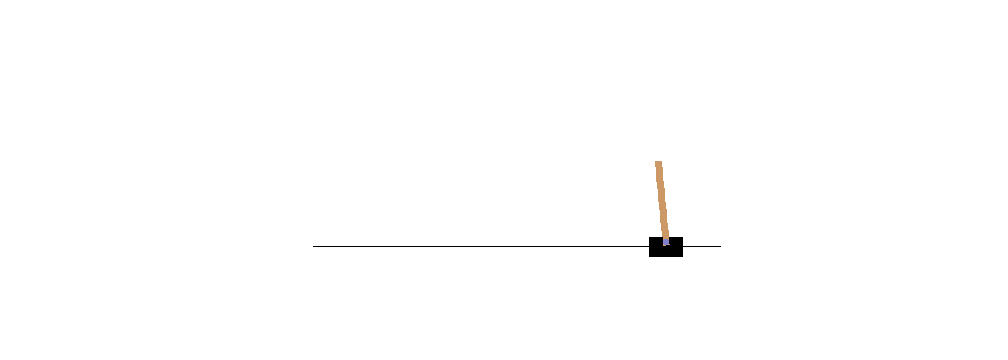
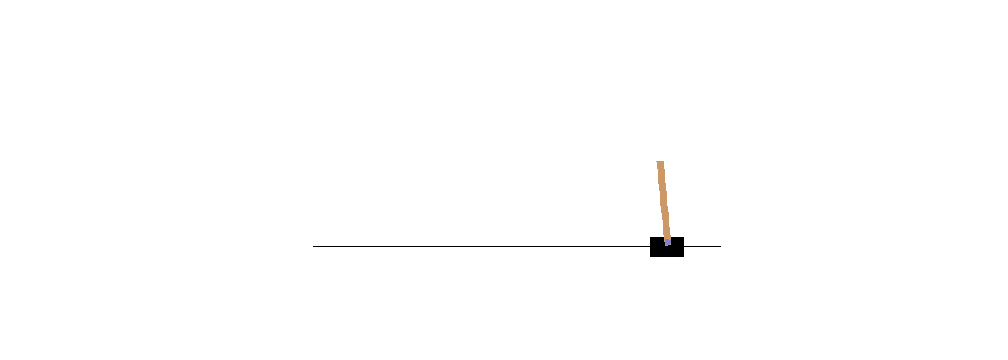
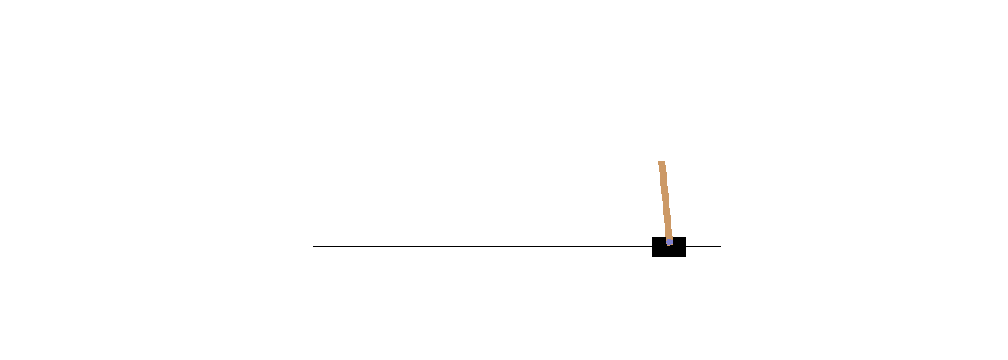
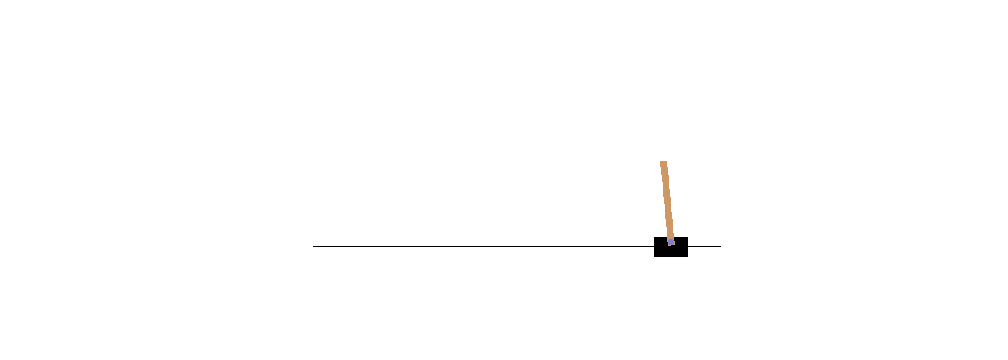
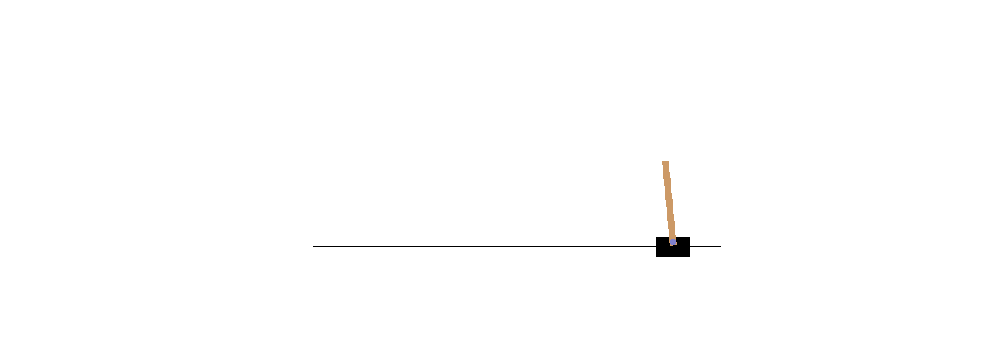
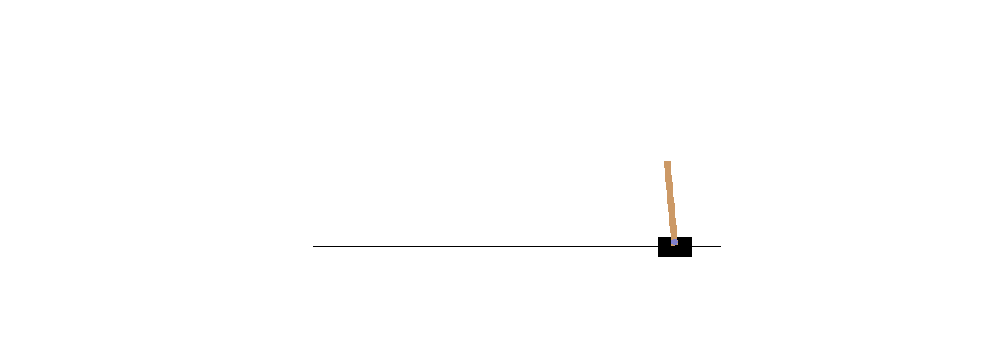
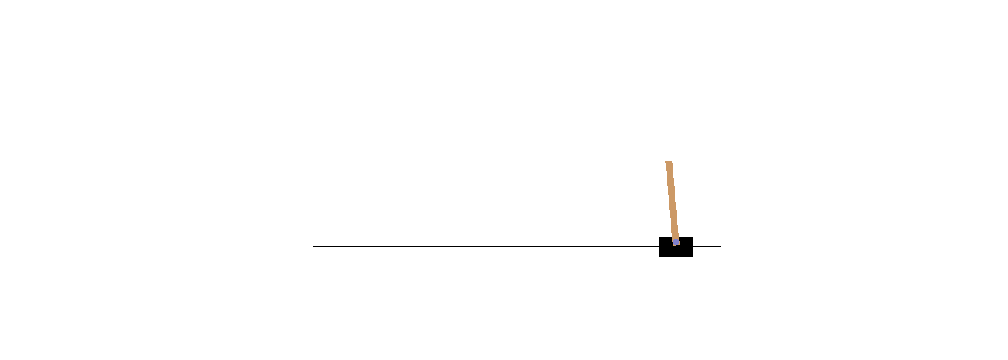
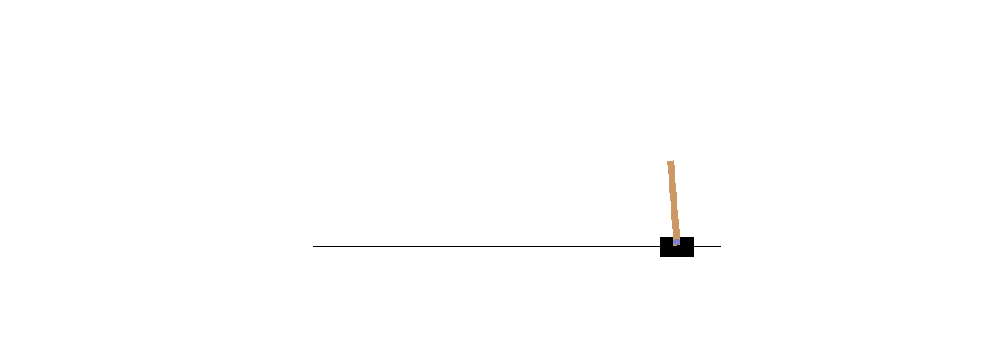
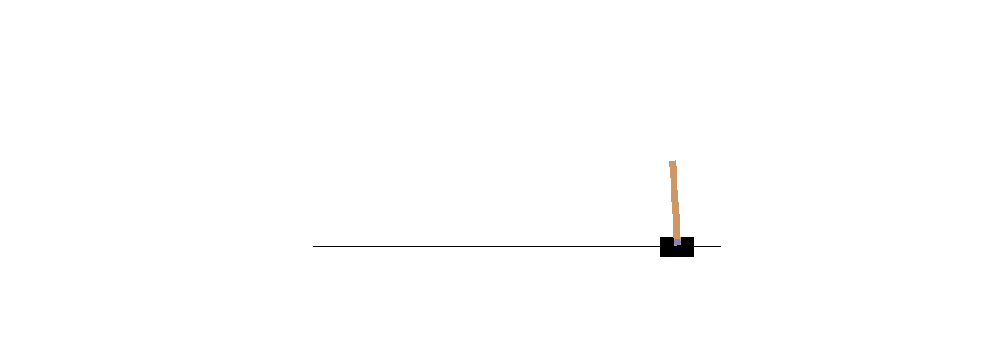
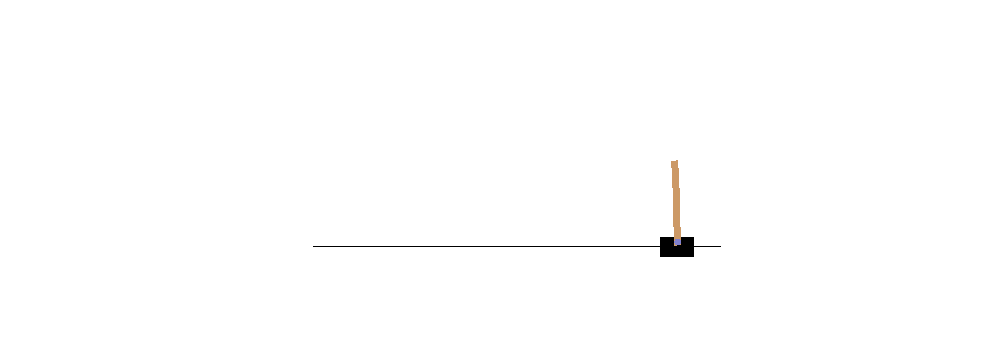
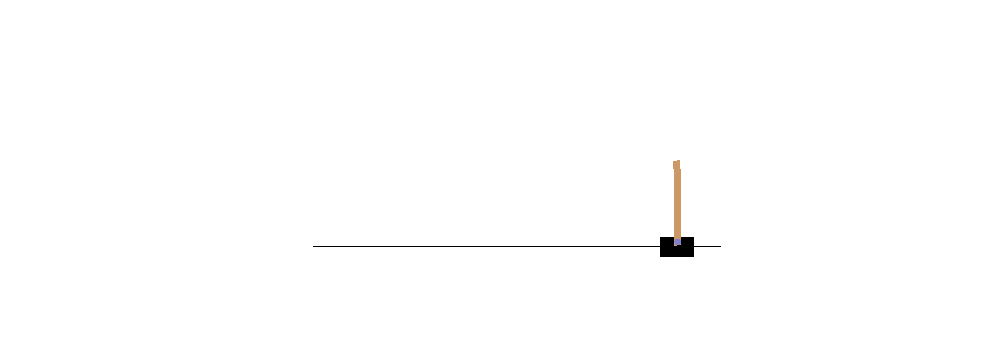
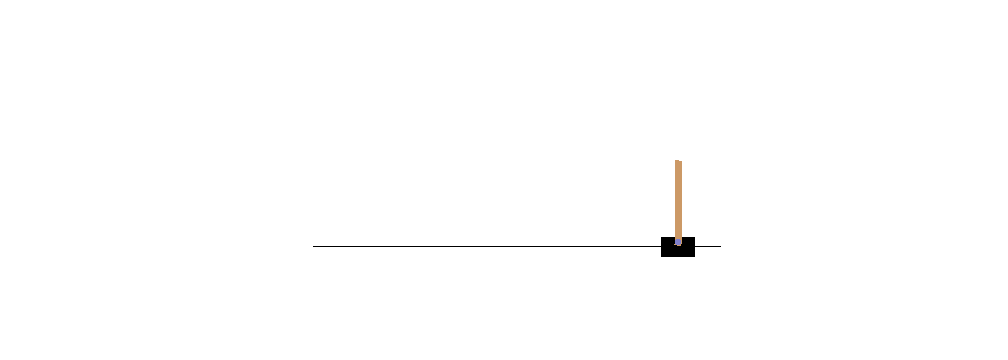
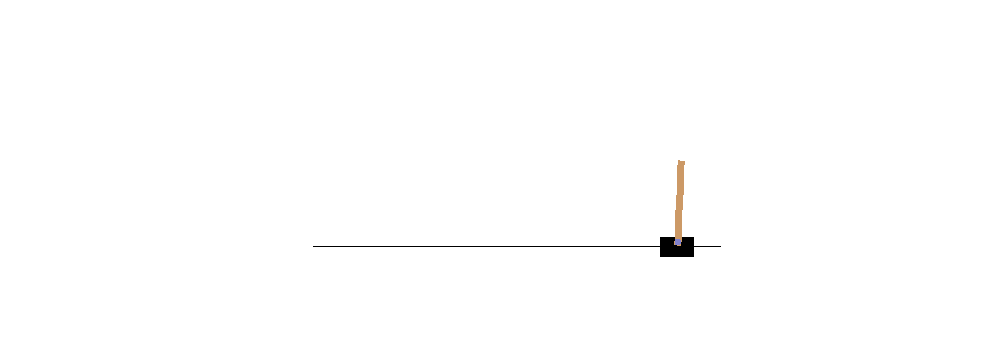
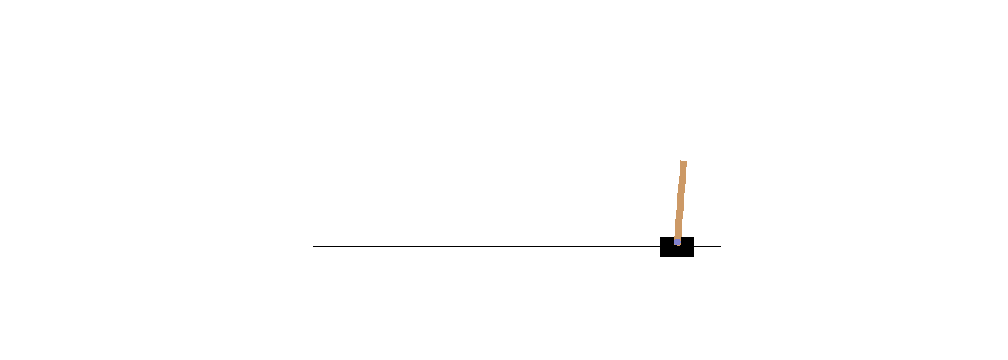
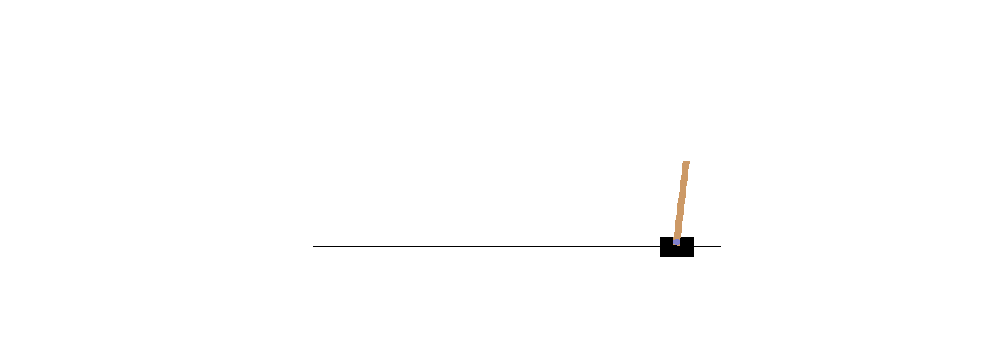
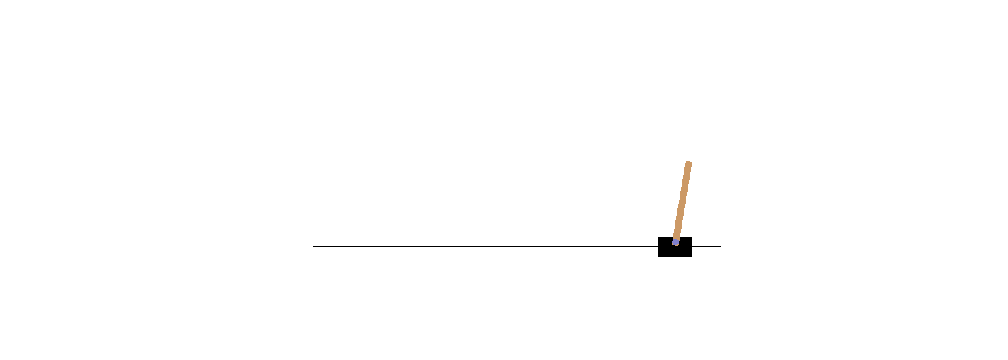

195.0

In [42]:
play_one_episode(model, env, 0, gamma, display=True)